# Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from math import exp
import mediapipe as mp
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,ConfusionMatrixDisplay

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
initial_learning_rate=0.1
batch_size=1
path="C:\\Users\\ganga\Jupyter Notebook\\FINAL YEAR PROJECT\\"

# Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# Extract Keypoint Values

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    print(f'Pose: {pose}')
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    print(f'Face: {face}')
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    print(f'Left Hand: {lh}')
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    print(f'Right Hand: {rh}')
    return np.concatenate([pose, face, lh, rh])

# Setup Folders 

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['','hello', 'thank you', 'eat'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'': 0, 'hello': 1, 'thank you': 2, 'eat': 3}

# Preprocess Data and Create Labels and Features

In [10]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [11]:
np.array(os.listdir(os.path.join(DATA_PATH, action)))

array(['20221218173741482468', '20221218173741591177',
       '20221218173741700884', '20221218173741810590',
       '20221218173741920951', '20221218173742032084',
       '20221218173742141791', '20221218173742253492',
       '20221218173742361205', '20221218173742470911',
       '20221218173742579621', '20221218173742688330',
       '20221218173742800067', '20221218173742909772',
       '20221218173743021488', '20221218173743133193',
       '20221218173743241885', '20221218173743351591',
       '20221218173743462310', '20221218173743572965',
       '20221218173743684702', '20221218173743793642',
       '20221218173743902392', '20221218173744010961',
       '20221218173744119756', '20221218173744228736',
       '20221218173744337840', '20221218173744446106',
       '20221218173744553699', '20221218173825624669',
       '20221219192510952602', '20221219192511060150',
       '20221219192511169248', '20221219192511276366',
       '20221219192511385989', '20221219192511495753',
       '20

In [12]:
np.array(sequences).shape

(961, 30, 1662)

In [13]:
np.array(labels).shape

(961,)

In [14]:
X = np.array(sequences)

In [15]:
X.shape

(961, 30, 1662)

In [16]:
X

array([[[ 0.54207617,  0.36302966, -0.9649995 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54351079,  0.3640824 , -1.05005968, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54501402,  0.36557683, -1.14532971, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.54763758,  0.36452344, -1.07043803, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54843241,  0.36465889, -1.07754028, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54905778,  0.36477691, -1.0854758 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.54943639,  0.36475685, -1.07610261, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.55009383,  0.36485019, -1.12124574, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.54876423,  0.36416519, -1.1235069 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.49927211,  0.37452108, -1.44094789, ...,  

In [17]:
y = to_categorical(labels).astype(int)

In [18]:
y[:5]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)

In [20]:
y_test.shape

(97, 4)

# Build and Train LSTM Neural Network

In [45]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [46]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1],X.shape[2])))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(128, return_sequences=True, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(LSTM(64, return_sequences=False, activation='relu'))#kernel_regularizer=regularizers.l2(0.005),
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-tr

## 1

In [47]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [173]:
model.fit(X_train, y_train, epochs=1, callbacks=[tb_callback],shuffle=True)

27/27 [==============================] - 2s 84ms/step - loss: 0.1532 - categorical_accuracy: 0.9502


## 2

## 3

# Evaluation using Confusion Matrix and Accuracy

In [174]:
ypred = model.predict(X_test)

4/4 [==============================] - 0s 24ms/step


In [175]:
ypred

array([[5.55877865e-04, 7.96678578e-05, 8.42094600e-01, 1.57269895e-01],
       [1.14421286e-02, 9.88512278e-01, 7.64909419e-06, 3.79953563e-05],
       [9.24218073e-03, 9.90732670e-01, 3.69806526e-06, 2.14084685e-05],
       [9.97255981e-01, 3.23472574e-04, 5.49741846e-04, 1.87079574e-03],
       [1.62234588e-04, 2.56044477e-05, 9.05990973e-03, 9.90752220e-01],
       [3.70623748e-04, 3.15545840e-05, 8.57073724e-01, 1.42524138e-01],
       [2.96740677e-06, 5.03642354e-08, 9.99257505e-01, 7.39503128e-04],
       [6.87038973e-02, 8.80301416e-01, 1.80973895e-02, 3.28972340e-02],
       [1.13091360e-07, 4.24174446e-11, 9.99997735e-01, 2.12994746e-06],
       [7.50684285e-06, 8.05425842e-08, 9.99422669e-01, 5.69793046e-04],
       [1.49588755e-04, 2.66772422e-05, 7.51650007e-03, 9.92307246e-01],
       [9.22181644e-05, 4.22741596e-06, 9.71694887e-01, 2.82086693e-02],
       [9.91821587e-01, 1.25345588e-03, 2.10278132e-03, 4.82214941e-03],
       [1.08636799e-03, 5.31366840e-03, 3.51653784e

In [176]:
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

In [177]:
multilabel_confusion_matrix(ytrue, ypred)

array([[[74,  0],
        [ 0, 23]],

       [[73,  0],
        [ 0, 24]],

       [[70,  1],
        [ 8, 18]],

       [[65,  8],
        [ 1, 23]]], dtype=int64)

In [178]:
[label_map.keys()]

[dict_keys(['', 'hello', 'thank you', 'eat'])]

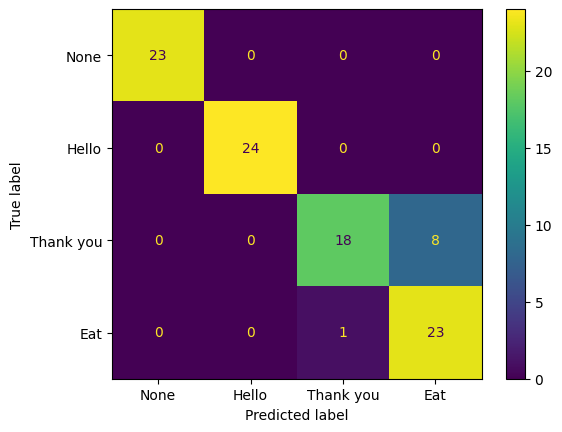

In [179]:
ConfusionMatrixDisplay.from_predictions(ytrue, ypred,display_labels=['None', 'Hello', 'Thank you', 'Eat'])

In [180]:
accuracy_score(ytrue, ypred)

0.9072164948453608

# Make Predictions

In [153]:
res = model.predict(X_test)

4/4 [==============================] - 0s 25ms/step


In [154]:
res

array([[6.41894352e-04, 2.95453647e-05, 9.79924202e-01, 1.94043405e-02],
       [3.76487442e-04, 9.99618649e-01, 5.64156267e-07, 4.28280373e-06],
       [1.41170720e-04, 9.99857783e-01, 7.23854541e-08, 9.59773615e-07],
       [9.95813668e-01, 5.46504511e-04, 7.04038248e-04, 2.93568429e-03],
       [3.46097775e-04, 9.28743248e-06, 5.81841879e-02, 9.41460431e-01],
       [8.45277740e-04, 2.25034182e-05, 9.63894188e-01, 3.52380760e-02],
       [3.16741398e-06, 8.46476134e-09, 9.99949098e-01, 4.76666755e-05],
       [2.27297507e-02, 9.73402083e-01, 2.21610465e-03, 1.65202469e-03],
       [1.52904465e-06, 3.74387521e-10, 9.99996901e-01, 1.52665791e-06],
       [6.27043482e-06, 1.49689576e-08, 9.99937892e-01, 5.57929816e-05],
       [2.14858330e-04, 4.79123264e-06, 3.80391441e-02, 9.61741209e-01],
       [4.86831741e-05, 9.20849118e-07, 9.96495306e-01, 3.45512014e-03],
       [9.90299940e-01, 1.33563625e-03, 2.10655271e-03, 6.25785813e-03],
       [2.93681456e-04, 2.56953848e-04, 1.81745668e

In [155]:
actions[np.argmax(res[4])]

'eat'

In [156]:
actions[np.argmax(y_test[4])]

'eat'

# Save Weights

In [170]:
model.save('action.h5')

In [158]:
from tensorflow.keras.models import load_model
model = load_model("action.h5")

In [159]:
test_DATA_PATH='MP_Data_CHGR'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 1s 37ms/step


0.65

In [160]:
test_DATA_PATH='MP_Data_sri'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 30ms/step


0.5083333333333333

In [161]:
test_DATA_PATH='MP_Data-srinu'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 31ms/step


0.5333333333333333

In [162]:
test_DATA_PATH='MP_Data_gangadhar_v2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 40ms/step


1.0

In [163]:
test_DATA_PATH='MP_Data_gangadhar_v3'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 32ms/step


0.9666666666666667

In [164]:
test_DATA_PATH='MP_Data_jagadesh'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 30ms/step


0.975

In [165]:
test_DATA_PATH='MP_Data_jagadesh_v2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 30ms/step


0.9666666666666667

In [166]:
test_DATA_PATH='MP_Data_venky'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 31ms/step


0.975

In [167]:
test_DATA_PATH='MP_Data_venky_v2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 31ms/step


0.9504132231404959

In [168]:
test_DATA_PATH='MP_Data_kundan_v1'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 30ms/step


0.9916666666666667

In [169]:
test_DATA_PATH='MP_Data_kundan_v2'
sequences_test, labels_test = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(test_DATA_PATH, action if action else 'None'))):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(test_DATA_PATH, action if action else 'None', str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences_test.append(window)
        labels_test.append(label_map[action])
sequences_test=np.array(sequences_test)
labels_test = to_categorical(labels_test).astype(int)
ypred = model.predict(sequences_test)
ytrue = np.argmax(labels_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

4/4 [==============================] - 0s 30ms/step


0.975

# Test in Real Time

In [139]:
from tensorflow.keras.models import load_model
model = load_model("action.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 596,708
Trainable params: 596,708
Non-trai

In [143]:
from scipy import stats

In [144]:
colors = [(255, 0, 0),(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [145]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5,model_complexity=0) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

Pose: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Face: [0. 0. 0. ... 0. 0. 0.]
Left Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Right Hand: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Pose: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


Pose: [ 5.38534522e-01  5.70601046e-01 -2.07575369e+00  9.99522507e-01
  5.82265973e-01  4.91907448e-01 -2.09550810e+00  9.99195874e-01
  6.04528308e-01  4.89458531e-01 -2.09789085e+00  9.99198735e-01
  6.22373939e-01  4.87108737e-01 -2.09712458e+00  9.99146700e-01
  5.07247090e-01  4.92724836e-01 -2.04100752e+00  9.99225676e-01
  4.86076295e-01  4.88695621e-01 -2.04146814e+00  9.99163330e-01
  4.68596697e-01  4.83739197e-01 -2.04114366e+00  9.99080300e-01
  6.49752736e-01  4.94613439e-01 -1.46046436e+00  9.99078333e-01
  4.39443886e-01  4.84993666e-01 -1.48232400e+00  9.99209285e-01
  5.86081445e-01  6.45164609e-01 -1.90404165e+00  9.99591470e-01
  4.94319499e-01  6.53293729e-01 -1.89501214e+00  9.99559879e-01
  8.36841762e-01  8.54069889e-01 -1.10173786e+00  9.95874941e-01
  3.18684578e-01  8.52240622e-01 -1.08167672e+00  9.96353030e-01
  9.27916527e-01  1.32198501e+00 -1.11297524e+00  5.46725810e-01
  2.20249742e-01  1.26691818e+00 -1.31637812e+00  3.48201960e-01
  8.97201717e-01  1

Pose: [ 0.59084952  0.53435117 -1.6428144   0.9995566   0.6203481   0.45706496
 -1.57957399  0.99925393  0.63765675  0.45499238 -1.57956672  0.99925685
  0.65343064  0.45273808 -1.57912433  0.99918211  0.55563551  0.46237046
 -1.58470094  0.99930865  0.53102773  0.46331489 -1.58495629  0.99927562
  0.50947058  0.4642804  -1.58475637  0.99919569  0.67776984  0.46438333
 -1.1108079   0.9991414   0.47986022  0.47969446 -1.14018297  0.99933124
  0.6304819   0.58761221 -1.4584595   0.99965721  0.54382497  0.60142338
 -1.46831393  0.99964172  0.85377103  0.85165781 -0.80214059  0.99665183
  0.34497499  0.86001807 -0.86947709  0.99711561  0.95904493  1.3113296
 -0.85318154  0.5263195   0.24846046  1.33296812 -1.09740162  0.40975702
  0.93436021  1.64585721 -1.37623858  0.17163733  0.28996706  1.64637649
 -1.70323789  0.06481207  0.9537344   1.76354921 -1.52299714  0.15592612
  0.27691287  1.7720412  -1.88862348  0.06492694  0.91039258  1.76532447
 -1.61685336  0.20510575  0.32981664  1.756808

Pose: [ 0.58840412  0.4884921  -1.54714239  0.99960327  0.62095875  0.4095197
 -1.47715366  0.99934286  0.63875866  0.40806171 -1.47735465  0.99936116
  0.65436649  0.40657902 -1.47708106  0.99927533  0.55528909  0.41437986
 -1.47898424  0.99938351  0.53086692  0.41580644 -1.47916806  0.99937183
  0.50974506  0.4171136  -1.47894979  0.99927944  0.67595446  0.42602113
 -0.98431051  0.99926025  0.48243958  0.43736997 -1.00037766  0.99940693
  0.62850386  0.54200089 -1.35433602  0.99971527  0.54330814  0.54938632
 -1.36050987  0.99969465  0.84545612  0.82453829 -0.67459768  0.99736154
  0.34615904  0.84143472 -0.70643997  0.99759233  0.95814037  1.2957921
 -0.7083956   0.51981229  0.25244993  1.31648755 -0.8067807   0.44880822
  0.92841369  1.63923061 -1.23996508  0.15619165  0.27789208  1.63419032
 -1.32543027  0.06184308  0.9484688   1.76070142 -1.39055085  0.14347883
  0.25185621  1.76388419 -1.47703838  0.0616351   0.89920795  1.75979578
 -1.48731112  0.1913888   0.30640703  1.7645393

Pose: [ 0.577995    0.49183133 -1.76265907  0.99973279  0.6136077   0.41807559
 -1.6821177   0.99955547  0.63251454  0.41636068 -1.68030798  0.99956489
  0.64789909  0.41431326 -1.6795857   0.99950826  0.54705757  0.41509917
 -1.68964064  0.99958318  0.52504748  0.41335282 -1.68966162  0.99957311
  0.50564766  0.41319123 -1.68818915  0.99951196  0.66315317  0.42993143
 -1.13436496  0.99950254  0.47792864  0.43244585 -1.19607234  0.99959564
  0.61656368  0.54773301 -1.56399095  0.99980545  0.53657269  0.55500633
 -1.57884812  0.9997924   0.81921005  0.81303501 -0.79322654  0.99793601
  0.32949632  0.80410838 -0.8161664   0.99812526  0.95062482  1.33322084
 -0.84813261  0.57672352  0.02397079  1.13883924 -1.67401695  0.55674785
  0.89705837  1.53369951 -1.30464149  0.33150646  0.19049008  0.64089674
 -2.52783179  0.37194493  0.92000377  1.60225844 -1.356704    0.30575484
  0.16191423  0.43753272 -2.71900797  0.36587408  0.87819564  1.60338616
 -1.40794349  0.35297072  0.21859014  0.41220

Pose: [ 0.5950073   0.5213992  -1.6799469   0.99982083  0.62469918  0.45285308
 -1.61594319  0.99969918  0.64127445  0.45066553 -1.6154635   0.99970376
  0.65676749  0.44760963 -1.61523402  0.99966687  0.56808048  0.450432
 -1.6105125   0.99971795  0.54650867  0.44759014 -1.61111236  0.99970973
  0.52524889  0.4457005  -1.61044562  0.99966967  0.67701578  0.45410076
 -1.12576413  0.99966508  0.49196053  0.4540115  -1.11631358  0.99972612
  0.62720001  0.57672238 -1.49184418  0.99986732  0.5536046   0.58724076
 -1.48895252  0.99986017  0.84359205  0.82905751 -0.76703572  0.9985016
  0.34629813  0.81437111 -0.75002062  0.99866074  0.93649518  1.36009288
 -0.85956305  0.64582878  0.04355504  1.09736383 -1.4967618   0.66910958
  0.90164995  1.53396559 -1.28160489  0.47822133  0.13365404  0.6200189
 -2.26997471  0.58112204  0.92059153  1.60631967 -1.33271194  0.43734705
  0.18834791  0.40370882 -2.43520999  0.56873053  0.896272    1.59952509
 -1.37631345  0.48028612  0.20321378  0.35842335 

Pose: [ 0.59901911  0.52360779 -1.5642786   0.9998439   0.63002574  0.45459828
 -1.49758232  0.99974871  0.6464479   0.45221981 -1.49705052  0.99974746
  0.66205364  0.4490968  -1.49675703  0.99972093  0.5691005   0.45356876
 -1.49795842  0.99975389  0.54632086  0.45095068 -1.49816525  0.999735
  0.52527851  0.44901201 -1.49750721  0.99970096  0.68155175  0.4571875
 -1.00097108  0.99973851  0.49484187  0.46004155 -1.00872517  0.9997412
  0.63414204  0.57691288 -1.3720628   0.99987519  0.55562961  0.58784008
 -1.37400734  0.99985993  0.8446641   0.83566821 -0.6626038   0.99832141
  0.35189474  0.82074189 -0.63870353  0.99773896  0.92824763  1.31918752
 -0.70928025  0.60293162  0.13911143  1.16262686 -1.33255661  0.62280393
  0.88025361  1.58093774 -1.09202147  0.44251704  0.13136634  0.68799627
 -2.39555478  0.68468684  0.8880536   1.7032944  -1.15729272  0.41454431
  0.14014725  0.54154396 -2.58295012  0.66810918  0.85509109  1.67944133
 -1.20914912  0.46404344  0.14496347  0.48942396 

Pose: [ 0.59974349  0.5213443  -1.575701    0.99957567  0.63000327  0.44977745
 -1.49610901  0.99944276  0.64656985  0.44676974 -1.49658179  0.99942744
  0.66235173  0.44340026 -1.49724436  0.99936199  0.56706607  0.45297146
 -1.51900208  0.99947619  0.54397887  0.45161998 -1.51969314  0.99945217
  0.52336472  0.45081756 -1.52028108  0.99939907  0.68199676  0.4562782
 -0.96882945  0.99941111  0.49389809  0.46597537 -1.02914548  0.99955189
  0.63637018  0.57138735 -1.32740271  0.99963516  0.5569523   0.58338571
 -1.37127614  0.99965274  0.84395838  0.83846372 -0.6073283   0.99525154
  0.34879223  0.84200084 -0.68684405  0.99434668  0.95089281  1.23059082
 -0.69696176  0.55411279  0.16824868  1.25539994 -1.05013216  0.59822714
  0.87332523  1.35677338 -1.26105738  0.3857632   0.22063768  1.38765073
 -1.7829622   0.60046172  0.85699767  1.41696739 -1.42769015  0.36226466
  0.22336738  1.45113111 -1.97784138  0.58050597  0.83683568  1.38634872
 -1.49313521  0.40734506  0.25152606  1.413294

1/1 [==============================] - 0s 24ms/step
hello
Pose: [ 0.44159275  0.4739297  -1.46950257  0.99955684  0.47768569  0.39832085
 -1.39549494  0.99939322  0.49825549  0.39611739 -1.39540517  0.99940956
  0.51554435  0.39419964 -1.39480913  0.99931908  0.41155124  0.39945295
 -1.40239978  0.99941224  0.39195296  0.39688423 -1.40230632  0.99941063
  0.37562519  0.39447725 -1.40208876  0.9993282   0.53770059  0.41199082
 -0.88882893  0.99935061  0.35231486  0.40555793 -0.92882985  0.99947429
  0.48233089  0.52811944 -1.2719214   0.99965674  0.40473503  0.52445644
 -1.28545213  0.99964893  0.6754697   0.81217188 -0.57152939  0.99629319
  0.18188365  0.77579665 -0.63751757  0.99549443  0.75035185  1.24649572
 -0.61375779  0.53748131  0.07326149  1.22498012 -0.74468255  0.58050507
  0.76209903  1.57943022 -1.17795444  0.28456801  0.07567199  1.63280261
 -1.30002022  0.42753503  0.77685279  1.70350707 -1.3212105   0.26832902
  0.04684305  1.77163815 -1.44861341  0.41358289  0.74276161

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 4.95364279e-01  4.89200175e-01 -1.71162963e+00  9.99463737e-01
  5.31813383e-01  4.13233131e-01 -1.64496112e+00  9.99250352e-01
  5.52943468e-01  4.11232680e-01 -1.64534032e+00  9.99297857e-01
  5.72115183e-01  4.09223080e-01 -1.64502203e+00  9.99136925e-01
  4.67057288e-01  4.13620025e-01 -1.63334942e+00  9.99261260e-01
  4.43724543e-01  4.11146611e-01 -1.63349664e+00  9.99288619e-01
  4.20946181e-01  4.08724874e-01 -1.63360858e+00  9.99157965e-01
  6.03467226e-01  4.22525346e-01 -1.12904835e+00  9.99181986e-01
  3.83668214e-01  4.16959167e-01 -1.07942367e+00  9.99358296e-01
  5.30216098e-01  5.43600202e-01 -1.50718057e+00  9.99616563e-01
  4.50878471e-01  5.50651193e-01 -1.49549651e+00  9.99601841e-01
  7.58985996e-01  8.11888099e-01 -7.85399377e-01  9.96560335e-01
  2.52242833e-01  7.70389974e-01 -6.85308337e-01  9.96119618e-01
  8.69666398e-01  1.25256145e+00 -8.55084062e-01  5.19122243e-01
  1.47431821e-01  1.183107

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.43230811  0.58157212 -2.84822321  0.99925578  0.47703481  0.43866917
 -2.83613086  0.99895018  0.52267635  0.42072222 -2.83650541  0.99896592
  0.56247419  0.40531099 -2.83710194  0.99880528  0.36748353  0.47396028
 -2.80853128  0.99892223  0.33788812  0.47998258 -2.80937529  0.99883229
  0.31257951  0.48546359 -2.80928063  0.99863499  0.61708909  0.39554963
 -2.37538028  0.99901342  0.27968791  0.48628315 -2.23962331  0.99897939
  0.53810745  0.64919919 -2.62863493  0.99937874  0.40684038  0.68341649
 -2.59148765  0.99924743  0.85882568  0.74614334 -1.84344351  0.99556905
  0.27846968  0.79967648 -1.65004802  0.99459082  1.03604054  1.13673699
 -1.61617625  0.53205764  0.18323267  1.25049829 -1.50242758  0.53483504
  0.98897111  1.38935256 -1.69273245  0.19793282  0.18160178  1.60053527
 -1.76010585  0.23620947  1.00654364  1.45981002 -1.80463564  0.18124378
  0.15736677  1.71380615 -1.88688684  0.22788461  0.96897399

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.5573352   0.62437987 -2.1759758   0.99908799  0.59782785  0.52178752
 -2.1302731   0.99874353  0.62449712  0.51200467 -2.1304059   0.99875981
  0.65068918  0.50193638 -2.12988901  0.99861646  0.5263232   0.52957332
 -2.10878491  0.99880129  0.50967157  0.52526575 -2.10933733  0.99874574
  0.49488696  0.5204705  -2.10979557  0.99859393  0.69126642  0.4689396
 -1.63889813  0.99884897  0.48266119  0.50475919 -1.52648127  0.99892348
  0.60781622  0.67014188 -1.96582985  0.99927467  0.53242552  0.67725497
 -1.9387331   0.99911308  0.87974703  0.71170294 -1.17466676  0.99585027
  0.3780182   0.8016355  -1.00251305  0.99533498  1.01418054  1.16986632
 -1.10709453  0.57674378  0.27755678  1.25806892 -1.28509223  0.51120144
  0.92410833  1.29545176 -1.57023692  0.21320449  0.32784718  1.30293596
 -2.25989604  0.22402379  0.91259575  1.38970268 -1.68911004  0.18687262
  0.32894906  1.33205163 -2.45603895  0.2164948   0.90282238 

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.71058547  0.45446303 -1.45108461  0.99888682  0.74390864  0.38691884
 -1.37086213  0.99852639  0.762079    0.38657734 -1.37104869  0.99850219
  0.77865261  0.38684687 -1.3708359   0.99827784  0.68649948  0.38204238
 -1.38643003  0.99863094  0.6658076   0.37827533 -1.38678133  0.99861276
  0.6456548   0.3750374  -1.38685763  0.9985013   0.79704911  0.39851955
 -0.8325054   0.99849164  0.61388618  0.38422865 -0.91547221  0.99889219
  0.73870444  0.51306212 -1.24094856  0.99916863  0.67236274  0.51418042
 -1.26642239  0.99909908  0.93226832  0.73227727 -0.51822656  0.99378347
  0.46675009  0.75697392 -0.61024678  0.99481004  1.02521396  1.18596911
 -0.6319508   0.55316931  0.27591467  1.15312207 -1.04452431  0.55028677
  0.99476516  1.44050908 -1.28898895  0.23683368  0.3728469   1.27435243
 -2.07999563  0.29816371  1.00357401  1.55376804 -1.44232774  0.20891531
  0.3893663   1.32691932 -2.23364925  0.28009009  0.97570133  1.5

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.66515952  0.37302002 -1.42259312  0.99893039  0.69867265  0.30307579
 -1.348418    0.9986254   0.71890241  0.30187836 -1.34798121  0.99860078
  0.73689139  0.30044448 -1.34730208  0.99839145  0.63845056  0.30074358
 -1.35231233  0.99872476  0.62343872  0.29829714 -1.352355    0.99872625
  0.61158907  0.29594904 -1.35207021  0.99864548  0.75452644  0.32177204
 -0.84196389  0.99850732  0.58371079  0.31090325 -0.87251484  0.99899971
  0.69967979  0.42694494 -1.22666335  0.99920475  0.62908584  0.42598733
 -1.23720562  0.99917579  0.8773554   0.70252192 -0.54950345  0.99390966
  0.41134357  0.70662171 -0.55429256  0.99499702  0.98948079  1.13344777
 -0.64510775  0.55925715  0.27796978  1.05607188 -1.00882769  0.55681992
  0.92859697  1.40682065 -1.23626566  0.25972563  0.30803698  1.12821794
 -1.98056865  0.34661198  0.93584728  1.52189183 -1.37314165  0.23507062
  0.27052477  1.24224746 -2.17120123  0.32861036  0.90024155  1.5

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.57522571  0.40640447 -1.52421165  0.9991824   0.61116385  0.33408356
 -1.44901717  0.99891013  0.63354671  0.33224887 -1.44909108  0.99890214
  0.65335649  0.33030802 -1.44861567  0.99873382  0.54496872  0.33178711
 -1.45581102  0.99899918  0.52682632  0.3287001  -1.45599055  0.99901503
  0.51072371  0.32581046 -1.4559238   0.998941    0.67560101  0.34353468
 -0.9381448   0.99877822  0.486909    0.3366774  -0.9750247   0.99918437
  0.6145438   0.46317926 -1.32679045  0.99938619  0.5367617   0.46591872
 -1.3395555   0.99936146  0.79886186  0.74466497 -0.63930249  0.99517959
  0.32347614  0.72360295 -0.6657902   0.99589837  0.85059893  1.2269845
 -0.69963014  0.54953521  0.20529401  1.07063746 -0.85087204  0.55519867
  0.74570781  1.51188481 -1.20874882  0.21402074  0.21150279  1.54075694
 -1.45427752  0.29205579  0.73264116  1.61944771 -1.35132957  0.19463825
  0.19185393  1.65765846 -1.61954188  0.27666646  0.69470513  1.60

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.50303149  0.44431633 -1.52749717  0.9993605   0.53727758  0.37306827
 -1.4673413   0.99912435  0.56110662  0.36998412 -1.46705866  0.99912685
  0.58193821  0.36620173 -1.46640193  0.9989816   0.47352234  0.37602559
 -1.45362532  0.99920171  0.45539385  0.37450796 -1.45407784  0.9992277
  0.43828663  0.37326524 -1.45390105  0.99916339  0.61381781  0.37294266
 -1.00007033  0.99895829  0.41335955  0.37998253 -0.93091422  0.9993329
  0.54595512  0.5033223  -1.33988023  0.99950582  0.46770477  0.52078068
 -1.32234406  0.99949527  0.76315993  0.75724095 -0.75713509  0.99639654
  0.29072836  0.75222421 -0.55938005  0.99682969  0.84620064  1.24701202
 -1.20461202  0.57876748  0.17685063  1.21685171 -0.74571383  0.50772798
  0.61324131  1.16837895 -2.01344347  0.29303473  0.15402582  1.53768814
 -1.41431355  0.21714503  0.56200272  1.17196131 -2.22528028  0.26378635
  0.12383904  1.65408385 -1.5697751   0.20662673  0.52659333  1.117

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.45955762  0.47792974 -1.65106833  0.99935687  0.50305039  0.39826411
 -1.57987869  0.99909222  0.526371    0.39165843 -1.58032262  0.99912322
  0.54680097  0.38525385 -1.58048248  0.99895793  0.43629247  0.40976492
 -1.56257093  0.99917847  0.41706151  0.41024321 -1.56285703  0.99922174
  0.40163231  0.41027275 -1.56286979  0.9991414   0.58427608  0.38952658
 -1.0466429   0.9989453   0.39520052  0.41974097 -0.98182565  0.9993189
  0.51606303  0.53051704 -1.43678164  0.99950874  0.43059254  0.55049461
 -1.42033637  0.99948996  0.78628057  0.77322161 -0.76376826  0.99650729
  0.29357988  0.80591083 -0.58979064  0.99681246  0.87295085  1.25981891
 -1.09029591  0.58818471  0.18495426  1.29991579 -0.85019714  0.49629197
  0.77486795  1.41445804 -1.73701918  0.24061787  0.18451905  1.56220114
 -1.667238    0.17808655  0.75667626  1.4925164  -1.92826819  0.21478835
  0.16236243  1.66946745 -1.85992718  0.17014121  0.7338171   1.47

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.55187112  0.38906962 -1.6840477   0.99935704  0.59100884  0.29713356
 -1.59277809  0.99901265  0.60863912  0.29464209 -1.59310472  0.99907893
  0.62458235  0.29240656 -1.59313083  0.99885958  0.52932036  0.30015022
 -1.60767615  0.99910492  0.50516856  0.29827589 -1.6078583   0.99918121
  0.48253757  0.29589063 -1.60765588  0.99906576  0.65064436  0.30942723
 -1.04139626  0.99886161  0.4497911   0.30944985 -1.07698524  0.99929518
  0.58710647  0.44553757 -1.46372461  0.99955237  0.50801164  0.44817621
 -1.47614789  0.99953765  0.81498879  0.72185391 -0.69831181  0.99714643
  0.29603964  0.75203198 -0.74206489  0.99745929  0.95820522  1.23260915
 -0.74601859  0.5895775   0.18658032  1.27814162 -0.85180914  0.55094987
  0.98503381  1.6000787  -1.35449207  0.1848217   0.19289497  1.64747012
 -1.45918465  0.14061753  1.01879609  1.73575079 -1.50528097  0.16232073
  0.1645662   1.78614354 -1.62317884  0.1318258   0.97352087  1.7

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.57613236  0.44048557 -1.34839213  0.9994027   0.61053419  0.36732346
 -1.27990568  0.99908453  0.6288811   0.36487293 -1.27980781  0.99912924
  0.64508069  0.36296719 -1.2791431   0.99891007  0.55459481  0.36625043
 -1.28157735  0.99918681  0.53579062  0.36298802 -1.28194702  0.99926144
  0.51727712  0.35922351 -1.28211021  0.99916351  0.67013514  0.36810583
 -0.79447991  0.99883372  0.49360913  0.35964555 -0.80438864  0.9993543
  0.61052012  0.50020689 -1.15776742  0.99951726  0.54556209  0.49469656
 -1.16246343  0.99952811  0.81608945  0.72228783 -0.54149258  0.99623609
  0.37053245  0.71542186 -0.46810389  0.99714082  0.92828751  1.15131116
 -0.71538943  0.57390982  0.27657279  1.03750741 -0.78543657  0.55717957
  0.79176497  1.24504781 -1.27579391  0.18648787  0.25861505  1.28845167
 -1.59930313  0.16716625  0.76191568  1.29670656 -1.42166591  0.16421004
  0.24853823  1.35312021 -1.79609239  0.15792555  0.74055803  1.26

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.59358948  0.5204587  -1.27539945  0.99943817  0.62171113  0.45669657
 -1.21297109  0.99911869  0.63830632  0.45436186 -1.21267772  0.99914289
  0.65357077  0.45187956 -1.21209693  0.99894512  0.57259953  0.45626062
 -1.21955264  0.99924028  0.55539131  0.45381865 -1.21985936  0.99932122
  0.53817528  0.45139283 -1.21993291  0.99925518  0.67149937  0.45693958
 -0.76586139  0.99870712  0.51399505  0.45604509 -0.78977692  0.99937189
  0.62193823  0.57369697 -1.09838796  0.99942398  0.56653327  0.5761888
 -1.10618556  0.99947876  0.78847671  0.76506346 -0.51069009  0.99620271
  0.3867873   0.75261956 -0.47814789  0.99708569  0.90222442  1.12384236
 -0.56621385  0.60412878  0.29724669  1.17039061 -0.58250195  0.56237245
  0.82437736  1.26307786 -1.01314783  0.23559254  0.3007161   1.36681581
 -1.05289197  0.22908612  0.81642503  1.32516098 -1.13667464  0.20365427
  0.29018903  1.43783236 -1.18818998  0.21833856  0.7925725   1.30

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.58643854  0.5432238  -1.44496131  0.99945909  0.61653626  0.46868128
 -1.39327443  0.99913538  0.63398731  0.46593732 -1.39331412  0.99916369
  0.65080184  0.46268177 -1.39288366  0.99898255  0.56266963  0.46779633
 -1.38457632  0.99924213  0.54500854  0.46454701 -1.38487077  0.99932408
  0.5287593   0.46106175 -1.38490486  0.9992696   0.66530061  0.46572164
 -0.93394268  0.99868679  0.50856507  0.46279451 -0.89754283  0.9993481
  0.61784297  0.59669751 -1.25810301  0.99940306  0.55686516  0.59902662
 -1.24940085  0.99945617  0.78678375  0.77839655 -0.6183331   0.99670148
  0.38700229  0.76285613 -0.51482427  0.99718082  0.90416706  1.15538335
 -0.79393148  0.64191908  0.30223972  1.07611895 -0.73034388  0.57293731
  0.77104127  1.14113235 -1.40123105  0.28659713  0.29488033  1.30348539
 -1.50396657  0.27619314  0.74413216  1.22208607 -1.55637431  0.24867395
  0.2820704   1.36449277 -1.69144821  0.26124057  0.7063117   1.20

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.57408726  0.49894923 -1.59360492  0.99917382  0.61222094  0.42310292
 -1.53031182  0.99877566  0.63131964  0.42055827 -1.53035498  0.99885404
  0.64887416  0.41732055 -1.53023648  0.99863505  0.54962891  0.41891271
 -1.53881574  0.99886894  0.53002614  0.41305622 -1.53915167  0.99896073
  0.51339519  0.4068217  -1.53911328  0.99888659  0.6717056   0.41058493
 -1.02517235  0.99831474  0.49276218  0.39576688 -1.06658387  0.99900401
  0.61343026  0.55989182 -1.38810825  0.9992367   0.53894949  0.56272542
 -1.40221524  0.99925864  0.80779457  0.73877513 -0.69246274  0.99669117
  0.34895048  0.71713644 -0.72332698  0.99717605  0.8865301   1.08489501
 -0.7791881   0.63802212  0.25595132  1.05288899 -0.83545238  0.58041328
  0.81636858  1.25289083 -1.29908109  0.2692627   0.26249769  1.50970101
 -1.36398911  0.26327875  0.81497633  1.32721305 -1.43668985  0.23407193
  0.23799522  1.63034511 -1.522861    0.24628082  0.7862705   1.2

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.54423404  0.50087047 -1.5372349   0.99867457  0.58673978  0.39918453
 -1.4933722   0.9982655   0.61135995  0.39419326 -1.49317241  0.99834847
  0.63115948  0.38876998 -1.49260271  0.99814731  0.51229298  0.39979154
 -1.47175705  0.99826908  0.49154115  0.39387956 -1.47219849  0.99822682
  0.4759039   0.38672104 -1.47203147  0.99810123  0.66174257  0.38024443
 -1.06437933  0.99794978  0.45130524  0.37176657 -0.97112244  0.99826437
  0.59351456  0.56484437 -1.36246085  0.99852955  0.50677472  0.56774098
 -1.33793759  0.99846011  0.82085073  0.70740885 -0.82153308  0.99488443
  0.31886202  0.69030011 -0.60999668  0.99505615  0.92289084  1.17897224
 -1.32661247  0.67662406  0.24305603  1.10643756 -0.75163531  0.57136691
  0.67960435  1.02413964 -2.17363191  0.36837545  0.29442844  1.32914364
 -1.33755255  0.25848469  0.61923265  0.98441869 -2.39386821  0.33057824
  0.29195303  1.4036392  -1.47307587  0.24259578  0.58303463  0.8

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.53947365  0.50009084 -1.21393752  0.99886417  0.57340389  0.41201401
 -1.16447997  0.99850082  0.59573996  0.40698713 -1.16420603  0.99855173
  0.61374271  0.40213457 -1.16363311  0.99838167  0.50974405  0.41710931
 -1.14587367  0.99851727  0.49248022  0.41488898 -1.14622331  0.99850017
  0.47787014  0.4126319  -1.14632761  0.99841231  0.62966895  0.40145203
 -0.75315911  0.99805015  0.46077967  0.4105503  -0.66862726  0.99845576
  0.57629097  0.55605048 -1.04854083  0.99860162  0.51128185  0.56044471
 -1.02606976  0.99857962  0.76091796  0.71812856 -0.57141     0.99428743
  0.35432923  0.69827789 -0.3055934   0.99435157  0.83887303  1.13406909
 -1.10309339  0.71268982  0.2874023   1.12621081 -0.71008295  0.53811663
  0.62169778  0.98615253 -1.86412621  0.51477736  0.2932452   1.0345546
 -1.61427331  0.35993394  0.56031358  0.94807255 -2.05496836  0.47411686
  0.2890411   1.00344372 -1.79421175  0.34803393  0.55494112  0.87

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.55815876  0.48904988 -1.20898044  0.99909043  0.58211911  0.41367361
 -1.15338767  0.99876827  0.59990156  0.40942803 -1.15325522  0.99878526
  0.61624283  0.4053987  -1.15260196  0.9986431   0.53045034  0.41865548
 -1.14471877  0.99882054  0.51533222  0.41746596 -1.14500868  0.99882877
  0.50025094  0.41646805 -1.14521635  0.99877709  0.63427889  0.41115916
 -0.73830259  0.99821925  0.48350215  0.42115328 -0.69675446  0.99875879
  0.59091485  0.54306793 -1.04477906  0.99874324  0.53433818  0.54898494
 -1.03444481  0.9987818   0.76388985  0.72531164 -0.52625144  0.99395043
  0.38133627  0.72870529 -0.3792381   0.99407309  0.83347905  1.13249958
 -0.80317581  0.72087514  0.31056991  1.17414904 -0.66292125  0.53653044
  0.71453726  1.17041862 -1.4114033   0.57060438  0.30451071  1.30604362
 -1.4231503   0.43226323  0.70006001  1.20117736 -1.56944323  0.52699441
  0.29344863  1.3683275  -1.59569919  0.42360693  0.69648325  1.1

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.61873436e-01  4.87991124e-01 -1.16762602e+00  9.99269128e-01
  5.83332121e-01  4.18435574e-01 -1.11111486e+00  9.98975933e-01
  6.00902736e-01  4.14956480e-01 -1.11101794e+00  9.98975217e-01
  6.17623210e-01  4.11571652e-01 -1.11042929e+00  9.98852432e-01
  5.34270883e-01  4.22975242e-01 -1.10618389e+00  9.99055326e-01
  5.19524097e-01  4.22433078e-01 -1.10650611e+00  9.99081373e-01
  5.05039573e-01  4.22086656e-01 -1.10666430e+00  9.99049008e-01
  6.35674953e-01  4.19277489e-01 -6.93845630e-01  9.98420179e-01
  4.88545835e-01  4.29548323e-01 -6.72618270e-01  9.99000847e-01
  5.94050288e-01  5.41223645e-01 -1.00203490e+00  9.98915911e-01
  5.38051844e-01  5.47039568e-01 -9.97127175e-01  9.98979092e-01
  7.61387587e-01  7.27365613e-01 -4.65401560e-01  9.94071841e-01
  3.81099135e-01  7.31432676e-01 -3.70952904e-01  9.94565010e-01
  8.18947434e-01  1.12381899e+00 -6.16229177e-01  6.97621822e-01
  3.08413804e-01  1.15788054e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.5633384   0.48512712 -1.1780045   0.99943042  0.58593673  0.41901591
 -1.11914074  0.99916667  0.60229927  0.41595799 -1.11906064  0.99916041
  0.61829692  0.4128525  -1.11839283  0.99904281  0.53590578  0.42325225
 -1.11546493  0.99925572  0.52095115  0.42278937 -1.1157124   0.99929214
  0.50657052  0.42236173 -1.11589873  0.99926651  0.63622928  0.42065236
 -0.70244539  0.99864173  0.4905881   0.42972162 -0.68389338  0.99922073
  0.59616125  0.53737217 -1.01434541  0.99912381  0.53859121  0.5432567
 -1.0102402   0.99919516  0.75981224  0.72973931 -0.47564992  0.99462301
  0.38271636  0.73180354 -0.3913911   0.99533302  0.81036055  1.05530167
 -0.60458964  0.6747973   0.30607551  1.15473878 -0.63953984  0.54242486
  0.77958238  1.24848592 -1.1155808   0.49266762  0.30047256  1.3397094
 -1.34483433  0.42912385  0.77432078  1.30323899 -1.2473104   0.45020148
  0.2843098   1.42132175 -1.51266932  0.42489636  0.75999016  1.280

1/1 [==============================] - 0s 24ms/step

Pose: [ 5.71544528e-01  4.79672581e-01 -1.05197489e+00  9.99486744e-01
  5.94556749e-01  4.16849822e-01 -9.94652569e-01  9.99251187e-01
  6.09252572e-01  4.14271623e-01 -9.94468808e-01  9.99233484e-01
  6.24493420e-01  4.11721438e-01 -9.93709564e-01  9.99132216e-01
  5.46526313e-01  4.19208586e-01 -9.87800598e-01  9.99338388e-01
  5.31228364e-01  4.18145239e-01 -9.88172352e-01  9.99374211e-01
  5.16830325e-01  4.17355031e-01 -9.88418877e-01  9.99361038e-01
  6.40710950e-01  4.20924753e-01 -5.92864692e-01  9.98699903e-01
  4.98582840e-01  4.25833434e-01 -5.63434184e-01  9.99294221e-01
  6.01213336e-01  5.33741832e-01 -8.95180523e-01  9.99158263e-01
  5.44545531e-01  5.37440836e-01 -8.88679326e-01  9.99240756e-01
  7.59869337e-01  7.32453167e-01 -4.09239143e-01  9.94534433e-01
  3.85174870e-01  7.31059611e-01 -2.63726592e-01  9.95123148e-01
  8.23606789e-01  1.11499190e+00 -7.53581226e-01  6.88986897e-01
  3.16222459e-01  1.04063737e+0

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.57350254  0.48123392 -1.18919504  0.99958789  0.59641945  0.41804302
 -1.11444867  0.99938577  0.61053348  0.41577214 -1.11414421  0.99936557
  0.62470925  0.41341946 -1.11362982  0.99929821  0.54826176  0.41945896
 -1.11847234  0.99944836  0.53226233  0.41813144 -1.11875927  0.99947196
  0.51683581  0.41711912 -1.1182214   0.99946684  0.6369015   0.42191571
 -0.62664801  0.99896479  0.49472505  0.42265213 -0.67302406  0.99940139
  0.6015709   0.53573543 -1.0117619   0.99932277  0.54594314  0.53641498
 -1.02247167  0.99937648  0.7511372   0.73295557 -0.37386733  0.99563485
  0.379538    0.68119067 -0.39238164  0.99615347  0.82082665  1.16391361
 -0.55861336  0.75086957  0.11044085  0.86212355 -1.14258492  0.65208262
  0.79670882  1.32090056 -1.04763615  0.66135186  0.20674463  0.52230436
 -1.86706221  0.62245661  0.8094694   1.36769664 -1.1451757   0.61504292
  0.29963091  0.42348942 -2.05567384  0.61128217  0.79328883  1.3

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.58041966  0.49057537 -1.0978117   0.99968892  0.599702    0.42666361
 -1.02089345  0.99952048  0.61184579  0.42453295 -1.02058947  0.9994998
  0.62503445  0.42194229 -1.02002966  0.99945742  0.55660349  0.42589611
 -1.0275209   0.99956948  0.53960794  0.42330009 -1.02777719  0.99958622
  0.52165407  0.42076236 -1.02737069  0.99958497  0.63524282  0.42718998
 -0.55576837  0.99920982  0.49397168  0.4229359  -0.59940225  0.99954176
  0.60285747  0.54273522 -0.925484    0.99948752  0.55353385  0.54147679
 -0.93925011  0.99953222  0.74640393  0.73446518 -0.33756912  0.99656105
  0.38244343  0.67232305 -0.37566853  0.99710339  0.80123204  1.15336454
 -0.62839389  0.79821855  0.10852724  0.8341853  -1.11837685  0.74392301
  0.73353487  1.23664355 -1.10946536  0.72837472  0.28433043  0.47385645
 -1.79296327  0.72025675  0.7299698   1.26030648 -1.21170402  0.67614055
  0.34835887  0.38038355 -1.97554719  0.70042694  0.71578562  1

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.5743857   0.48701212 -1.28486288  0.9997372   0.59820563  0.42245758
 -1.2172296   0.99958634  0.61159796  0.41968659 -1.21685576  0.99956489
  0.62478554  0.41740406 -1.2164284   0.99953967  0.54948294  0.42372999
 -1.21492159  0.99961179  0.53322285  0.42166388 -1.21527851  0.99961621
  0.51748568  0.4197582  -1.21489596  0.99962115  0.63575774  0.42506847
 -0.74367458  0.99934995  0.49299344  0.42258218 -0.73461545  0.99957734
  0.60142708  0.54156417 -1.10232913  0.9995718   0.54565823  0.54098821
 -1.10140204  0.99959797  0.74696279  0.73146361 -0.40568084  0.99711955
  0.37551394  0.69338405 -0.3926754   0.99757373  0.80254555  1.15465963
 -0.56917053  0.83112913  0.13551165  0.9721567  -0.8412956   0.80210656
  0.73616099  1.14944649 -1.21390653  0.78093684  0.13037997  0.58504212
 -1.73985064  0.7912724   0.73017198  1.15949392 -1.32572353  0.7299341
  0.11262083  0.4544546  -1.93186438  0.7712453   0.6883136  

1/1 [==============================] - 0s 21ms/step
hello
Pose: [ 5.73006749e-01  4.80083615e-01 -1.28554988e+00  9.99729812e-01
  5.97856641e-01  4.15893912e-01 -1.21953249e+00  9.99571323e-01
  6.11592531e-01  4.13198739e-01 -1.21926689e+00  9.99546289e-01
  6.24805629e-01  4.11332250e-01 -1.21876264e+00  9.99535978e-01
  5.47686696e-01  4.18526173e-01 -1.21506846e+00  9.99569416e-01
  5.31352639e-01  4.17073250e-01 -1.21546733e+00  9.99560237e-01
  5.15945613e-01  4.16000813e-01 -1.21521473e+00  9.99574363e-01
  6.36550307e-01  4.21369493e-01 -7.56091297e-01  9.99377131e-01
  4.92825806e-01  4.21060920e-01 -7.37498343e-01  9.99496818e-01
  6.01187408e-01  5.37137330e-01 -1.10718763e+00  9.99572098e-01
  5.43377817e-01  5.36347449e-01 -1.10352337e+00  9.99562740e-01
  7.47395337e-01  7.28405178e-01 -4.24158037e-01  9.97296751e-01
  3.72575492e-01  7.05552936e-01 -3.91200870e-01  9.97612953e-01
  8.07134330e-01  1.16409516e+00 -5.57343125e-01  8.46200347e-01
  1.91180781e-01  9.921074

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.57647026  0.47189158 -0.97887582  0.99969792  0.60043794  0.41087162
 -0.91682786  0.99953461  0.61375803  0.4083505  -0.91661298  0.99950624
  0.62690508  0.40645632 -0.91595715  0.99948704  0.55098617  0.41444218
 -0.91538745  0.99954605  0.53476578  0.4137395  -0.91571492  0.9995414
  0.5197863   0.41343293 -0.9158603   0.99955273  0.63846976  0.41802913
 -0.50222141  0.99927759  0.49852499  0.42053196 -0.49832568  0.99946046
  0.60433042  0.52572191 -0.81652993  0.9994995   0.54799205  0.52797711
 -0.81726515  0.999497    0.74957144  0.72859406 -0.29871255  0.99688995
  0.38641161  0.71156663 -0.23056114  0.99725151  0.81793928  1.08158863
 -0.57913035  0.80591762  0.2962839   0.98324281 -0.54133332  0.78047073
  0.72946608  1.10028255 -1.27202725  0.76432937  0.2869963   1.22044158
 -1.30023682  0.78386992  0.70369935  1.12390137 -1.43844295  0.72074473
  0.27566615  1.29096401 -1.47308564  0.76589745  0.69230503 

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.57722241  0.46620518 -1.06779313  0.99971521  0.60075486  0.40717223
 -1.01046479  0.99955261  0.6142056   0.40469775 -1.01048124  0.99952888
  0.62739336  0.40276325 -1.00978708  0.99948508  0.55115527  0.41138551
 -1.01402068  0.9995892   0.53492874  0.41120678 -1.01429713  0.99959856
  0.52003944  0.41148436 -1.0144974   0.99960029  0.63959873  0.41590163
 -0.60406542  0.99925369  0.49888334  0.42031065 -0.62008727  0.99953437
  0.60559189  0.51909691 -0.90911198  0.99952567  0.54916942  0.5226931
 -0.91628826  0.99954718  0.7507084   0.73106152 -0.38548326  0.99659151
  0.38626838  0.71559054 -0.37090021  0.99726456  0.82421744  1.05481708
 -0.52179325  0.72397488  0.30071828  0.99663001 -0.67457795  0.70322716
  0.79598516  1.24803555 -1.04725182  0.59896052  0.29481846  1.27331543
 -1.42721057  0.62504989  0.80142689  1.32863426 -1.1700232   0.56520671
  0.28866568  1.35505855 -1.60125196  0.61212713  0.78315771 

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.54782337  0.47475269 -0.90280151  0.99965972  0.57325798  0.41367492
 -0.85435975  0.9994927   0.59246242  0.40948808 -0.85462886  0.99945366
  0.60896498  0.40606135 -0.85484934  0.99940932  0.52218616  0.42042181
 -0.83600599  0.99951547  0.50877357  0.42055696 -0.83656275  0.99951458
  0.49756551  0.42069849 -0.83646142  0.99952275  0.62652445  0.41582835
 -0.48715535  0.99916327  0.48970285  0.42793515 -0.38904807  0.99945062
  0.58626455  0.52949715 -0.75544822  0.99944425  0.52788448  0.53547007
 -0.72466832  0.99946612  0.739959    0.71365064 -0.22353098  0.99696392
  0.39480478  0.7081489  -0.21741864  0.99737746  0.81004506  1.1304028
 -0.53217036  0.75008249  0.34271589  1.0413878  -0.6642673   0.73774523
  0.66339648  1.02392972 -0.93500388  0.6711387   0.46928245  0.78753918
 -1.26720667  0.7072795   0.6274668   1.03590655 -1.02593708  0.6250934
  0.51179177  0.69486898 -1.43469954  0.68472928  0.62395662  

1/1 [==============================] - 0s 20ms/step
hello
Pose: [ 0.54984659  0.47693491 -0.9989894   0.99965286  0.57451969  0.41628307
 -0.9456147   0.99948269  0.59255952  0.41218996 -0.94553232  0.99943554
  0.60770929  0.40873668 -0.94503677  0.99938887  0.5236246   0.42234319
 -0.93171912  0.99950302  0.50940984  0.4220314  -0.93208826  0.99949932
  0.49738938  0.42167902 -0.93208373  0.99951065  0.62246442  0.4166317
 -0.57832205  0.99915969  0.4888944   0.4288162  -0.49678645  0.99943745
  0.5860458   0.5314647  -0.85336906  0.99945903  0.52847683  0.53714949
 -0.83512747  0.99948311  0.73683143  0.71465904 -0.31962785  0.99738395
  0.39469212  0.70291954 -0.27571991  0.99770707  0.81230938  1.16502273
 -0.69469547  0.77353114  0.34960359  1.05676258 -0.73512232  0.77681524
  0.65294641  1.04197073 -1.2087009   0.7200616   0.45941839  0.79528219
 -1.35924435  0.77059203  0.61017913  1.016065   -1.32647943  0.66501307
  0.48823959  0.70561326 -1.50265706  0.74334449  0.60707092 

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.55126935  0.46873    -0.88583958  0.99956524  0.57608187  0.41035959
 -0.82706118  0.99940729  0.59369403  0.40767658 -0.82725513  0.99936658
  0.60806066  0.40557489 -0.82682228  0.99932289  0.524719    0.41575152
 -0.82274407  0.99939167  0.50979185  0.41633797 -0.82292855  0.99937117
  0.49688992  0.41674191 -0.82300603  0.99936777  0.62265575  0.41557685
 -0.44238394  0.99900359  0.48646599  0.42489678 -0.4223935   0.99927348
  0.58613861  0.51990026 -0.73666346  0.99934232  0.52872264  0.52718723
 -0.73285818  0.99930519  0.73966724  0.72267306 -0.27029902  0.99706006
  0.39392152  0.71517289 -0.24496365  0.99593091  0.81722891  1.04910862
 -0.73326856  0.7778368   0.36443847  1.01437795 -0.615951    0.76984394
  0.67067915  1.02629328 -1.39226711  0.74916208  0.57194817  1.02913821
 -1.18789589  0.77060699  0.63244158  1.01606393 -1.551826    0.69627154
  0.62513441  1.02167833 -1.33098817  0.73591763  0.62687522  

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.66196680e-01  4.61796194e-01 -9.15850043e-01  9.99535084e-01
  5.89706481e-01  4.05590951e-01 -8.55393708e-01  9.99379396e-01
  6.03840232e-01  4.03780669e-01 -8.55345547e-01  9.99342084e-01
  6.16710722e-01  4.02163208e-01 -8.54903698e-01  9.99302506e-01
  5.41607976e-01  4.08692688e-01 -8.48397374e-01  9.99360263e-01
  5.26199698e-01  4.09156799e-01 -8.48677039e-01  9.99336004e-01
  5.11974275e-01  4.10054386e-01 -8.48669648e-01  9.99323964e-01
  6.31112933e-01  4.13876683e-01 -4.58801359e-01  9.98928130e-01
  4.92719829e-01  4.21433568e-01 -4.28623974e-01  9.99217570e-01
  5.95482469e-01  5.13806045e-01 -7.62556016e-01  9.99241531e-01
  5.39426148e-01  5.17881691e-01 -7.55747318e-01  9.99203622e-01
  7.43641973e-01  7.25167572e-01 -2.95132756e-01  9.96065736e-01
  3.87053668e-01  7.17632055e-01 -1.82248861e-01  9.93901610e-01
  8.16207886e-01  1.02683556e+00 -7.87128568e-01  7.76827455e-01
  3.21277440e-01  9.92255151

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 0.57009816  0.46053848 -1.06599665  0.99960023  0.59458244  0.4050864
 -1.00392711  0.99943984  0.60839987  0.40400895 -1.00387478  0.99941093
  0.62188792  0.40293607 -1.00335443  0.99935794  0.54628974  0.40688458
 -1.00682724  0.99946076  0.53079677  0.40701446 -1.00713325  0.99945867
  0.51653469  0.40745059 -1.00719714  0.99944484  0.63654006  0.41502005
 -0.58729118  0.99906021  0.4965288   0.4188332  -0.60435683  0.99937189
  0.59892786  0.51403272 -0.90356243  0.99936932  0.54191339  0.5159483
 -0.91025531  0.99935943  0.74788976  0.73030931 -0.36894518  0.99598521
  0.38390282  0.71841443 -0.34837991  0.99491554  0.81013137  1.03312612
 -0.53843158  0.71896052  0.31356305  0.99148178 -0.70924169  0.64850014
  0.71876103  1.15507567 -1.07614958  0.62203181  0.32842627  1.17021227
 -1.49537158  0.60108894  0.6951791   1.20160735 -1.20561576  0.58236891
  0.32178709  1.22054446 -1.67942202  0.58100474  0.68039638  1.

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 0.5700857   0.46258441 -1.05049968  0.99962038  0.59486276  0.40667254
 -0.99213105  0.9994446   0.60880256  0.40562874 -0.992046    0.99941909
  0.6222893   0.40460688 -0.99163151  0.99935812  0.54636669  0.40823412
 -0.99487239  0.99949497  0.53092533  0.40817261 -0.99523795  0.99950749
  0.5166139   0.40851194 -0.99523532  0.99949211  0.63712394  0.4167257
 -0.58296287  0.99911171  0.49675846  0.41955072 -0.6031853   0.99943584
  0.59912413  0.51628834 -0.88927639  0.99941736  0.54200268  0.51803881
 -0.89644498  0.99942207  0.74889082  0.73259997 -0.35461548  0.99574012
  0.38399404  0.71870393 -0.35674256  0.99535149  0.80511302  1.03282416
 -0.49949425  0.68203121  0.31410596  0.99205178 -0.73408639  0.61070561
  0.73803902  1.17808664 -1.02601445  0.53129244  0.34850746  1.09216762
 -1.5106883   0.53039342  0.71770048  1.23107564 -1.14859736  0.49627802
  0.35223895  1.11590981 -1.69254804  0.51633215  0.70432192  1

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.57235575  0.46359852 -1.07999134  0.99962968  0.59582067  0.40730536
 -1.01990712  0.99944121  0.60964382  0.40615779 -1.01987779  0.99942136
  0.62297648  0.40492547 -1.01932502  0.99934983  0.54702318  0.40894005
 -1.02138782  0.99951047  0.53139424  0.40895605 -1.02163935  0.99953496
  0.51696754  0.40937021 -1.02157545  0.99951571  0.63709319  0.41678855
 -0.60991704  0.9991194   0.49697375  0.42048547 -0.6224215   0.9994756
  0.60064209  0.51682317 -0.92004204  0.99945301  0.54373145  0.51955986
 -0.92530882  0.9994691   0.75070751  0.73301804 -0.37446722  0.9958238
  0.38376689  0.72117013 -0.37645695  0.99572796  0.8050167   1.0311929
 -0.49082762  0.65787876  0.31639254  1.00499308 -0.71581018  0.58487833
  0.77982563  1.22335851 -1.00955701  0.45182958  0.33667719  1.22043157
 -1.46266854  0.4571397   0.77337825  1.28977013 -1.13153338  0.42183313
  0.33221775  1.28790224 -1.64157081  0.44762239  0.75349641  1.2

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.57174361  0.46365628 -0.98062783  0.99962229  0.59570068  0.40747654
 -0.91968983  0.99944627  0.60967416  0.40620419 -0.91973197  0.99943179
  0.62297517  0.40475753 -0.91922826  0.99936771  0.54629546  0.40970531
 -0.91715688  0.99949497  0.53057444  0.41000643 -0.9174391   0.99951184
  0.51601851  0.4106797  -0.91744024  0.99948883  0.6370703   0.41670135
 -0.51937652  0.99916208  0.4964835   0.42193249 -0.50821286  0.99945569
  0.60068965  0.51566762 -0.82646859  0.99949503  0.54358876  0.51974273
 -0.82568151  0.99949569  0.75087774  0.73344833 -0.30588552  0.99620169
  0.38185674  0.721874   -0.28233555  0.99589449  0.83198261  1.118559
 -0.61303413  0.66135001  0.3095229   1.05977511 -0.61817408  0.58415675
  0.69512928  1.08254194 -1.23365235  0.45633897  0.43627906  1.04073751
 -1.23325336  0.45634571  0.65450543  1.07600474 -1.37705767  0.42623582
  0.48371714  1.02911079 -1.37702918  0.44469199  0.642262

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.5700587   0.46787065 -1.19163549  0.99955487  0.59476548  0.41023457
 -1.13223231  0.99934536  0.6087687   0.40882295 -1.13233161  0.99931747
  0.62164253  0.4072246  -1.13194418  0.99925786  0.54314697  0.41301087
 -1.13549328  0.99938583  0.52680552  0.41350144 -1.13605952  0.99939877
  0.51174629  0.41420612 -1.1359117   0.99939221  0.63527238  0.41838604
 -0.72931629  0.99907869  0.49267039  0.42560524 -0.73650855  0.99937755
  0.60016996  0.51848435 -1.03309572  0.99950969  0.54195136  0.52637583
 -1.03818822  0.99951392  0.74422014  0.7259351  -0.3951005   0.99693316
  0.37850758  0.72518998 -0.46251377  0.99657083  0.82847595  1.08255887
 -0.52639562  0.69536036  0.3139227   1.11298418 -0.69754589  0.65583295
  0.73663294  1.15900993 -1.00641811  0.53267753  0.42353001  1.16418839
 -1.39230347  0.56848615  0.71903151  1.17410064 -1.12709117  0.48837414
  0.44588655  1.21767914 -1.56556809  0.5489167   0.7134

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.56916332  0.46759224 -1.14612877  0.99958438  0.59347701  0.41045862
 -1.08856988  0.99937105  0.60730511  0.40901229 -1.08860552  0.99935406
  0.61972106  0.40732482 -1.08823657  0.99928749  0.54269439  0.41347352
 -1.08901095  0.99942333  0.52641284  0.41404772 -1.08926845  0.9994477
  0.51141196  0.41474643 -1.08923471  0.9994325   0.63325822  0.41862461
 -0.67737049  0.99909288  0.49270591  0.42598975 -0.68445623  0.9994247
  0.5992204   0.51749873 -0.98364532  0.99954253  0.54145443  0.5240345
 -0.98733395  0.99955308  0.74525499  0.72655809 -0.41194504  0.99704462
  0.38055921  0.72737825 -0.42500418  0.99680114  0.81786174  1.04875934
 -0.50461662  0.68206698  0.31677204  1.04655862 -0.69045413  0.63405591
  0.79095703  1.24369133 -1.01520097  0.47205621  0.36797029  1.22361624
 -1.38107085  0.49434847  0.79015845  1.31166065 -1.14767671  0.43469986
  0.36786431  1.28815222 -1.54944587  0.47755668  0.77087533  1.2880

1/1 [==============================] - 0s 23ms/step

Pose: [ 0.56822717  0.46731624 -1.13702846  0.99958307  0.59251064  0.41057688
 -1.0776031   0.99936783  0.6066184   0.40911639 -1.07765186  0.99935848
  0.61921066  0.40735832 -1.07722867  0.99928463  0.54241645  0.4135029
 -1.07933736  0.99942964  0.52636707  0.41402662 -1.07961833  0.99946117
  0.51149613  0.41460276 -1.07967544  0.99944037  0.63332921  0.41875601
 -0.65769804  0.99907142  0.49352068  0.42557591 -0.66943878  0.99943471
  0.59863317  0.5168097  -0.96999013  0.99953997  0.54124618  0.52258229
 -0.97541332  0.99955243  0.7475124   0.72647887 -0.39482573  0.99696934
  0.38640261  0.72483063 -0.41125411  0.99693972  0.82354814  1.07417083
 -0.52016222  0.67557114  0.31674191  1.0200932  -0.67359573  0.626679
  0.7832917   1.19164395 -1.09177709  0.44239107  0.36166969  1.21117914
 -1.44490194  0.45457864  0.77595699  1.24300563 -1.2293855   0.41041401
  0.3683365   1.27023613 -1.62887788  0.43923524  0.76246732  1.2095

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.56848854  0.46763435 -1.14508832  0.99954844  0.59253138  0.41122964
 -1.08485067  0.99932575  0.60659808  0.40977135 -1.08490157  0.99931872
  0.6192044   0.40796608 -1.08452666  0.99923944  0.54285645  0.41399357
 -1.08757091  0.99939919  0.52685475  0.41442105 -1.0878799   0.99943697
  0.5120275   0.41484073 -1.0879271   0.99941474  0.63332409  0.41919771
 -0.6597386   0.99899554  0.49405804  0.42548165 -0.67429549  0.99940592
  0.59864688  0.51687628 -0.97575557  0.99950135  0.54151803  0.52232534
 -0.98228091  0.99952054  0.74788302  0.72623044 -0.39423603  0.99680299
  0.3873941   0.72410053 -0.40544581  0.99690229  0.81517887  1.07049835
 -0.52203071  0.67074913  0.31631416  1.01937544 -0.68040019  0.61006147
  0.77580214  1.17118597 -1.09073555  0.43632755  0.34741473  1.19875121
 -1.43393826  0.43251607  0.765495    1.21743047 -1.22591996  0.40825373
  0.35111016  1.2544018  -1.61235106  0.42057627  0.75556368  1.1

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.56888735  0.47857848 -1.19742799  0.99958271  0.59275901  0.41824776
 -1.13134527  0.99938244  0.60679901  0.4162308  -1.13135791  0.99937433
  0.6195038   0.41432098 -1.13065171  0.99929762  0.54313111  0.42084429
 -1.13220763  0.99944299  0.52704513  0.42076004 -1.13260376  0.99947393
  0.51219094  0.4210135  -1.13269639  0.99945492  0.63390082  0.42356262
 -0.69566101  0.99906904  0.49415201  0.42979136 -0.69312513  0.99945349
  0.59896648  0.52976632 -1.03000677  0.99955827  0.54221547  0.53569061
 -1.03185642  0.99957812  0.7487582   0.72772568 -0.40479833  0.99725258
  0.38514039  0.72784513 -0.4612163   0.99734581  0.81867218  1.16433752
 -0.7423178   0.69237626  0.30518234  1.17410922 -0.86288995  0.63836712
  0.66457701  1.03655601 -1.41666663  0.48239574  0.45776945  0.97009271
 -1.53975701  0.4678643   0.61587954  0.9985522  -1.56479919  0.44789162
  0.52519137  0.91008824 -1.69896126  0.45202503  0.61170805  0.9

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 5.49047649e-01  4.86275464e-01 -1.09614623e+00  9.99586761e-01
  5.76857388e-01  4.24914956e-01 -1.04148781e+00  9.99363899e-01
  5.95237851e-01  4.21725541e-01 -1.04146278e+00  9.99329031e-01
  6.09567761e-01  4.19341534e-01 -1.04123104e+00  9.99272525e-01
  5.25995553e-01  4.30224389e-01 -1.02891564e+00  9.99405980e-01
  5.12519240e-01  4.30308044e-01 -1.02932334e+00  9.99416590e-01
  5.00976443e-01  4.30224419e-01 -1.02890825e+00  9.99403238e-01
  6.26890838e-01  4.26294059e-01 -6.36475861e-01  9.99121666e-01
  4.92900997e-01  4.37594473e-01 -5.86542487e-01  9.99351978e-01
  5.85548162e-01  5.40441275e-01 -9.36748385e-01  9.99547005e-01
  5.28686941e-01  5.46186626e-01 -9.22853947e-01  9.99535799e-01
  7.43925989e-01  7.27559209e-01 -3.27236623e-01  9.97680783e-01
  3.95275056e-01  7.23131835e-01 -3.35499823e-01  9.97576118e-01
  8.13311875e-01  1.16986609e+00 -4.39000994e-01  7.34240830e-01
  3.56191814e-01  1.07164085

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 0.54303557  0.49001586 -0.99220037  0.99956578  0.57112879  0.42881402
 -0.9376955   0.99935156  0.59042585  0.42505139 -0.93771762  0.99930751
  0.60568768  0.42217284 -0.93745673  0.99924767  0.52043027  0.43516579
 -0.92197341  0.99937475  0.50768965  0.43524715 -0.92232704  0.99937063
  0.49709105  0.43502367 -0.9222582   0.99935758  0.62452716  0.42864284
 -0.54956603  0.99912888  0.49211305  0.44187972 -0.47725064  0.99930316
  0.58038473  0.54449123 -0.83936292  0.99951065  0.52377558  0.55100578
 -0.82022727  0.99949771  0.74375379  0.72977191 -0.3325524   0.99781519
  0.39713603  0.72183174 -0.22811127  0.99771255  0.81133336  1.19661987
 -0.67597342  0.75844026  0.35864264  1.06446588 -0.64620757  0.75348842
  0.59960908  1.04586399 -1.16365695  0.64662486  0.47016603  0.74661726
 -1.24122882  0.70730215  0.54222023  1.00885332 -1.27812421  0.58780289
  0.49816674  0.64755881 -1.36915326  0.6752274   0.5386647   

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54195565  0.46456343 -1.08163047  0.9995414   0.57070696  0.4096559
 -1.02177274  0.99929702  0.58996069  0.40786922 -1.02200305  0.99924213
  0.60513008  0.40623903 -1.0217253   0.99918789  0.52053124  0.4115442
 -1.01087737  0.99930912  0.50784206  0.41059896 -1.01120877  0.99929678
  0.49720201  0.40982655 -1.01096642  0.99928403  0.6239146   0.42086038
 -0.60796279  0.99911481  0.49198085  0.4244813  -0.56620038  0.99919385
  0.57958591  0.51431274 -0.92422903  0.99948442  0.52203959  0.51408893
 -0.91272944  0.99944925  0.74314934  0.72969908 -0.3209911   0.99792409
  0.39473435  0.71628803 -0.31272376  0.99779767  0.80453396  1.20013261
 -0.45322403  0.77842242  0.36016825  1.0590539  -0.77384388  0.78970677
  0.75520098  1.29877484 -0.89927274  0.68133116  0.47781047  0.75652671
 -1.47360063  0.76943082  0.75348884  1.33859062 -0.98543835  0.61571074
  0.51046652  0.65900934 -1.62876832  0.73421645  0.73585707  1.

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.53997368  0.44728178 -1.02118313  0.99956292  0.56993759  0.39223176
 -0.96440727  0.99932575  0.58947808  0.39128387 -0.96454394  0.99927175
  0.60485852  0.38998795 -0.96432763  0.99922407  0.52004093  0.39250851
 -0.95329982  0.99932581  0.50744945  0.39205939 -0.95370024  0.99930692
  0.4969345   0.39155298 -0.95363247  0.99929494  0.62458527  0.40848324
 -0.56298727  0.99916148  0.4917286   0.40916589 -0.51733404  0.99918091
  0.57818431  0.49916944 -0.86512011  0.99949861  0.52048546  0.49553922
 -0.85201418  0.99945027  0.74505645  0.72982305 -0.30867833  0.99802303
  0.39029813  0.71047378 -0.26517874  0.99787718  0.79423332  1.20767319
 -0.45165533  0.78848225  0.3594355   1.05545878 -0.72843385  0.81365067
  0.70932841  1.29603839 -0.90125018  0.70172054  0.48218781  0.74858856
 -1.41483355  0.81063169  0.6956476   1.3352468  -0.98446453  0.63232166
  0.51756042  0.64223427 -1.56117511  0.77126306  0.6905

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.53864121  0.44796675 -1.05766344  0.99961114  0.56836742  0.39367545
 -1.00073886  0.99938941  0.58819377  0.39230108 -1.00081944  0.99933928
  0.60401291  0.39061972 -1.00042999  0.99930221  0.51960343  0.39452714
 -0.98834562  0.99938381  0.50739282  0.39388308 -0.98867226  0.9993645
  0.49704772  0.39322171 -0.98843443  0.99935269  0.62405694  0.40838656
 -0.60493171  0.99925512  0.49184188  0.41036177 -0.55030787  0.99922466
  0.57696337  0.49979049 -0.90552121  0.99955666  0.51995057  0.4970507
 -0.89111644  0.99949831  0.74432778  0.72869807 -0.31536523  0.99828547
  0.39047024  0.70773548 -0.29961938  0.99806553  0.81362617  1.200773
 -0.44474974  0.80559587  0.36035571  1.05142987 -0.74132454  0.83173537
  0.74444258  1.28235316 -0.88986552  0.73575491  0.48216397  0.75273114
 -1.45362365  0.84744859  0.734348    1.31812108 -0.97647154  0.66612953
  0.51674116  0.64931244 -1.60961568  0.80906725  0.72422534

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.54060078  0.44672585 -1.10633206  0.99959999  0.5686608   0.39204597
 -1.03975415  0.99939728  0.58773506  0.39064521 -1.03986621  0.99934816
  0.60332805  0.38926458 -1.03940225  0.99930722  0.5205406   0.39415914
 -1.0330379   0.99938864  0.5077107   0.39394039 -1.03341746  0.99936783
  0.49707586  0.39361161 -1.03345048  0.9993608   0.62309289  0.40903744
 -0.61528981  0.99923009  0.49059862  0.41076258 -0.57928622  0.99925494
  0.5767743   0.49380863 -0.94418925  0.99955481  0.52104163  0.49560294
 -0.93588412  0.99950457  0.74417704  0.72465998 -0.34364253  0.99831188
  0.39045206  0.71511197 -0.34401193  0.99795884  0.82992685  1.14811695
 -0.69400191  0.80387002  0.36127549  1.09104967 -0.7843765   0.83243972
  0.68196064  1.05801809 -1.35992587  0.75252712  0.47727546  0.94315338
 -1.51617014  0.86033082  0.64592576  1.05080318 -1.50070488  0.68091232
  0.51294285  0.90197074 -1.6767025   0.81857324  0.6414

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.5418843   0.44467697 -0.97678554  0.99959213  0.56936282  0.3900283
 -0.91687882  0.99941105  0.58765525  0.38870749 -0.91693163  0.99937809
  0.60258067  0.38736683 -0.91658276  0.99933642  0.52123177  0.3929002
 -0.91161376  0.99941087  0.50799292  0.39326984 -0.9118759   0.99939847
  0.49709374  0.39356452 -0.91192067  0.99938315  0.62195599  0.40815338
 -0.52747631  0.99917412  0.48986369  0.41108099 -0.49118143  0.99929285
  0.57723635  0.49026948 -0.82663381  0.99949104  0.52138305  0.49335384
 -0.82116354  0.9994449   0.74452913  0.72313291 -0.34645334  0.99719483
  0.39189491  0.72525811 -0.28017032  0.99561906  0.82812321  1.08031631
 -0.62583739  0.76032233  0.37592301  1.03302097 -0.53462881  0.73610926
  0.72734809  1.10744786 -1.22461236  0.69111848  0.4503966   1.24166918
 -1.15044928  0.70509106  0.70440066  1.13723266 -1.38007128  0.6342684
  0.4667961   1.30434942 -1.30093372  0.67344028  0.6898914

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55542624  0.45732251 -1.02393198  0.9995622   0.58141482  0.4010326
 -0.96583903  0.99937493  0.59660709  0.39876381 -0.96585065  0.99933004
  0.60940844  0.3964     -0.96564215  0.99928653  0.53106582  0.40431121
 -0.95789897  0.99938059  0.51536047  0.40389431 -0.95833027  0.99936789
  0.50173408  0.40346661 -0.95820105  0.99936402  0.62576097  0.41226688
 -0.57717133  0.99910474  0.49240914  0.41737428 -0.54212564  0.99928796
  0.58698756  0.5028612  -0.87337989  0.99948633  0.5300473   0.50654048
 -0.86430466  0.99945986  0.74304658  0.72308123 -0.32702774  0.99749219
  0.39788613  0.71900189 -0.31915951  0.99611497  0.82470196  1.14309931
 -0.50274926  0.77022278  0.36080459  1.0532037  -0.83673036  0.76670361
  0.68681324  1.13935113 -0.90406239  0.72037494  0.48617244  0.73772389
 -1.43800437  0.75831175  0.6556595   1.14704585 -0.99184257  0.65981001
  0.56022531  0.64305776 -1.57449424  0.72168231  0.65329

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 5.62968254e-01  4.82481927e-01 -9.26020920e-01  9.99548733e-01
  5.87090194e-01  4.25546288e-01 -8.70854735e-01  9.99336362e-01
  6.01044357e-01  4.23013359e-01 -8.70894074e-01  9.99271870e-01
  6.13235474e-01  4.20438379e-01 -8.70693684e-01  9.99215722e-01
  5.37019432e-01  4.29020286e-01 -8.63030910e-01  9.99355376e-01
  5.21628201e-01  4.28406566e-01 -8.63425255e-01  9.99344587e-01
  5.08007646e-01  4.27277684e-01 -8.63289654e-01  9.99348640e-01
  6.26520932e-01  4.24886107e-01 -4.91963685e-01  9.99076486e-01
  4.95783657e-01  4.33272362e-01 -4.55230564e-01  9.99283373e-01
  5.93071043e-01  5.33046305e-01 -7.76836693e-01  9.99460280e-01
  5.37227035e-01  5.37388623e-01 -7.67566562e-01  9.99456823e-01
  7.40351081e-01  7.22353160e-01 -2.90337026e-01  9.97775733e-01
  3.99536610e-01  7.15489745e-01 -2.44259387e-01  9.96901393e-01
  8.13668251e-01  1.14353895e+00 -4.89166200e-01  7.87803352e-01
  3.65337819e-01  1.02

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.56363189  0.49153405 -1.07562399  0.99957108  0.58785188  0.43424997
 -1.0199039   0.99934953  0.60199243  0.4315494  -1.01987839  0.99927562
  0.61410636  0.42905569 -1.01960099  0.99921739  0.53759539  0.43731257
 -1.01564384  0.99938202  0.52263248  0.43637183 -1.01605678  0.9993766
  0.50925601  0.43535095 -1.01587927  0.99938631  0.62647492  0.43067127
 -0.61757606  0.9991076   0.4968226   0.4398776  -0.59757739  0.99932188
  0.59381324  0.54422593 -0.9175421   0.99948645  0.53807878  0.54735482
 -0.91254979  0.99949723  0.73978221  0.72303975 -0.35466605  0.99802428
  0.39927161  0.71672851 -0.3347497   0.99740463  0.81321269  1.14410377
 -0.47107667  0.80481333  0.36561415  1.03068137 -0.76420993  0.83244354
  0.65511626  1.193151   -0.9036684   0.76352322  0.4795382   0.74612826
 -1.38514292  0.85353482  0.61924517  1.21904397 -0.9942953   0.68379766
  0.50954896  0.6472066  -1.52513742  0.81386214  0.60868

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55695713  0.49009064 -1.00975108  0.99953806  0.58366001  0.43288693
 -0.95694715  0.99930471  0.59943146  0.43027937 -0.95714891  0.99922472
  0.61218357  0.42789793 -0.95705032  0.99915802  0.53325665  0.43610185
 -0.9447732   0.99933583  0.5194422   0.43527445 -0.94519293  0.9993276
  0.50709027  0.4343178  -0.94506133  0.99933749  0.62594455  0.43067163
 -0.56379622  0.99908525  0.49646983  0.43947303 -0.51821357  0.99927533
  0.59037644  0.5422318  -0.85344905  0.99944228  0.5348134   0.54542524
 -0.83821934  0.99945295  0.73867476  0.7231313  -0.33665162  0.9980213
  0.39753553  0.71483916 -0.27631256  0.99756849  0.80010402  1.13812172
 -0.50928479  0.81124055  0.36633646  1.01918209 -0.700881    0.84440905
  0.62904537  1.10357106 -0.84710932  0.76696372  0.47910148  0.7393285
 -1.28070331  0.87224603  0.58607465  1.11162329 -0.93078363  0.68100488
  0.51763308  0.64383942 -1.38504779  0.82928336  0.5771671

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55913484  0.48945874 -1.07320094  0.99954051  0.58496809  0.43229181
 -1.01174819  0.99929714  0.600146    0.42968902 -1.01179194  0.99921572
  0.61269158  0.42733416 -1.01151025  0.99915355  0.5342772   0.43554071
 -1.009444    0.99932408  0.51999664  0.43477601 -1.00981307  0.99931443
  0.50729519  0.43388358 -1.00957465  0.99932456  0.62593085  0.43055552
 -0.59417415  0.99911571  0.49615064  0.43913665 -0.5849933   0.99926102
  0.59137458  0.54143405 -0.9113003   0.99947059  0.53552896  0.54473299
 -0.90936404  0.99947715  0.73834914  0.7226516  -0.31880447  0.99822593
  0.39453512  0.71364087 -0.32662141  0.99785113  0.8073433   1.14320052
 -0.4106214   0.8199653   0.3654308   1.03008676 -0.74205649  0.85822272
  0.71800506  1.26534045 -0.82110661  0.77846909  0.47837272  0.74877781
 -1.39845765  0.89300734  0.70517689  1.3113724  -0.9033829   0.6910162
  0.51289386  0.65194625 -1.54718351  0.85165173  0.69087

1/1 [==============================] - 0s 24ms/step
eat
Pose: [ 0.5671469   0.46972337 -1.11175168  0.99947667  0.59065956  0.41635132
 -1.04991186  0.99924332  0.60538298  0.41462582 -1.05006611  0.99919999
  0.6189388   0.4130494  -1.04973149  0.99910516  0.54362184  0.41804996
 -1.05300629  0.99928159  0.52820009  0.41741857 -1.05322635  0.99928784
  0.51348448  0.41703123 -1.05333424  0.99927986  0.63417548  0.42701721
 -0.63464808  0.99894661  0.49688277  0.42947492 -0.65340775  0.99927741
  0.5957588   0.51602691 -0.94958019  0.99943227  0.53962791  0.51911986
 -0.95644569  0.99945438  0.74880952  0.72807789 -0.3917011   0.99721962
  0.394003    0.72616047 -0.40606722  0.99722362  0.80885303  1.03268838
 -0.52701169  0.72748631  0.3245157   1.02946925 -0.62647265  0.75777006
  0.7872225   1.23277581 -1.0687356   0.56842327  0.3378922   1.31537354
 -1.26098847  0.64421034  0.78641331  1.30436897 -1.1959585   0.5094468
  0.3326534   1.40145123 -1.41218019  0.6116336   0.77187842  1

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.56746721  0.46414584 -1.07735515  0.99946952  0.59132302  0.40969223
 -1.01462936  0.99924803  0.60605276  0.40820646 -1.01475549  0.99922675
  0.61957687  0.40730077 -1.01445198  0.99912304  0.54407889  0.41164395
 -1.01661801  0.9992938   0.52868867  0.4111833  -1.01685119  0.99930799
  0.51407403  0.41127783 -1.01696134  0.99928564  0.63477027  0.42550939
 -0.59641773  0.99891841  0.49733377  0.42676035 -0.60860109  0.99929863
  0.59604889  0.50957936 -0.91570348  0.99941915  0.53951961  0.51377124
 -0.9216212   0.99944055  0.75003302  0.73099452 -0.36551273  0.99659449
  0.39345819  0.73048419 -0.35565993  0.99655271  0.80901432  1.03955829
 -0.54840165  0.6940791   0.32186383  1.11645865 -0.58822471  0.70326042
  0.76688933  1.17745805 -1.1076715   0.48669755  0.36475539  1.28891611
 -1.22798824  0.51928294  0.75670493  1.23717117 -1.24552143  0.44311118
  0.36737782  1.36394584 -1.39125717  0.49382833  0.74326169  

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.56628621  0.46289098 -1.05381465  0.99950612  0.59092468  0.40794641
 -0.98992473  0.99930733  0.60578752  0.40638417 -0.99006093  0.99929804
  0.61943221  0.40545428 -0.98968554  0.99920213  0.54341704  0.41021904
 -0.98927802  0.99934882  0.52824366  0.40991345 -0.98950291  0.99936414
  0.5138374   0.41025129 -0.98958576  0.9993338   0.63521034  0.42469639
 -0.57183051  0.99899709  0.49744058  0.4264819  -0.57796216  0.99934995
  0.59574187  0.50833935 -0.89262182  0.99946779  0.53891933  0.51284766
 -0.89559472  0.9994781   0.75151837  0.73110515 -0.34865314  0.99658138
  0.39367515  0.73363632 -0.32789868  0.99632597  0.82027245  1.06624258
 -0.56124449  0.68611771  0.31954443  1.11751354 -0.57425928  0.66941553
  0.75727153  1.19323301 -1.15833628  0.45705777  0.36626118  1.29415405
 -1.27201951  0.45268902  0.74186295  1.25615454 -1.30128706  0.42149779
  0.36785313  1.37346995 -1.43711996  0.4310537   0.72586471  

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.56683505  0.46291539 -1.05682445  0.99951571  0.59131712  0.40787762
 -0.9934783   0.99932772  0.60606503  0.40631774 -0.99361229  0.99932593
  0.61965811  0.40537512 -0.99323368  0.99923217  0.54341412  0.41014278
 -0.99394149  0.99937093  0.52821279  0.40985763 -0.99416864  0.99938816
  0.51387721  0.41025266 -0.99423951  0.99935174  0.63562077  0.4245728
 -0.57632333  0.99901283  0.49754301  0.42659435 -0.58185852  0.99937057
  0.59624124  0.50824767 -0.89451456  0.9994818   0.53927577  0.51286662
 -0.89867449  0.99948508  0.75141412  0.72982079 -0.35097653  0.9964729
  0.39420089  0.73377186 -0.34268811  0.99612081  0.82021028  1.05535746
 -0.55523306  0.67608976  0.32058126  1.08075714 -0.6090799   0.64445084
  0.75297248  1.18343401 -1.13631392  0.41777202  0.37485716  1.2908771
 -1.27400374  0.39949119  0.73679256  1.2454325  -1.27741504  0.38959152
  0.37751809  1.37357605 -1.43246567  0.38098437  0.72042173  1.2

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.57894838  0.48432648 -1.15467155  0.99959463  0.60325444  0.42877224
 -1.09073293  0.99942809  0.61697102  0.4274281  -1.09053135  0.99942476
  0.63013905  0.4255242  -1.09011579  0.99934846  0.55840844  0.42330277
 -1.10119414  0.99946374  0.54157454  0.41932625 -1.10156322  0.99947661
  0.52517855  0.4159416  -1.10121131  0.99944961  0.64316642  0.43249357
 -0.66013861  0.99916428  0.50124073  0.42705056 -0.7196849   0.9994747
  0.60228622  0.53464979 -0.99171972  0.99956864  0.54787636  0.52958685
 -1.00985646  0.99957609  0.75034875  0.7314747  -0.39647144  0.99700165
  0.39421776  0.69816816 -0.47517091  0.99682283  0.82971686  1.14479458
 -0.51618654  0.71988028  0.19435331  0.98684442 -1.01660562  0.70897245
  0.76039016  1.22537446 -0.94544095  0.50736147  0.33729452  0.65141523
 -1.5776062   0.50981778  0.74624139  1.25294268 -1.03070366  0.47003508
  0.41150841  0.54735667 -1.72631478  0.48653787  0.73240757  1

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.58160782  0.5015918  -1.2426337   0.99969393  0.60404527  0.44544521
 -1.17469609  0.99955338  0.61677539  0.44437382 -1.17407978  0.99954683
  0.62933481  0.44242525 -1.17365324  0.99949688  0.56287062  0.43911493
 -1.18272316  0.99958426  0.54654372  0.4343051  -1.18283248  0.99959385
  0.53015637  0.42938104 -1.1821425   0.99957621  0.637999    0.44243711
 -0.71243548  0.99936497  0.50126374  0.43070212 -0.77014124  0.99960136
  0.6023317   0.55232924 -1.06850553  0.99967527  0.55034459  0.54544395
 -1.08491933  0.99968421  0.74620908  0.73155957 -0.41217494  0.9976939
  0.38809273  0.68448097 -0.47956306  0.99763918  0.82241237  1.05952966
 -0.50615513  0.76636326  0.11646183  0.90481883 -1.23706603  0.78234518
  0.80885947  1.38172174 -0.96153957  0.59764606  0.3025434   0.53933501
 -2.01226902  0.63680208  0.82703972  1.46263134 -1.0506568   0.55023783
  0.36950964  0.4466897  -2.1942277   0.60640126  0.80419809  1

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.58465612  0.49932814 -1.23548353  0.99973917  0.60791743  0.44328362
 -1.17403269  0.99961096  0.62132418  0.44215062 -1.17381096  0.99959922
  0.63414228  0.44053167 -1.17346609  0.99956483  0.5638358   0.43757775
 -1.17818558  0.99962884  0.54703057  0.43253377 -1.17862761  0.99962878
  0.53076971  0.42741439 -1.17827904  0.99961829  0.64299834  0.44375771
 -0.73275787  0.99947584  0.5018518   0.42867196 -0.75938797  0.99963206
  0.6058284   0.55036467 -1.06462634  0.999722    0.55186427  0.54366118
 -1.07429194  0.99972367  0.74623525  0.73459232 -0.41651249  0.99794507
  0.38036856  0.69349366 -0.45760313  0.99787974  0.80916452  1.06736934
 -0.55958277  0.78584981  0.17442709  0.9783867  -1.01966691  0.81856847
  0.75581288  1.27629256 -1.15762234  0.66022545  0.18027648  0.63772953
 -1.80808294  0.72699559  0.74906921  1.31724346 -1.25116765  0.60851866
  0.15457486  0.5194813  -1.98249185  0.69754708  0.72887778

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.58501852  0.48143959 -1.16435492  0.99975044  0.60890079  0.42939311
 -1.10069084  0.99961984  0.6224997   0.42988834 -1.10045266  0.99960148
  0.635427    0.4300392  -1.10014975  0.99957854  0.56420302  0.42082241
 -1.09846687  0.99962515  0.54762799  0.41601256 -1.09893203  0.99961507
  0.53194433  0.41139761 -1.09856808  0.99960852  0.64519936  0.44126505
 -0.6682961   0.99952781  0.50420219  0.42093024 -0.67020613  0.99959928
  0.60664231  0.53292984 -1.00115252  0.99972785  0.55180579  0.52443326
 -1.00176215  0.99971431  0.74644721  0.73458207 -0.36789367  0.99785787
  0.38088694  0.69986725 -0.36096126  0.99771357  0.80434716  1.06858993
 -0.49488616  0.79512626  0.21385923  0.98398083 -0.84108412  0.83345926
  0.73877221  1.26875222 -1.08789086  0.70588076  0.1856308   0.66999793
 -1.72830701  0.79095799  0.72945619  1.31326115 -1.18367445  0.654535
  0.1474828   0.54064071 -1.89992201  0.76410317  0.71305931  

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.54315722  0.4692764  -1.05497789  0.99971533  0.57746965  0.41650274
 -0.99833143  0.9995591   0.59688771  0.4166401  -0.99840039  0.99953091
  0.61201018  0.41641578 -0.99817163  0.99951035  0.52664137  0.41209564
 -0.9905597   0.99956006  0.51448196  0.40939182 -0.9909507   0.99954396
  0.50473416  0.40666947 -0.99080676  0.9995383   0.63276446  0.43335721
 -0.59786582  0.99947774  0.49894494  0.41943136 -0.57718688  0.99950445
  0.58031726  0.51945853 -0.90461224  0.99968487  0.5235824   0.5138002
 -0.89763719  0.99965632  0.74419129  0.73433059 -0.33198962  0.99771595
  0.39530101  0.70187676 -0.32745388  0.99752092  0.8024357   1.18700588
 -0.46878773  0.79668993  0.3349252   1.05422699 -0.76096129  0.83783281
  0.70507294  1.20542526 -0.89434671  0.71630669  0.46324745  0.75675982
 -1.39962578  0.82554317  0.68243402  1.24286377 -0.97661686  0.65851223
  0.50570846  0.67952847 -1.53952968  0.7937727   0.67526686 

1/1 [==============================] - 0s 24ms/step
hello
Pose: [ 0.54453671  0.46366027 -1.02462709  0.99968529  0.57479578  0.40918466
 -0.96229851  0.999515    0.59388107  0.40754217 -0.96219742  0.99947762
  0.6088593   0.40566555 -0.96195221  0.99945098  0.52436662  0.40988919
 -0.95798147  0.99950659  0.51159775  0.40868604 -0.95830429  0.99948388
  0.50116956  0.40677273 -0.95807725  0.99947602  0.62956679  0.42229635
 -0.54809672  0.99944186  0.49518353  0.42010009 -0.53729421  0.99943852
  0.58002359  0.5116545  -0.86776829  0.99967414  0.52313828  0.50862718
 -0.86560363  0.99964339  0.74390507  0.73335516 -0.31564832  0.99798149
  0.39280766  0.70811105 -0.28272155  0.9977656   0.80525744  1.19801259
 -0.47686315  0.80221623  0.35249677  1.0602417  -0.74550247  0.85193872
  0.69390166  1.20370555 -0.89806461  0.73921347  0.48778683  0.75630862
 -1.43106115  0.85770911  0.66948932  1.21580172 -0.98107225  0.67424363
  0.52505916  0.66157705 -1.57760215  0.82332987  0.66369355

1/1 [==============================] - 0s 25ms/step
eat
Pose: [ 0.54363018  0.46072531 -1.119367    0.99964488  0.57493341  0.40680411
 -1.05844355  0.99945259  0.59375733  0.40567452 -1.05867553  0.99940735
  0.60828972  0.40434122 -1.05848897  0.99937207  0.52308762  0.40677044
 -1.05481601  0.99945021  0.50981998  0.40579942 -1.05525947  0.99942869
  0.49907723  0.40448916 -1.05527115  0.99942082  0.62815696  0.42163461
 -0.65024859  0.99938428  0.49161187  0.4191395  -0.63467282  0.99938011
  0.58033544  0.50865471 -0.9626323   0.99965459  0.52237743  0.50652212
 -0.95921457  0.99962801  0.74229145  0.73664844 -0.36292833  0.99807715
  0.38413376  0.71645838 -0.40733066  0.99788845  0.78581882  1.19954264
 -0.46986637  0.79131025  0.35459089  1.16573858 -0.82895958  0.85562152
  0.67981321  1.18702185 -0.86290741  0.73539913  0.48492536  0.83271557
 -1.40999091  0.87539512  0.65583628  1.18851447 -0.94720381  0.66607809
  0.52992457  0.75697136 -1.54181087  0.83769929  0.65556747  

1/1 [==============================] - 0s 24ms/step
thank you
Pose: [ 0.54542255  0.46038452 -0.96544391  0.99961507  0.57658446  0.40651342
 -0.90085924  0.99946254  0.59451342  0.40525371 -0.90100443  0.99941379
  0.60883319  0.40401787 -0.90054274  0.99937052  0.52493477  0.40684113
 -0.89580506  0.99946117  0.51125479  0.40618607 -0.89608443  0.99944043
  0.49977446  0.40544286 -0.89631289  0.99944097  0.62840164  0.42177045
 -0.5040518   0.99929839  0.4912723   0.42012063 -0.47198159  0.99941623
  0.58100408  0.50565678 -0.81340373  0.99962306  0.52316481  0.50641578
 -0.80585861  0.99962169  0.74300557  0.73254651 -0.30986208  0.9981932
  0.38530546  0.73840177 -0.28646541  0.99781501  0.80622607  1.0800736
 -0.74999535  0.79625881  0.37526536  1.18717349 -0.64920717  0.84990555
  0.57717806  0.96230799 -1.37318778  0.76616472  0.5397625   0.99568325
 -1.21290982  0.87371874  0.47729343  0.9275552  -1.52362359  0.69480991
  0.599316    0.96507084 -1.34693468  0.83012986  0.474937

1/1 [==============================] - 0s 26ms/step
thank you
Pose: [ 5.47572136e-01  4.61360425e-01 -8.87283027e-01  9.99560475e-01
  5.78356802e-01  4.06926841e-01 -8.26663375e-01  9.99425948e-01
  5.95304132e-01  4.05700415e-01 -8.26765716e-01  9.99375403e-01
  6.09061778e-01  4.04576808e-01 -8.26466918e-01  9.99325037e-01
  5.25866807e-01  4.07152623e-01 -8.24132323e-01  9.99408185e-01
  5.12262821e-01  4.06388849e-01 -8.24480712e-01  9.99376595e-01
  5.00486553e-01  4.05571580e-01 -8.24582100e-01  9.99376118e-01
  6.28521264e-01  4.22507763e-01 -4.52249289e-01  9.99226332e-01
  4.91189063e-01  4.20187861e-01 -4.39587981e-01  9.99376357e-01
  5.82621098e-01  5.05845368e-01 -7.43554413e-01  9.99587536e-01
  5.25099754e-01  5.07484257e-01 -7.41782069e-01  9.99590933e-01
  7.40431488e-01  7.35123277e-01 -2.76819468e-01  9.98214602e-01
  3.83457541e-01  7.36670196e-01 -2.70634830e-01  9.97659087e-01
  7.93088317e-01  1.15950370e+00 -6.50243640e-01  7.85092711e-01
  3.54179919e-01  1.11

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 5.55107713e-01  4.74407762e-01 -1.10686481e+00  9.99578118e-01
  5.80687404e-01  4.18549418e-01 -1.04562151e+00  9.99409616e-01
  5.96457660e-01  4.15773273e-01 -1.04566193e+00  9.99350548e-01
  6.09750748e-01  4.13072169e-01 -1.04535687e+00  9.99303043e-01
  5.29550016e-01  4.21518683e-01 -1.04748452e+00  9.99399245e-01
  5.15425861e-01  4.20165926e-01 -1.04785657e+00  9.99373555e-01
  5.03023028e-01  4.18339640e-01 -1.04751563e+00  9.99375284e-01
  6.27385497e-01  4.24598426e-01 -6.23760343e-01  9.99229908e-01
  4.92508948e-01  4.27677989e-01 -6.35316014e-01  9.99349535e-01
  5.87247133e-01  5.18512070e-01 -9.43572342e-01  9.99602258e-01
  5.30668914e-01  5.22864699e-01 -9.48025346e-01  9.99603033e-01
  7.39360332e-01  7.33002484e-01 -2.89556682e-01  9.98431325e-01
  3.85939300e-01  7.18117952e-01 -3.87297809e-01  9.97997999e-01
  8.11745346e-01  1.18939173e+00 -3.52021515e-01  7.94623256e-01
  3.65974188e-01  1.06

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.54920679  0.47770751 -1.05435777  0.99953324  0.57586867  0.4218888
 -0.99939281  0.99933147  0.59315062  0.41899186 -0.99961966  0.99926645
  0.60710043  0.41606885 -0.99941981  0.99921227  0.52540278  0.42469624
 -0.99114859  0.99930811  0.51226592  0.42302054 -0.99147642  0.99927557
  0.50106758  0.42106178 -0.99121606  0.99927199  0.62403095  0.42547265
 -0.60150516  0.99918783  0.49236768  0.42984259 -0.57118654  0.99924099
  0.58435369  0.5232513  -0.89795029  0.9995681   0.52740252  0.5273068
 -0.89078027  0.99955392  0.73847306  0.73252559 -0.29750723  0.99849612
  0.38769755  0.71624207 -0.3097634   0.99811369  0.80448663  1.18637609
 -0.3976149   0.80531639  0.36633283  1.05679119 -0.73309773  0.86953223
  0.71803069  1.28967476 -0.78088963  0.78184277  0.49734917  0.74137312
 -1.38074172  0.90845382  0.70544475  1.33295298 -0.85558814  0.70259339
  0.52281308  0.65409929 -1.52132285  0.86349976  0.695070

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 0.55732024  0.46467939 -1.09202814  0.9994427   0.58338988  0.40869561
 -1.0319829   0.99926823  0.59797764  0.40747955 -1.03209531  0.99923915
  0.61096978  0.40663472 -1.03177321  0.99917823  0.53353953  0.41042677
 -1.03398478  0.99922585  0.51790452  0.41009393 -1.0341711   0.99919075
  0.50396603  0.41017029 -1.03423095  0.99916553  0.62639666  0.42539987
 -0.63153291  0.99904674  0.49174601  0.42655706 -0.64249241  0.99915928
  0.58679181  0.50869209 -0.93649733  0.99946564  0.5291692   0.51379043
 -0.94112253  0.99942744  0.74230254  0.73383731 -0.40491518  0.99783939
  0.38360229  0.73674309 -0.40870613  0.99700367  0.81878072  1.03595376
 -0.51054496  0.7315827   0.30403095  1.12744117 -0.6005671   0.75501972
  0.78967428  1.25088716 -1.00952649  0.59177315  0.3404898   1.33782792
 -1.16939902  0.64679652  0.79258466  1.32794702 -1.13127208  0.53510338
  0.33912584  1.42509079 -1.31028044  0.61005998  0.77235979  

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.55907756  0.46445453 -1.04034126  0.99946105  0.58439624  0.4084534
 -0.98150313  0.99928474  0.59887302  0.40706122 -0.98162878  0.99926698
  0.61180615  0.40598819 -0.98124087  0.99919963  0.53523189  0.41045582
 -0.97909516  0.9992696   0.51976204  0.41013896 -0.97932947  0.99925238
  0.50556296  0.41023263 -0.97942817  0.99922532  0.62711185  0.4249256
 -0.58629513  0.99899787  0.49214682  0.426561   -0.57811832  0.99922311
  0.5881393   0.50750959 -0.88726109  0.9994688   0.5318141   0.51308519
 -0.88714755  0.99944568  0.74311632  0.73088497 -0.37350601  0.9974491
  0.38454941  0.73659724 -0.32989281  0.99649686  0.8169567   1.03189862
 -0.57156307  0.71197987  0.30390501  1.12227249 -0.57440245  0.7010383
  0.75524938  1.15169668 -1.18182623  0.53898931  0.38284108  1.25518978
 -1.21737933  0.55014598  0.73748028  1.19863808 -1.32866752  0.49281684
  0.40043893  1.30879247 -1.37807477  0.51996058  0.72439271  1.15

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.54501772e-01  4.66688037e-01 -1.08210588e+00  9.99540329e-01
  5.81347108e-01  4.10557836e-01 -1.01751256e+00  9.99383211e-01
  5.97523570e-01  4.08920825e-01 -1.01749396e+00  9.99358237e-01
  6.10621214e-01  4.07444477e-01 -1.01724088e+00  9.99301493e-01
  5.30740559e-01  4.12557155e-01 -1.01743162e+00  9.99372125e-01
  5.16057193e-01  4.12155926e-01 -1.01784813e+00  9.99354064e-01
  5.03197014e-01  4.12132859e-01 -1.01745522e+00  9.99336839e-01
  6.26183152e-01  4.25442725e-01 -5.89607835e-01  9.99124289e-01
  4.91268933e-01  4.27818030e-01 -5.91527522e-01  9.99328017e-01
  5.86698413e-01  5.10463417e-01 -9.17845070e-01  9.99544024e-01
  5.30652165e-01  5.15409946e-01 -9.19514954e-01  9.99528646e-01
  7.36098945e-01  7.27424860e-01 -2.98682183e-01  9.97813404e-01
  3.86333287e-01  7.27200568e-01 -3.50957662e-01  9.96985734e-01
  8.06889892e-01  1.03671718e+00 -4.38635111e-01  7.36277759e-01
  3.60629737e-01  1.03273988

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54171532  0.46704918 -1.0322659   0.99954653  0.57223296  0.41200104
 -0.97421104  0.99937445  0.59058821  0.4104104  -0.97441405  0.99933761
  0.60472763  0.40877536 -0.97426462  0.9992733   0.52139574  0.41322434
 -0.95918787  0.99936455  0.50820667  0.41229269 -0.95957136  0.99934381
  0.49747157  0.41156378 -0.95947331  0.99932688  0.62332058  0.42568758
 -0.57327312  0.99915022  0.48947591  0.42638636 -0.51467949  0.99931037
  0.57649952  0.51237971 -0.87713051  0.99953014  0.5203594   0.51516491
 -0.8601855   0.99951756  0.73466575  0.72478616 -0.32810891  0.9978776
  0.38485375  0.72050273 -0.26827568  0.99727023  0.79261303  1.16703904
 -0.64710152  0.76251549  0.36037964  1.0340513  -0.72742283  0.78309274
  0.59682977  1.10220695 -1.12512577  0.65393645  0.47953549  0.73261338
 -1.37178171  0.71611661  0.54358476  1.08959091 -1.23399115  0.58807331
  0.51268411  0.63759857 -1.48996484  0.67806619  0.53970468  1

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.53427517  0.46293193 -1.10415435  0.99954867  0.56562227  0.40898457
 -1.04375303  0.99936652  0.58544034  0.40788093 -1.04412401  0.9993279
  0.60085946  0.40659669 -1.04398131  0.99926507  0.51505548  0.40879968
 -1.03366184  0.99934381  0.50293219  0.4077543  -1.0340637   0.9993152
  0.49302179  0.40683931 -1.03391194  0.99929345  0.62125838  0.42350546
 -0.62359565  0.9992038   0.48623934  0.42290407 -0.58260971  0.99927288
  0.57251054  0.51154441 -0.94154227  0.99955088  0.51418769  0.51041734
 -0.93156528  0.99952543  0.73699784  0.73237497 -0.32957655  0.99804449
  0.37587228  0.72004914 -0.31464356  0.99749768  0.79599422  1.20453262
 -0.55721015  0.77287477  0.35943455  1.06346393 -0.76363617  0.80867052
  0.67147273  1.20594811 -1.03828526  0.67808229  0.48589978  0.75380403
 -1.43618703  0.7708382   0.6440056   1.22728646 -1.13128757  0.60564011
  0.51802462  0.66144156 -1.57838428  0.72763664  0.640712

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.5295828   0.46078396 -0.83280927  0.99953449  0.55974036  0.40691096
 -0.77495182  0.99939889  0.57873118  0.4059307  -0.77503169  0.99935943
  0.59439147  0.40478781 -0.77471823  0.99930221  0.50985211  0.40720883
 -0.77731043  0.99938107  0.49723202  0.40675646 -0.77759856  0.99934918
  0.48774758  0.40658951 -0.7776686   0.99933052  0.61644548  0.4232004
 -0.41136241  0.99916935  0.48028836  0.42323962 -0.42001781  0.99932474
  0.5651744   0.50678098 -0.692195    0.99952596  0.50957906  0.50751507
 -0.69657481  0.99950188  0.73856819  0.72773516 -0.21726298  0.99752587
  0.39077935  0.73648578 -0.28538135  0.99594468  0.81086743  1.0401324
 -0.52560967  0.72395664  0.38055572  1.08402681 -0.68128985  0.77912986
  0.67911708  1.05369496 -1.04719257  0.68664879  0.58915704  1.02875793
 -1.19344819  0.74965912  0.6519205   1.08932745 -1.1699748   0.62478638
  0.65790081  1.00857663 -1.33099246  0.7018826   0.640361

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.53584695  0.45816955 -1.05433571  0.99957407  0.56469136  0.40448382
 -0.99233562  0.9994396   0.58191377  0.40348831 -0.99240768  0.99941218
  0.59629881  0.40244487 -0.99206936  0.99935997  0.51455641  0.4052771
 -1.00137913  0.99944156  0.5006268   0.40498346 -1.00169683  0.99942565
  0.48938498  0.40517348 -1.00171793  0.99940532  0.61696374  0.42179662
 -0.59136105  0.99919415  0.48086339  0.42294544 -0.63315147  0.9994036
  0.56985337  0.50286615 -0.89918405  0.99958104  0.51348782  0.50471687
 -0.91292602  0.99956089  0.74101126  0.72607034 -0.3337732   0.99756992
  0.39211947  0.74354243 -0.45273867  0.99603522  0.82328594  1.05966234
 -0.45453769  0.65385413  0.36916995  1.11656308 -0.80806428  0.71529573
  0.76460642  1.20958924 -0.96145356  0.55402839  0.5389185   1.14847672
 -1.36822867  0.62073225  0.7561273   1.26911032 -1.07805848  0.51220113
  0.57394779  1.20101297 -1.52531707  0.58185047  0.737019

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54852289  0.45876354 -1.07683218  0.9996292   0.57537949  0.40430418
 -1.01400328  0.99948782  0.59044844  0.40322396 -1.01404417  0.99947214
  0.60359222  0.40214893 -1.01364017  0.9994154   0.52508456  0.40569788
 -1.0191834   0.99951231  0.50929773  0.40541306 -1.01935267  0.99951428
  0.49528232  0.40551549 -1.01935792  0.99949223  0.62092477  0.42176199
 -0.61585885  0.99923629  0.48345813  0.4235774  -0.63951796  0.99949366
  0.57926881  0.5031116  -0.92404222  0.99963903  0.52240521  0.50667202
 -0.93228352  0.99962908  0.7436716   0.72653902 -0.39396673  0.99772137
  0.39158395  0.7459709  -0.43890008  0.99656564  0.82078904  1.05081487
 -0.48832279  0.62131488  0.33227617  1.14684188 -0.67117178  0.66262621
  0.78489363  1.28154135 -0.9716357   0.42454273  0.40733704  1.35366631
 -1.24917805  0.47825539  0.78717732  1.36317074 -1.09216297  0.39336541
  0.41504353  1.44589949 -1.398785    0.45020258  0.76070011  

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55104274  0.46139774 -1.0725255   0.99962872  0.57751721  0.40617386
 -1.0143193   0.99947828  0.5926249   0.40471709 -1.01437831  0.99946904
  0.60589039  0.40334168 -1.01398206  0.99940914  0.52748144  0.408721
 -1.01672196  0.9995181   0.51197028  0.40864241 -1.01698208  0.99953222
  0.49783158  0.40878555 -1.01703858  0.99950916  0.62368029  0.42232081
 -0.62514389  0.99920315  0.48526096  0.4261314  -0.63926899  0.99950707
  0.58247799  0.50498736 -0.92127144  0.99963862  0.52563161  0.50989115
 -0.92665422  0.99963242  0.74490345  0.72560561 -0.40040445  0.99758399
  0.39452669  0.74043149 -0.42909569  0.9965834   0.81759375  1.03933775
 -0.52252555  0.59950823  0.33643526  1.12618184 -0.71366543  0.61572802
  0.77286035  1.22128546 -1.03773522  0.36215329  0.42259884  1.22683501
 -1.37207079  0.39849994  0.76951349  1.29323268 -1.16500807  0.33889133
  0.43676457  1.29808784 -1.5401907   0.38001591  0.748351

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55147517  0.46217564 -1.02187109  0.99961841  0.57799363  0.40700561
 -0.96413773  0.99946624  0.59328246  0.4054381  -0.96421754  0.99946058
  0.60673368  0.40395108 -0.96391141  0.99940169  0.5279187   0.40956828
 -0.96779239  0.99951428  0.51260412  0.40938407 -0.96810973  0.99953413
  0.4986248   0.40938815 -0.96816397  0.999511    0.62493593  0.42257529
 -0.57590878  0.99916279  0.48614573  0.4266229  -0.60590506  0.99950153
  0.58321804  0.50561464 -0.87089312  0.99961346  0.52645671  0.5108586
 -0.87759     0.99960834  0.74487042  0.72464877 -0.36269552  0.9972657
  0.39556754  0.73444104 -0.41197363  0.99624318  0.81316888  1.02669883
 -0.50746977  0.57753903  0.3511714   1.08935153 -0.69469249  0.57505822
  0.7630347   1.18106794 -0.99646175  0.33040297  0.41913572  1.2714591
 -1.30542064  0.34852174  0.75783294  1.24288034 -1.11674476  0.31428403
  0.42944223  1.35155427 -1.46220183  0.3385272   0.7415150

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.55189359  0.46333089 -1.05455542  0.99965537  0.57849896  0.40749609
 -0.99744034  0.99950832  0.59376818  0.40579882 -0.99750835  0.9995054
  0.60714859  0.40423176 -0.99700546  0.99944717  0.52840936  0.41073146
 -0.99684745  0.99955952  0.51315546  0.41077778 -0.99704742  0.99958307
  0.49920726  0.41101587 -0.99710858  0.99956024  0.62532061  0.42275625
 -0.61683881  0.99923074  0.48666865  0.42798451 -0.61843824  0.99955356
  0.58382732  0.50641817 -0.90759343  0.99965733  0.52698082  0.51233834
 -0.90920401  0.99965364  0.74581307  0.72520965 -0.40128142  0.99748617
  0.39597264  0.73453087 -0.39838448  0.99665231  0.81943619  1.08533096
 -0.53855091  0.58298236  0.33922547  1.11829531 -0.68841207  0.56725335
  0.72705179  1.21435893 -1.06048954  0.30701962  0.40059224  1.18831372
 -1.34954655  0.3219837   0.70427608  1.27276158 -1.18728423  0.29105955
  0.4129644   1.22983253 -1.5106523   0.3145543   0.68372

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55398381  0.46366635 -1.06960273  0.99967617  0.58029377  0.40768221
 -1.00953996  0.99953032  0.59530574  0.40595415 -1.00961137  0.99952859
  0.60847247  0.40438017 -1.00919247  0.99946904  0.53018868  0.41106483
 -1.01192367  0.99958658  0.51476848  0.41120929 -1.01214981  0.99961346
  0.50060475  0.41155609 -1.01219642  0.99959075  0.62584388  0.42301932
 -0.61626726  0.99925703  0.48736668  0.42886013 -0.62972844  0.99958807
  0.58550704  0.506558   -0.91847622  0.99968201  0.52854127  0.51274753
 -0.92357266  0.99968314  0.74687445  0.72716522 -0.38845623  0.99750149
  0.39590436  0.7357294  -0.41754985  0.99685252  0.81913388  1.0803448
 -0.50809222  0.57571584  0.33343816  1.12542665 -0.70240581  0.56615394
  0.7589066   1.22946692 -1.02334118  0.28423852  0.42154208  1.22862136
 -1.34950733  0.30155066  0.75188959  1.29167163 -1.14909959  0.27007627
  0.43985981  1.28789449 -1.51255143  0.29510453  0.73226

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.55606705  0.46467403 -1.07177079  0.99969876  0.5817467   0.4085227
 -1.01086211  0.99955374  0.59643161  0.40666544 -1.01088452  0.9995538
  0.60936987  0.40499079 -1.01040828  0.9994911   0.53178442  0.41235539
 -1.01542079  0.99961323  0.5162459   0.4125888  -1.01559401  0.99964291
  0.50191343  0.41298458 -1.01564288  0.99961978  0.62614018  0.42339516
 -0.62163782  0.99928343  0.48786983  0.43006989 -0.64125776  0.99962258
  0.58683985  0.50707477 -0.92297375  0.99970847  0.53002483  0.5137009
 -0.93029988  0.99971366  0.74694014  0.72707808 -0.39372683  0.9976216
  0.39560276  0.73660892 -0.42658034  0.99710315  0.81694937  1.04826033
 -0.49560148  0.56711537  0.33278537  1.13425279 -0.67998517  0.56614846
  0.7786786   1.25603211 -0.98418206  0.25411737  0.3907153   1.31121171
 -1.28797209  0.27560142  0.78027123  1.33473265 -1.1030128   0.24142046
  0.39267421  1.39128757 -1.44215381  0.26977804  0.75719929  1.31725

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.55592024  0.465386   -1.04520774  0.99961746  0.58182919  0.40935293
 -0.98646295  0.99945801  0.59657717  0.40736878 -0.98654306  0.99945116
  0.60954857  0.4055832  -0.98625642  0.99938816  0.53194112  0.41352931
 -0.99114162  0.99952513  0.51646948  0.4137657  -0.99148494  0.99955446
  0.50220692  0.41411647 -0.99152404  0.99953538  0.62638426  0.42374489
 -0.5951798   0.9991405   0.48816124  0.43082434 -0.61779237  0.99952799
  0.58701956  0.50753731 -0.89265567  0.99962372  0.53015596  0.51414305
 -0.90045309  0.99962884  0.74679792  0.72605217 -0.34952191  0.99723119
  0.39588684  0.73593038 -0.41206345  0.99652457  0.81447095  1.04048991
 -0.47329044  0.56756377  0.35277149  1.12544763 -0.72924483  0.57081801
  0.75876796  1.20391166 -0.98556554  0.28364202  0.45634308  1.13465476
 -1.37280345  0.3106046   0.75791377  1.26859999 -1.10458446  0.26953173
  0.47901201  1.16953611 -1.53539848  0.30041936  0.73655033  1.2

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.55771291  0.46713325 -0.96589077  0.99961287  0.58402938  0.41075739
 -0.90562999  0.99945462  0.59860796  0.4089511  -0.90562153  0.99944323
  0.61163366  0.40724447 -0.9052518   0.99938667  0.53356427  0.41432872
 -0.90950507  0.99951625  0.51812053  0.41440895 -0.90994322  0.99954116
  0.50388628  0.41438678 -0.90994024  0.99952608  0.62826234  0.42521995
 -0.52534699  0.99915737  0.48913032  0.43128407 -0.54338402  0.99951071
  0.5891906   0.51083565 -0.82020885  0.99961931  0.53181762  0.51570809
 -0.82703334  0.99962133  0.74394119  0.7297352  -0.2887888   0.99733359
  0.39260989  0.7321015  -0.36467934  0.99660826  0.79229784  1.13308728
 -0.4190588   0.58819771  0.33574718  1.12316763 -0.77432835  0.59600908
  0.66089332  1.18930948 -0.77313787  0.34102991  0.47368461  0.82456279
 -1.3619926   0.38262862  0.63063735  1.21791112 -0.8481369   0.31946898
  0.53013337  0.75213772 -1.49762845  0.36893162  0.62361145  1.1

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 5.50713420e-01  4.69236970e-01 -1.01881957e+00  9.99635994e-01
  5.78599811e-01  4.12418514e-01 -9.65934455e-01  9.99465704e-01
  5.95615029e-01  4.10368770e-01 -9.65871990e-01  9.99435306e-01
  6.09410286e-01  4.08356816e-01 -9.65690911e-01  9.99389946e-01
  5.28762519e-01  4.15530652e-01 -9.58055615e-01  9.99520659e-01
  5.14958084e-01  4.15064901e-01 -9.58463371e-01  9.99533832e-01
  5.02507567e-01  4.14423466e-01 -9.58096385e-01  9.99526501e-01
  6.27635598e-01  4.25242007e-01 -5.89720249e-01  9.99216795e-01
  4.91109997e-01  4.30585861e-01 -5.57887673e-01  9.99490857e-01
  5.85962117e-01  5.15264153e-01 -8.74436557e-01  9.99630570e-01
  5.29257655e-01  5.16459167e-01 -8.66864026e-01  9.99632061e-01
  7.43945003e-01  7.28651166e-01 -3.15945178e-01  9.97613251e-01
  3.93119842e-01  7.20306575e-01 -3.38673115e-01  9.97067750e-01
  8.07315230e-01  1.18284762e+00 -3.98974121e-01  6.35560989e-01
  3.60386997e-01  1.05373359

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54325044  0.46816427 -1.19403696  0.99963731  0.57182115  0.41271549
 -1.13502944  0.99945277  0.59043592  0.41117972 -1.13521171  0.99941087
  0.60489184  0.40943524 -1.13485277  0.99936855  0.52185804  0.4132866
 -1.13758087  0.99950111  0.50908613  0.41185367 -1.13804293  0.99950683
  0.4980773   0.41032547 -1.13797653  0.99950773  0.62416768  0.42650566
 -0.73180807  0.99923289  0.48869506  0.42596301 -0.74427211  0.99946219
  0.58045447  0.51504499 -1.03875589  0.99964255  0.52344954  0.51350182
 -1.04413724  0.99964178  0.74079043  0.73071933 -0.41407061  0.99791664
  0.38033313  0.72195333 -0.5345397   0.99750233  0.80593348  1.18818998
 -0.55165863  0.67225713  0.35547477  1.11800909 -0.97906286  0.72669822
  0.73437047  1.27115703 -0.94176483  0.53824848  0.48061028  0.82828778
 -1.620175    0.64391321  0.72577453  1.29419327 -1.02339959  0.49014655
  0.5509932   0.75884688 -1.77200699  0.6182152   0.72166812  1

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.54512399  0.46032238 -1.01193106  0.99958056  0.57442981  0.40764138
 -0.9496479   0.99942249  0.59168983  0.40730843 -0.94972676  0.99938613
  0.60554385  0.40682381 -0.94925654  0.99933803  0.52415383  0.40679756
 -0.95161802  0.99945378  0.51061279  0.40549117 -0.95184946  0.99945128
  0.49867931  0.40459087 -0.95196724  0.99945074  0.62459087  0.42635173
 -0.55506337  0.99916899  0.48789707  0.42307943 -0.5659622   0.99941587
  0.58042353  0.50611567 -0.86082762  0.99958628  0.52306062  0.5064376
 -0.86492431  0.99957788  0.74163187  0.7301529  -0.364925    0.99768907
  0.3824214   0.73076761 -0.35961407  0.99681789  0.80988777  1.0178324
 -0.5126341   0.66465092  0.36552542  1.09224355 -0.61510921  0.69916064
  0.73594981  1.15027571 -1.02992749  0.52874988  0.4261601   1.3058759
 -1.21750903  0.60711503  0.72776902  1.22684884 -1.16924405  0.48331606
  0.43059316  1.38937867 -1.36762166  0.58021009  0.6988377   1.2025

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.57029545  0.46115905 -0.97694349  0.9996559   0.59223169  0.40777522
 -0.9171983   0.9995243   0.60603309  0.40769705 -0.91702211  0.99949425
  0.61860794  0.40745485 -0.91661346  0.99945253  0.54651797  0.40623179
 -0.91653836  0.99955577  0.5305236   0.40491968 -0.91688317  0.99955738
  0.51529557  0.40395173 -0.91680336  0.99955475  0.6316601   0.42638576
 -0.52444088  0.99928921  0.49341592  0.42225373 -0.5295707   0.99952126
  0.59415406  0.50761002 -0.82700729  0.99963492  0.54091704  0.50825697
 -0.82605428  0.99963492  0.741974    0.73177427 -0.31063205  0.99774581
  0.39836603  0.70668572 -0.34035456  0.99687797  0.83016634  1.09473193
 -0.44372088  0.68511897  0.29556698  0.99437177 -0.92860377  0.67123461
  0.77925682  1.31335247 -0.85645884  0.57941389  0.32676083  0.64191973
 -1.57297552  0.61181939  0.78379321  1.39338136 -0.92343789  0.52950501
  0.34648594  0.51014149 -1.71496749  0.58971232  0.7528

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.58153027  0.48959401 -1.10076833  0.99974018  0.60097367  0.43610746
 -1.03166354  0.99963003  0.613078    0.43714514 -1.03161311  0.9996053
  0.6250931   0.43727699 -1.03113103  0.99957877  0.56116486  0.4232513
 -1.03732944  0.99965519  0.54478157  0.41707823 -1.03769231  0.99965572
  0.52832282  0.41232759 -1.03738689  0.99965513  0.634646    0.44178212
 -0.59558719  0.9994626   0.49887818  0.42448232 -0.63352478  0.9996354
  0.59894288  0.54298729 -0.93708956  0.9997254   0.54773527  0.53273523
 -0.95025092  0.99972713  0.74194324  0.73584288 -0.35781571  0.99825251
  0.39393032  0.68508494 -0.38146073  0.99767923  0.81548291  1.14253414
 -0.552019    0.75023371  0.14503826  0.90911406 -1.07212567  0.75723505
  0.72707641  1.24483359 -0.97513688  0.66525185  0.33913687  0.53488082
 -1.71509874  0.71210575  0.72560942  1.28156877 -1.07238519  0.60954154
  0.38871846  0.44549158 -1.88152289  0.68407977  0.7084122

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.59019238  0.49901822 -1.23970485  0.99979663  0.6118952   0.44340837
 -1.17402816  0.99970061  0.62442428  0.4431459  -1.17379391  0.99967927
  0.63671088  0.44263843 -1.17341518  0.99966264  0.5705263   0.43450031
 -1.18507981  0.99971944  0.55327487  0.42845088 -1.18551314  0.99971747
  0.53630191  0.42271194 -1.1851269   0.99971813  0.64464897  0.44715643
 -0.71525967  0.99958366  0.50160575  0.42573416 -0.77942836  0.99971068
  0.60827565  0.55263495 -1.06388998  0.9997856   0.55723834  0.54459751
 -1.08333361  0.999789    0.74259615  0.74030787 -0.42175621  0.99855226
  0.38596052  0.68704087 -0.48745871  0.99820465  0.81141889  1.15725815
 -0.61724967  0.77836365  0.15675764  0.94651258 -1.12920845  0.81281173
  0.73667526  1.29354119 -1.15816712  0.70183617  0.25708577  0.5278309
 -1.84743977  0.78349882  0.72984838  1.35119629 -1.25270724  0.6399824
  0.2710152   0.42311794 -2.01277256  0.75240493  0.710464

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.59244883  0.49248207 -1.11676776  0.99982315  0.61540669  0.4375338
 -1.05423558  0.99973357  0.62827015  0.43807936 -1.05394626  0.99971169
  0.6405834   0.43853155 -1.053725    0.99969953  0.57244951  0.42757753
 -1.05556965  0.99974388  0.55524349  0.42169687 -1.05606437  0.99973607
  0.53869766  0.41642159 -1.05571592  0.99973774  0.64969599  0.44655487
 -0.63138491  0.99964643  0.50607884  0.42375129 -0.6389845   0.99972975
  0.61262941  0.54533738 -0.95436335  0.99979985  0.55848557  0.5348748
 -0.95888108  0.9998008   0.74251473  0.74109775 -0.36716384  0.99835354
  0.38461196  0.70343649 -0.36191979  0.99811035  0.80289567  1.14991295
 -0.54707706  0.78451633  0.18572202  0.9641813  -0.9033004   0.83805019
  0.70654678  1.19477785 -1.1275847   0.73223662  0.18662715  0.58267158
 -1.75150812  0.83380765  0.68874168  1.23203826 -1.21426141  0.67073083
  0.14865115  0.46986666 -1.91968083  0.80451673  0.675377

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 5.90153813e-01  4.78115976e-01 -1.01856494e+00  9.99817729e-01
  6.13682151e-01  4.25812840e-01 -9.55828190e-01  9.99717772e-01
  6.26639783e-01  4.26708698e-01 -9.55596328e-01  9.99690056e-01
  6.39078736e-01  4.27717537e-01 -9.55396354e-01  9.99681711e-01
  5.70166230e-01  4.18299168e-01 -9.55613315e-01  9.99723732e-01
  5.53532958e-01  4.13835615e-01 -9.55982387e-01  9.99711215e-01
  5.37786007e-01  4.09589291e-01 -9.55655396e-01  9.99715447e-01
  6.49314940e-01  4.43011850e-01 -5.47105193e-01  9.99647677e-01
  5.06750941e-01  4.20995802e-01 -5.47032118e-01  9.99694943e-01
  6.11411214e-01  5.28164327e-01 -8.62686157e-01  9.99771059e-01
  5.56806028e-01  5.21866083e-01 -8.64144444e-01  9.99764740e-01
  7.42236674e-01  7.38110423e-01 -2.93133765e-01  9.98059750e-01
  3.88727009e-01  7.03180373e-01 -2.77559310e-01  9.97840643e-01
  8.16044509e-01  1.07137573e+00 -4.32204396e-01  7.98828840e-01
  2.74852455e-01  9.65

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 5.76540709e-01  4.71095771e-01 -1.13999772e+00  9.99762475e-01
  6.00525260e-01  4.16983932e-01 -1.07204080e+00  9.99623656e-01
  6.13819122e-01  4.15953338e-01 -1.07220244e+00  9.99577343e-01
  6.25815094e-01  4.14859831e-01 -1.07202983e+00  9.99558270e-01
  5.51196456e-01  4.15932626e-01 -1.07669830e+00  9.99642193e-01
  5.35339534e-01  4.13060158e-01 -1.07708192e+00  9.99631464e-01
  5.20809233e-01  4.09781307e-01 -1.07683671e+00  9.99636173e-01
  6.37466073e-01  4.31821615e-01 -6.24003410e-01  9.99544084e-01
  5.02812088e-01  4.22399789e-01 -6.48662448e-01  9.99608696e-01
  6.04826450e-01  5.16702533e-01 -9.67147171e-01  9.99716818e-01
  5.48936248e-01  5.16494751e-01 -9.75530744e-01  9.99716520e-01
  7.39206910e-01  7.32221365e-01 -3.10878813e-01  9.97998059e-01
  3.92414838e-01  7.13052750e-01 -4.04985040e-01  9.97768641e-01
  8.20711911e-01  1.11356497e+00 -4.15141523e-01  8.00015986e-01
  3.66120160e-01  1.04

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55464739  0.4709869  -1.12242842  0.99969012  0.58234972  0.41671908
 -1.06161702  0.99949181  0.59880352  0.41557822 -1.06184614  0.99943006
  0.6114983   0.41428497 -1.06170535  0.99940252  0.52998388  0.41609254
 -1.06034112  0.99950385  0.51552576  0.41376442 -1.06070471  0.99948812
  0.50367087  0.41134948 -1.06046546  0.99948502  0.62707466  0.43008956
 -0.64091104  0.99942589  0.49563503  0.42437956 -0.64472687  0.99942923
  0.58897036  0.51698506 -0.95976561  0.99966377  0.53196561  0.51662105
 -0.96101248  0.99964648  0.73771346  0.73008019 -0.31717187  0.99805814
  0.38428494  0.7145279  -0.40930042  0.99779272  0.81059265  1.17098916
 -0.30333933  0.80206877  0.36867565  1.03203189 -0.83840865  0.87072486
  0.80209798  1.40764201 -0.66192067  0.75400347  0.48397079  0.72388321
 -1.54067075  0.90264988  0.81455326  1.48559034 -0.72243935  0.68047887
  0.53521931  0.65179116 -1.69331014  0.86874902  0.8003

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.54446095  0.47046366 -1.04560876  0.99967331  0.57335579  0.41640213
 -0.98858654  0.99945676  0.59139037  0.41508815 -0.98869801  0.99938762
  0.60479337  0.41347361 -0.98855716  0.99936247  0.5213598   0.41601121
 -0.98573905  0.99946308  0.50799817  0.41378722 -0.98606604  0.99944258
  0.49726558  0.41161829 -0.9857648   0.99943566  0.6228562   0.42838338
 -0.59218794  0.99940789  0.49177614  0.42506844 -0.58356082  0.99936372
  0.58097565  0.51671916 -0.89166719  0.99966168  0.52420801  0.51629728
 -0.89031285  0.99963123  0.73662227  0.72736663 -0.29676875  0.99818963
  0.38579044  0.71608245 -0.36667746  0.9978925   0.81321681  1.16926324
 -0.30239683  0.80352134  0.36787477  1.03316951 -0.82582664  0.8776083
  0.78723353  1.38627505 -0.64788967  0.75373679  0.48389214  0.72052604
 -1.49684489  0.91449219  0.79297221  1.45960641 -0.70881236  0.67800474
  0.52053958  0.63921005 -1.64609408  0.87918949  0.77728629  1

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.43981910e-01  4.70469385e-01 -1.05018449e+00  9.99638319e-01
  5.72841287e-01  4.16354090e-01 -9.94651675e-01  9.99400377e-01
  5.90668559e-01  4.15070713e-01 -9.94784236e-01  9.99326706e-01
  6.04195595e-01  4.13437694e-01 -9.94626403e-01  9.99304950e-01
  5.21312952e-01  4.15910900e-01 -9.93435264e-01  9.99397159e-01
  5.07713258e-01  4.13955837e-01 -9.93792415e-01  9.99371767e-01
  4.96761709e-01  4.12055999e-01 -9.93540764e-01  9.99361634e-01
  6.22423887e-01  4.28149968e-01 -6.04769528e-01  9.99372661e-01
  4.90821183e-01  4.25532520e-01 -6.02046430e-01  9.99270439e-01
  5.79993844e-01  5.16835093e-01 -8.98347676e-01  9.99653935e-01
  5.22857070e-01  5.16510725e-01 -8.99440587e-01  9.99610782e-01
  7.36230254e-01  7.28274345e-01 -2.95030802e-01  9.98337626e-01
  3.84010792e-01  7.17453361e-01 -3.78450572e-01  9.97996449e-01
  8.09580982e-01  1.19359124e+00 -2.59431183e-01  8.03598404e-01
  3.64296705e-01  1.04297471

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54867214  0.46970969 -0.96571714  0.9994716   0.57830679  0.41544515
 -0.90279979  0.99925655  0.59457159  0.41429803 -0.90313643  0.99918151
  0.60819274  0.412873   -0.90295017  0.99913263  0.52493399  0.41499048
 -0.91209614  0.99923855  0.50976551  0.41320473 -0.91251755  0.99919856
  0.49741164  0.41159102 -0.912691    0.99918574  0.62533057  0.4281798
 -0.49459833  0.99920249  0.49031395  0.42569938 -0.53679764  0.99915874
  0.5818283   0.51616967 -0.8052268   0.99952883  0.52344388  0.51653743
 -0.81994677  0.99949241  0.73513079  0.72840059 -0.2644842   0.99805874
  0.38240546  0.7192362  -0.34948137  0.99777818  0.77274871  1.13379717
 -0.48903102  0.77672148  0.34823519  1.09278595 -0.78211623  0.87529671
  0.57459509  1.03542972 -0.90796804  0.71532333  0.50797588  0.84010905
 -1.33223069  0.90462667  0.51906455  1.03050852 -1.01425409  0.63729995
  0.57231522  0.79592013 -1.47322345  0.86026007  0.51862186  0

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.56597406  0.46486935 -1.11686015  0.99933285  0.59120452  0.41054821
 -1.04785466  0.99913132  0.60520804  0.41006812 -1.04803264  0.99908674
  0.61864781  0.40956315 -1.04771924  0.99900645  0.54251069  0.40964952
 -1.05839992  0.99911648  0.52569425  0.40827793 -1.05861187  0.99908668
  0.51043451  0.40717775 -1.05866849  0.99905777  0.6328311   0.42780158
 -0.6123184   0.99894589  0.49234205  0.42485458 -0.6701346   0.9990952
  0.59187925  0.51190662 -0.95080918  0.99944192  0.53370678  0.51368916
 -0.96823311  0.99941361  0.74380791  0.7351858  -0.36537963  0.99757946
  0.38017336  0.73841369 -0.44478852  0.99718779  0.81501704  1.10013962
 -0.50047362  0.70964295  0.31269434  1.13038075 -0.68963957  0.79820025
  0.7715987   1.21217275 -1.04663396  0.57178402  0.39887169  1.29351342
 -1.31911552  0.72340238  0.77086616  1.3019048  -1.17993879  0.51275927
  0.41374978  1.37314236 -1.47970092  0.68423694  0.75125706  1

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 6.03829145e-01  4.86635745e-01 -1.03944898e+00  9.99481499e-01
  6.23362184e-01  4.36661124e-01 -9.60598469e-01  9.99316216e-01
  6.33665264e-01  4.38519835e-01 -9.60373521e-01  9.99282002e-01
  6.44415259e-01  4.39379245e-01 -9.59820092e-01  9.99229193e-01
  5.92300951e-01  4.24139291e-01 -9.71624017e-01  9.99305069e-01
  5.79206169e-01  4.17082101e-01 -9.72007453e-01  9.99280572e-01
  5.63545108e-01  4.11018848e-01 -9.71666336e-01  9.99262094e-01
  6.47876859e-01  4.45153087e-01 -5.03658891e-01  9.99162674e-01
  5.18304944e-01  4.21343416e-01 -5.70495009e-01  9.99293506e-01
  6.12575710e-01  5.37469149e-01 -8.72287929e-01  9.99551892e-01
  5.70292234e-01  5.29755414e-01 -8.94451320e-01  9.99529898e-01
  7.38078713e-01  7.35537350e-01 -3.21233422e-01  9.97830749e-01
  3.82351220e-01  6.81223750e-01 -3.23075116e-01  9.97413278e-01
  8.22235465e-01  1.03913236e+00 -7.74093747e-01  7.63772666e-01
  1.14166476e-01  8.78237426

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.60830104  0.50093001 -1.16587806  0.99959809  0.63253319  0.44941682
 -1.0958544   0.99945611  0.64539444  0.45071143 -1.09570467  0.99942601
  0.65764201  0.45102212 -1.09531152  0.99939167  0.59148586  0.43805209
 -1.10906613  0.99944568  0.5752635   0.4311724  -1.10949802  0.99942231
  0.55774105  0.42392781 -1.10927939  0.99941152  0.66443217  0.45599189
 -0.6443159   0.999349    0.52063531  0.42319027 -0.73616499  0.99944478
  0.62200987  0.55325073 -0.99344319  0.99964947  0.57362062  0.54564899
 -1.01665974  0.99963671  0.74153167  0.74030787 -0.40116581  0.99819857
  0.38248566  0.68574846 -0.38051915  0.9979369   0.80627835  1.15453446
 -0.77987653  0.79624897  0.1535441   0.92785716 -0.91512311  0.85897863
  0.63575751  1.0624783  -1.42029238  0.72479373  0.19017017  0.54111636
 -1.59878612  0.81793368  0.59379834  1.04231286 -1.55150628  0.66291165
  0.17757897  0.4367688  -1.72363925  0.77695096  0.5783

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.60622156  0.49329317 -1.04356658  0.99967051  0.63093114  0.44245023
 -0.98397863  0.99955267  0.64382923  0.44389156 -0.98349226  0.99952561
  0.65611279  0.44474649 -0.98306054  0.99950135  0.58774614  0.43104553
 -0.9777683   0.99953341  0.57093304  0.42454249 -0.97819412  0.99950361
  0.55431259  0.41834596 -0.97780466  0.99949664  0.66495806  0.45452788
 -0.5823859   0.99947387  0.52128673  0.42218029 -0.55604345  0.99952006
  0.62237716  0.54512668 -0.8906951   0.99970108  0.57131141  0.53613198
 -0.88468009  0.99968678  0.7430616   0.7400769  -0.37791744  0.99836171
  0.3839556   0.6920985  -0.26094428  0.99799001  0.81547862  1.15228689
 -0.74822408  0.81607091  0.17498821  0.94671732 -0.7408253   0.87079298
  0.61585343  1.01526248 -1.40543044  0.77367342  0.18223301  0.59908801
 -1.50928843  0.86003369  0.56884432  0.99543357 -1.5354594   0.71502709
  0.15284897  0.47723955 -1.65849745  0.82416421  0.5496

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 5.85232854e-01  4.77937847e-01 -1.04167914e+00  9.99688506e-01
  6.10551536e-01  4.25674915e-01 -9.80395913e-01  9.99562740e-01
  6.25277758e-01  4.25695539e-01 -9.80333805e-01  9.99531746e-01
  6.38660014e-01  4.25574630e-01 -9.79993224e-01  9.99505401e-01
  5.63746214e-01  4.21248943e-01 -9.80024695e-01  9.99559581e-01
  5.48305154e-01  4.17634547e-01 -9.80353653e-01  9.99537408e-01
  5.34473360e-01  4.13474262e-01 -9.80264306e-01  9.99530971e-01
  6.54274702e-01  4.41490293e-01 -5.68824112e-01  9.99482572e-01
  5.14967680e-01  4.22184050e-01 -5.74726462e-01  9.99539256e-01
  6.11313403e-01  5.25439262e-01 -8.82818401e-01  9.99682963e-01
  5.56718171e-01  5.21240652e-01 -8.86253715e-01  9.99670208e-01
  7.42992580e-01  7.35807598e-01 -3.36861789e-01  9.97656047e-01
  4.03866351e-01  6.82342947e-01 -3.04388523e-01  9.97654736e-01
  8.11271667e-01  1.06374288e+00 -5.14325380e-01  8.03663492e-01
  3.24044764e-01  9.52

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.55753815  0.47368807 -0.99576032  0.99969697  0.5865283   0.4166109
 -0.93405855  0.99955755  0.60388148  0.41435894 -0.93382758  0.99952173
  0.61713982  0.41193798 -0.93347824  0.99949908  0.53566158  0.41856954
 -0.93360007  0.99955338  0.52189493  0.41659635 -0.93398684  0.99953043
  0.51014048  0.41423333 -0.933792    0.99952215  0.63506669  0.42800173
 -0.55392188  0.9994843   0.50310886  0.42445263 -0.48257351  0.99950624
  0.59232038  0.51955384 -0.83848155  0.99968302  0.5352236   0.51913512
 -0.84025651  0.99965435  0.74204755  0.72825658 -0.27902058  0.99781317
  0.40480533  0.70046914 -0.37499616  0.99762654  0.81800765  1.17241251
 -0.32657692  0.78836924  0.34302655  1.03153181 -0.85406989  0.85119361
  0.79019392  1.36976647 -0.71875608  0.74159646  0.46937352  0.77561581
 -1.48571885  0.87435889  0.79802549  1.43329501 -0.78351092  0.67961466
  0.50845933  0.70795125 -1.64004767  0.83737749  0.78015

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 5.55822730e-01  4.70151216e-01 -1.11470509e+00  9.99690592e-01
  5.83953381e-01  4.12726134e-01 -1.05529201e+00  9.99543786e-01
  6.01023376e-01  4.10129845e-01 -1.05544293e+00  9.99501467e-01
  6.13804221e-01  4.07611251e-01 -1.05517733e+00  9.99473989e-01
  5.32272339e-01  4.16193485e-01 -1.05338550e+00  9.99548554e-01
  5.18291295e-01  4.15227860e-01 -1.05389917e+00  9.99528050e-01
  5.06530702e-01  4.13703412e-01 -1.05397832e+00  9.99526858e-01
  6.29342198e-01  4.23172981e-01 -6.58846259e-01  9.99449909e-01
  4.97982681e-01  4.24586177e-01 -6.45842552e-01  9.99512851e-01
  5.91138184e-01  5.13557553e-01 -9.61580634e-01  9.99688029e-01
  5.34378111e-01  5.16058028e-01 -9.60716724e-01  9.99672174e-01
  7.40179658e-01  7.30572402e-01 -3.93910587e-01  9.97963428e-01
  3.94960761e-01  7.14829326e-01 -4.34487641e-01  9.97794032e-01
  8.01293015e-01  1.18430185e+00 -6.29962564e-01  7.76374876e-01
  3.47743958e-01  1.09

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.5578174   0.46669495 -1.05049312  0.99960744  0.585464    0.41013724
 -0.98861217  0.99948168  0.60252726  0.40808794 -0.98885119  0.99944317
  0.61531389  0.40626603 -0.98826474  0.99940944  0.53499657  0.41364858
 -0.98520994  0.99947608  0.5207141   0.41330859 -0.98549974  0.99945277
  0.50791973  0.41269049 -0.98574722  0.99945128  0.63053477  0.42358366
 -0.58614171  0.99930048  0.49545979  0.425906   -0.57373005  0.99944514
  0.5918048   0.51009858 -0.89509898  0.99962342  0.53468138  0.5147016
 -0.89323759  0.99960768  0.74284875  0.73283774 -0.37221727  0.99786764
  0.38297215  0.73182482 -0.3503713   0.99694991  0.82525367  1.14535987
 -0.77825034  0.76572073  0.3350054   1.13848698 -0.66469854  0.79961389
  0.65046179  1.076617   -1.49196601  0.75086802  0.44770771  1.13850641
 -1.31266403  0.82778627  0.5414446   1.02685547 -1.66288817  0.68816811
  0.48494792  1.1712935  -1.46263552  0.79149163  0.53649

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.5608294   0.46423966 -1.03907049  0.9996087   0.58749992  0.4084231
 -0.97279847  0.99949247  0.60339814  0.4066183  -0.97279453  0.99946505
  0.61621511  0.40516517 -0.9722662   0.99942404  0.53791606  0.41185242
 -0.98107833  0.999493    0.52276242  0.41168877 -0.98115814  0.99947917
  0.50897056  0.41151726 -0.98119563  0.99947417  0.63109475  0.4243741
 -0.56096423  0.99925828  0.49557638  0.42601147 -0.59560722  0.99947006
  0.59206593  0.50801337 -0.88160115  0.99961054  0.53480834  0.51283854
 -0.89365369  0.99960214  0.74417102  0.73304117 -0.36911333  0.99782073
  0.38334981  0.73854488 -0.3734861   0.99677444  0.82452917  1.08078313
 -0.51924533  0.73193753  0.31897059  1.14466023 -0.6189912   0.73257583
  0.76156789  1.21955109 -1.05598211  0.66210997  0.35410792  1.34981287
 -1.25260782  0.66633034  0.75839311  1.29025435 -1.18600059  0.60981154
  0.34773523  1.43672967 -1.40735817  0.63719571  0.734712

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.56282294  0.46674958 -1.0362221   0.99963093  0.58821827  0.40956447
 -0.97825402  0.9995023   0.60372937  0.40748414 -0.97823942  0.99948698
  0.61657846  0.40590894 -0.97777385  0.99943238  0.53855312  0.41365796
 -0.98017091  0.9995175   0.52316791  0.41372144 -0.98035383  0.99951702
  0.50939727  0.4138875  -0.98043478  0.99950361  0.63131708  0.42485917
 -0.59028804  0.99923468  0.49556461  0.42866153 -0.60023344  0.99951106
  0.59298456  0.50967574 -0.88634998  0.99963862  0.53574741  0.51551616
 -0.89135504  0.99964142  0.74524933  0.73365587 -0.38613322  0.99792767
  0.38318995  0.7407968  -0.36148176  0.99706     0.8259567   1.09157205
 -0.53130567  0.69405884  0.30471992  1.14152789 -0.56245714  0.66583562
  0.76251     1.20984006 -1.06602836  0.55207407  0.35352629  1.33655047
 -1.1500783   0.50036162  0.75645196  1.26970291 -1.19702232  0.5081861
  0.35638568  1.42351758 -1.29424286  0.47930372  0.73623

1/1 [==============================] - 0s 24ms/step
thank you
Pose: [ 0.56607676  0.4688502  -0.86033571  0.99954951  0.59091127  0.412586
 -0.79838562  0.99944162  0.60559553  0.41031379 -0.79858041  0.99942791
  0.61897767  0.40838379 -0.79825169  0.99938691  0.54377055  0.41644588
 -0.79605138  0.99940592  0.52857435  0.41633049 -0.79624206  0.99937737
  0.51503712  0.41615403 -0.79631782  0.99935341  0.63429558  0.42623556
 -0.41503209  0.99911726  0.49770951  0.43044275 -0.40641442  0.99933946
  0.59475857  0.511603   -0.71436656  0.9995423   0.53892642  0.51675326
 -0.71370375  0.99950761  0.74540311  0.73262757 -0.23172438  0.99768609
  0.38954046  0.72945589 -0.22709203  0.99572104  0.82661867  1.06101286
 -0.69180858  0.71622473  0.34040672  1.03740585 -0.55255342  0.65664721
  0.72730964  1.03494132 -1.42604053  0.6309486   0.52702868  1.05488932
 -1.12731409  0.5504539   0.70463234  0.99303788 -1.59185958  0.59206045
  0.56872827  1.05027425 -1.26295507  0.5233379   0.698868

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.56295931  0.46835354 -0.88659239  0.99923164  0.58814657  0.41350883
 -0.82341099  0.99915826  0.60294211  0.41139439 -0.82364827  0.999147
  0.61546904  0.4094277  -0.82340086  0.99908668  0.53887743  0.41631132
 -0.82274455  0.99904889  0.52352732  0.41574818 -0.82295883  0.99898726
  0.50997198  0.41525036 -0.82308638  0.99893093  0.62963426  0.42710343
 -0.42976102  0.99865776  0.49509221  0.42984295 -0.4297933   0.99898201
  0.59162074  0.51162511 -0.73570418  0.99926251  0.53594208  0.51658976
 -0.73643631  0.99918061  0.73857659  0.7309922  -0.24109347  0.99699408
  0.38677424  0.72930187 -0.30612823  0.99317586  0.81048906  1.09796464
 -0.69197571  0.70191205  0.39656767  1.03950238 -0.64935666  0.68006331
  0.64182633  1.00981331 -1.3522017   0.64244306  0.62356186  1.04486144
 -1.09482598  0.57329482  0.59679961  0.9962526  -1.51602316  0.60061336
  0.69677883  1.01266921 -1.22374511  0.53167713  0.593446

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.54683077  0.47059822 -0.83134824  0.99927092  0.56899798  0.41584155
 -0.77244234  0.99921155  0.58628976  0.41314396 -0.77272236  0.99918991
  0.6004473   0.4104242  -0.77242655  0.99912691  0.5201773   0.42045221
 -0.76731056  0.99910623  0.50628865  0.42072842 -0.76748264  0.9990415
  0.4958089   0.42134237 -0.76763761  0.99898744  0.61770892  0.4272826
 -0.40655059  0.99869382  0.48586732  0.43589815 -0.37890643  0.99905086
  0.58016413  0.51216567 -0.69085228  0.99930298  0.52446043  0.51808578
 -0.6841675   0.99922264  0.73787773  0.72953552 -0.2339137   0.99710542
  0.38880849  0.73341882 -0.2746391   0.9931708   0.81329089  1.07797873
 -0.69690353  0.70927191  0.40553203  1.10433304 -0.62690437  0.72390211
  0.63104737  1.02522886 -1.31378484  0.68128216  0.63639158  1.04467845
 -1.07017744  0.63328308  0.58319587  1.01608539 -1.46864152  0.63373059
  0.71475464  1.0137614  -1.19697261  0.5792129   0.571627

1/1 [==============================] - 0s 24ms/step
thank you
Pose: [ 0.54482567  0.47114563 -0.8771795   0.9992584   0.56714106  0.41616911
 -0.82028234  0.99919695  0.58413893  0.4132469  -0.82052499  0.99917173
  0.59813046  0.41028336 -0.82026923  0.99910724  0.5181132   0.42145523
 -0.81443369  0.99907786  0.50393718  0.42217693 -0.81465483  0.99900252
  0.4931851   0.42334071 -0.81474245  0.99894643  0.61432421  0.4268437
 -0.45539552  0.99863601  0.48204097  0.43838933 -0.42159829  0.99902874
  0.57814145  0.51205128 -0.73640925  0.99929982  0.52207345  0.51856863
 -0.72887379  0.99921489  0.73793191  0.72932345 -0.26523253  0.9972074
  0.38778961  0.73627353 -0.30740875  0.99322176  0.81933558  1.10730863
 -0.71063644  0.72186255  0.38262373  1.09341133 -0.63781774  0.751499
  0.68587691  1.03100133 -1.36072969  0.70862526  0.62104678  1.0512954
 -1.13133359  0.6674183   0.65472376  1.02974463 -1.51980281  0.65991384
  0.69512463  1.05510581 -1.26648557  0.60358143  0.64739168 

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.54461384  0.47161016 -0.94509667  0.99925625  0.567707    0.41681549
 -0.88519585  0.99919027  0.58461154  0.41414383 -0.88550413  0.99916255
  0.59841049  0.41132694 -0.88524228  0.99908876  0.51843828  0.42153075
 -0.88192385  0.99907726  0.50409847  0.4221864  -0.8821457   0.9990052
  0.49298173  0.42328265 -0.88226289  0.99895102  0.61455834  0.42781368
 -0.49952358  0.99860913  0.48141256  0.43842468 -0.48268169  0.99905902
  0.57740837  0.51283473 -0.79558843  0.99930876  0.52134538  0.51886046
 -0.79215229  0.99923497  0.73790824  0.72984225 -0.29562461  0.99721658
  0.38656384  0.73748094 -0.34698528  0.99356586  0.8163926   1.07854509
 -0.71400428  0.72988087  0.3833186   1.1141268  -0.68719506  0.78170985
  0.64240557  1.03557336 -1.32126212  0.71604419  0.62043595  1.04895616
 -1.19200265  0.69307274  0.59456384  1.03682721 -1.47508085  0.6644395
  0.69845587  1.05621314 -1.33160067  0.62092632  0.586047

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.5451948   0.47307211 -0.97086489  0.99917281  0.56839174  0.41814569
 -0.91011256  0.99911469  0.58514285  0.41540343 -0.91040754  0.99908847
  0.59871429  0.41253302 -0.91006839  0.99900723  0.51879185  0.42295477
 -0.90746891  0.99898034  0.50436532  0.42345291 -0.90767032  0.99889976
  0.49303907  0.42439836 -0.90779495  0.99883986  0.61468017  0.42866781
 -0.51997864  0.99849725  0.48137349  0.4388248  -0.50426042  0.99897379
  0.57786101  0.51413453 -0.82027388  0.9992795   0.52188516  0.52021146
 -0.81734693  0.99919289  0.7379359   0.73037052 -0.30197132  0.99727827
  0.38646802  0.7372551  -0.36973581  0.99364722  0.80913746  1.11288154
 -0.74026585  0.72789711  0.39031839  1.1228956  -0.70126325  0.7973026
  0.63812983  1.0234369  -1.39272404  0.71924043  0.6235081   1.0457226
 -1.21405029  0.71235204  0.59276879  1.01097536 -1.55480778  0.66687119
  0.70119226  1.01864195 -1.35718203  0.63665521  0.58746904  0.949

1/1 [==============================] - 0s 24ms/step

Pose: [ 0.54766572  0.4739528  -0.98838168  0.99919993  0.57078159  0.41835871
 -0.92456895  0.99914747  0.58696342  0.41554654 -0.92481881  0.99912304
  0.59980321  0.4126372  -0.92445791  0.99904555  0.52038896  0.42373952
 -0.92305773  0.99901736  0.505633    0.4243581  -0.92328751  0.99893928
  0.4936102   0.42531002 -0.92338705  0.998882    0.61502612  0.42866471
 -0.52344459  0.99852705  0.48156339  0.43933874 -0.51182532  0.99900019
  0.57995564  0.51443678 -0.83341694  0.9993034   0.52393818  0.52118611
 -0.83221644  0.99921358  0.73852462  0.72930741 -0.31193015  0.99734533
  0.38698256  0.73625934 -0.360531    0.99363977  0.81761014  1.1152333
 -0.77435589  0.72945559  0.39066678  1.12276292 -0.70367545  0.79724056
  0.65873063  1.0173589  -1.47538602  0.72953618  0.5941956   1.05244064
 -1.25822163  0.72245139  0.61488312  1.00561357 -1.64313054  0.67825967
  0.66127825  1.04341805 -1.4021014   0.64717394  0.60863322  0.94

1/1 [==============================] - 0s 23ms/step

Pose: [ 0.55130816  0.47422257 -0.95807803  0.99920928  0.57429165  0.4182426
 -0.89640331  0.99916762  0.58969468  0.41525352 -0.89663303  0.99914467
  0.60172677  0.41232774 -0.89626932  0.99907327  0.5229612   0.42417085
 -0.89389265  0.99902928  0.50766838  0.4249073  -0.89411622  0.99894637
  0.49470249  0.42585391 -0.89419395  0.99888855  0.61595041  0.42835203
 -0.49736047  0.99857873  0.48205274  0.43955562 -0.48467994  0.99899471
  0.58296841  0.51436532 -0.80457813  0.9993127   0.52703416  0.52154452
 -0.80245095  0.99921525  0.73904502  0.72974706 -0.2883648   0.99745554
  0.38879809  0.73536563 -0.31848219  0.99361879  0.82948315  1.08627546
 -0.73850644  0.73655951  0.38258287  1.10011065 -0.65878415  0.78875947
  0.68398052  1.02182269 -1.42050445  0.74215347  0.57448107  1.03257096
 -1.22330093  0.72347492  0.64774024  1.01081228 -1.57688689  0.69077283
  0.634242    1.02104688 -1.36142218  0.64820749  0.63751692  0.95

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.5529803   0.47385117 -0.86481982  0.99933732  0.57717097  0.41788653
 -0.8080802   0.99928856  0.59216166  0.41494396 -0.80787116  0.99926931
  0.60446537  0.41214159 -0.80725062  0.99921322  0.52729458  0.42380956
 -0.79787683  0.99916714  0.5122695   0.42444673 -0.79809684  0.99909574
  0.49877816  0.42528346 -0.79807127  0.99904346  0.61947513  0.4284206
 -0.44652504  0.99879593  0.48557347  0.4389638  -0.40088043  0.99911362
  0.58455294  0.51405662 -0.72819269  0.99940741  0.52853304  0.52115762
 -0.71661514  0.99931854  0.74074024  0.7303381  -0.27364141  0.99776053
  0.39042294  0.73453408 -0.16810772  0.99421382  0.84145433  1.03173685
 -0.72903931  0.76781636  0.33659235  1.04169226 -0.39069611  0.7536841
  0.73704708  1.01202226 -1.46239042  0.78522015  0.345007    1.20072675
 -0.98933423  0.6841929   0.67408454  1.01724184 -1.63438129  0.73734409
  0.35017556  1.26967931 -1.11520123  0.61757874  0.66527122  0.936

1/1 [==============================] - 0s 22ms/step

Pose: [ 5.70250154e-01  4.82709885e-01 -1.08240724e+00  9.99553263e-01
  5.93092382e-01  4.27906394e-01 -1.01463401e+00  9.99511659e-01
  6.05607629e-01  4.27996665e-01 -1.01433253e+00  9.99495387e-01
  6.18350804e-01  4.27268982e-01 -1.01378429e+00  9.99459445e-01
  5.51102579e-01  4.23526853e-01 -1.01507831e+00  9.99433637e-01
  5.34705043e-01  4.22472596e-01 -1.01550269e+00  9.99385059e-01
  5.18292904e-01  4.21646476e-01 -1.01516616e+00  9.99352217e-01
  6.32834613e-01  4.36975211e-01 -5.87843716e-01  9.99180853e-01
  4.93743569e-01  4.34194267e-01 -6.02159619e-01  9.99400258e-01
  5.92501938e-01  5.32948256e-01 -9.24106121e-01  9.99594331e-01
  5.40191948e-01  5.29001117e-01 -9.29468811e-01  9.99538243e-01
  7.42926300e-01  7.28391647e-01 -3.99095654e-01  9.98315632e-01
  3.96011144e-01  6.82094336e-01 -3.59418243e-01  9.95994568e-01
  8.36926281e-01  1.11280525e+00 -8.66946518e-01  8.20061743e-01
  1.55547589e-01  9.23068702e-0

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.57660246  0.48562333 -1.20474005  0.99966264  0.59976983  0.43156412
 -1.14599252  0.99962431  0.61322761  0.43156135 -1.14562464  0.99960989
  0.6260711   0.43099681 -1.14521277  0.99958414  0.55501741  0.42551643
 -1.14753377  0.99956673  0.53885901  0.4228954  -1.14813781  0.99952817
  0.52276528  0.42070445 -1.14780819  0.99950528  0.64022785  0.4412595
 -0.73793137  0.99938083  0.49630541  0.43201053 -0.75023651  0.99954277
  0.59964073  0.53700626 -1.04846251  0.99968994  0.54532945  0.53289264
 -1.05401909  0.99965048  0.74353802  0.72872442 -0.50921428  0.99859136
  0.37856564  0.69093955 -0.47076359  0.99688625  0.8454383   1.14636219
 -0.9081316   0.83871555  0.19036779  0.9630363  -1.06156731  0.85075879
  0.6546787   1.02212596 -1.56919467  0.85801417  0.23141448  0.62239087
 -1.80794084  0.8365773   0.61962593  0.99739325 -1.69791698  0.80862403
  0.20915973  0.49646381 -1.96597922  0.78893083  0.59632242  0

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.57732141  0.48354492 -1.19298053  0.99972403  0.60022509  0.42948011
 -1.13180232  0.99967992  0.61371732  0.42936882 -1.13150644  0.99966347
  0.62638909  0.42896035 -1.13113332  0.99964374  0.55451357  0.42435309
 -1.12962592  0.99963826  0.53817022  0.42175987 -1.13013208  0.99960494
  0.52223712  0.41948611 -1.1298728   0.99959087  0.63949651  0.44046327
 -0.71984541  0.99949491  0.49635953  0.43129799 -0.71101463  0.99961716
  0.60100096  0.5337643  -1.03497791  0.99973255  0.54534984  0.53002679
 -1.03433001  0.99970311  0.74390835  0.72582042 -0.475981    0.99847716
  0.37822959  0.70043552 -0.43716931  0.99722779  0.84795254  1.13609314
 -0.77315706  0.83770674  0.21172459  1.01444244 -0.95204699  0.86133707
  0.68169266  1.05553102 -1.37218106  0.86149925  0.22850457  0.65357214
 -1.74559379  0.87345207  0.65064818  1.049155   -1.48695815  0.8085959
  0.19732592  0.53327221 -1.90834355  0.83320194  0.63310045 

1/1 [==============================] - 0s 24ms/step
hello
Pose: [ 0.54590875  0.47141331 -0.9829151   0.99964112  0.57847846  0.41749886
 -0.92158318  0.99952811  0.59731179  0.41644675 -0.92098981  0.99949735
  0.61220115  0.41501799 -0.92041743  0.99947983  0.52767712  0.41631109
 -0.91682893  0.99948776  0.51579064  0.41487834 -0.91724032  0.99944305
  0.50620514  0.41362152 -0.91690922  0.9994328   0.63250631  0.43051502
 -0.53076273  0.99941087  0.49834651  0.4282546  -0.50958276  0.99944961
  0.58538586  0.52055448 -0.82816428  0.99963498  0.52753425  0.51672488
 -0.82321912  0.99959844  0.74028391  0.73152125 -0.31209213  0.99813187
  0.4000861   0.71078026 -0.30150023  0.99721158  0.79268241  1.15033674
 -0.52669823  0.81859791  0.34817627  1.04562986 -0.77903688  0.86404246
  0.66068172  1.11236632 -0.9624089   0.81787479  0.48576576  0.74310893
 -1.40534282  0.89360815  0.62709606  1.09171021 -1.05865729  0.75433427
  0.53092468  0.65692139 -1.54503179  0.84594309  0.63367903

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.5479548   0.46507868 -1.15459442  0.9996019   0.57873619  0.41195235
 -1.09121394  0.99944884  0.59682351  0.41148436 -1.09136319  0.99940777
  0.61097616  0.41076973 -1.09114313  0.9993791   0.52780652  0.41024762
 -1.09515166  0.99943006  0.51462173  0.40888944 -1.09565639  0.99939281
  0.50382233  0.40776569 -1.09569049  0.99939054  0.63104552  0.42868996
 -0.68019122  0.99932152  0.49534425  0.4241018  -0.69844532  0.9994002
  0.58473814  0.51256561 -0.99662656  0.99960822  0.52690625  0.51032299
 -1.00325167  0.99958545  0.73760378  0.73325557 -0.39556488  0.99802047
  0.38622898  0.71870434 -0.47591454  0.99740076  0.78470945  1.16425955
 -0.51701689  0.79546636  0.35597426  1.08861113 -0.89043063  0.86200774
  0.71317881  1.13411725 -0.96061862  0.78457141  0.4802916   0.8449297
 -1.54443967  0.89832872  0.69735259  1.13536775 -1.04856753  0.71459174
  0.53191555  0.78602946 -1.7011795   0.8494094   0.70155156  1.

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.54903048  0.45681825 -0.81865948  0.99959469  0.57949203  0.40542254
 -0.75846434  0.99947041  0.59700817  0.40572384 -0.75841659  0.99943197
  0.61092299  0.40593639 -0.75801879  0.99940163  0.52881825  0.40340576
 -0.75446033  0.99945432  0.51509923  0.40209404 -0.75472581  0.99941772
  0.50366205  0.40139091 -0.75484943  0.99941534  0.63058746  0.42747673
 -0.39382944  0.99928021  0.49415565  0.42059153 -0.37653211  0.99941939
  0.58409512  0.50238073 -0.68054891  0.99958009  0.5265131   0.50247133
 -0.67724001  0.99956262  0.74291676  0.7368573  -0.26329604  0.99766427
  0.38680005  0.73384506 -0.21174332  0.99619019  0.82288867  1.14434886
 -0.7205373   0.76651317  0.3688997   1.08582389 -0.54979551  0.79656327
  0.65017349  1.00814831 -1.35270822  0.78430825  0.52112663  1.10826695
 -1.10167527  0.81946129  0.59951687  0.99236828 -1.50899768  0.72089636
  0.56503689  1.14547503 -1.23522687  0.77420765  0.58542395  

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.54995954  0.45482981 -0.92686033  0.99962437  0.58001268  0.40334892
 -0.86720341  0.99952418  0.59714043  0.40373713 -0.86719114  0.99949324
  0.61086357  0.40405703 -0.86659849  0.9994638   0.52956283  0.40147781
 -0.86502379  0.99951512  0.51547003  0.40019342 -0.86523092  0.99948829
  0.50373924  0.39956182 -0.86531401  0.99948412  0.62988108  0.42657354
 -0.48990092  0.99928439  0.49365765  0.41935396 -0.48052162  0.99948102
  0.58389366  0.50001746 -0.78384244  0.99958497  0.52648926  0.50093544
 -0.78295368  0.99957597  0.7453661   0.73788869 -0.33213028  0.99723285
  0.38643911  0.73589057 -0.2692762   0.9952603   0.82417852  1.04068339
 -0.69346714  0.73935986  0.34569588  1.09085226 -0.58583283  0.70488745
  0.68706989  1.05816531 -1.32388258  0.7759245   0.43697706  1.17314076
 -1.21360111  0.67836517  0.65398586  1.08143592 -1.47598457  0.72135383
  0.4665466   1.22222173 -1.35947764  0.64407349  0.6390

1/1 [==============================] - 0s 26ms/step
thank you
Pose: [ 0.55711764  0.46745279 -0.82814056  0.99945837  0.58485758  0.41291156
 -0.76689255  0.99931586  0.60020828  0.41141236 -0.76706469  0.99926502
  0.61306322  0.40988731 -0.7669062   0.99920654  0.53353453  0.41400197
 -0.76272833  0.99929839  0.5187875   0.4127267  -0.76309097  0.99926096
  0.5061571   0.41160992 -0.76315802  0.99926353  0.62988508  0.4280445
 -0.38717812  0.9990297   0.49553767  0.42604998 -0.36581114  0.99931723
  0.58867854  0.51228249 -0.68074542  0.99940723  0.5326494   0.5139057
 -0.6761241   0.99943715  0.73735189  0.72841966 -0.22588912  0.99729961
  0.39650491  0.72728115 -0.18706542  0.99594074  0.77264363  1.02053189
 -0.55498344  0.74594969  0.36408091  1.02390218 -0.5759784   0.76083559
  0.55138773  0.96928424 -0.97856438  0.75181162  0.5003472   0.72307181
 -1.12218916  0.74275887  0.50973445  0.96395016 -1.08322072  0.68195558
  0.57422715  0.6644963  -1.25771582  0.69266021  0.507552

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55076551  0.4748489  -0.89469081  0.99946123  0.58090353  0.42244717
 -0.83638841  0.99927241  0.59737641  0.42103565 -0.83647811  0.99919999
  0.6102981   0.41904667 -0.8362962   0.99913055  0.52941936  0.42123261
 -0.82656801  0.9992798   0.51537609  0.41912702 -0.82691491  0.99925005
  0.50377893  0.41730896 -0.82692444  0.99925888  0.62786543  0.43192461
 -0.46358442  0.99900842  0.49554309  0.42925844 -0.42075214  0.9992798
  0.58467484  0.52143347 -0.7514075   0.99937689  0.527897    0.52091473
 -0.74050832  0.99941981  0.7342537   0.72746032 -0.29186609  0.99722624
  0.3909758   0.71919346 -0.20918238  0.99659508  0.78897285  1.13128924
 -0.56737572  0.76022339  0.36442882  1.01030838 -0.64617604  0.81108755
  0.62217915  1.01833987 -0.94289494  0.75063449  0.48525777  0.7141754
 -1.17701352  0.82332098  0.57299429  0.98114771 -1.03536034  0.66628593
  0.55263418  0.64145863 -1.29605329  0.76977736  0.576463

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.54249525  0.4752824  -0.95153677  0.99942702  0.57325721  0.42287618
 -0.89500064  0.99922097  0.59115183  0.4215146  -0.89506167  0.99914521
  0.60495931  0.41951135 -0.8950268   0.99907178  0.52342284  0.42198756
 -0.88579047  0.99921948  0.51067638  0.4201625  -0.88620871  0.99918324
  0.50051057  0.41856775 -0.8860625   0.99918729  0.62469459  0.43226984
 -0.51454848  0.99897283  0.49543157  0.43016005 -0.47656584  0.99919611
  0.57775056  0.52148885 -0.80473596  0.99931133  0.52255678  0.52181989
 -0.79493272  0.9993422   0.73476422  0.72818726 -0.29876456  0.99706215
  0.39611736  0.71494657 -0.23647682  0.99663317  0.78762043  1.13874781
 -0.49647108  0.77447259  0.36784461  1.00235569 -0.65134084  0.82680672
  0.64347732  1.10863256 -0.84766901  0.75489897  0.48370567  0.72324175
 -1.25566673  0.84424222  0.61068934  1.11855686 -0.92794597  0.66620839
  0.55025274  0.65044296 -1.3919549   0.78689277  0.6070

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.54017985  0.47542307 -0.99363005  0.99942023  0.571015    0.42279509
 -0.93551779  0.99919581  0.58920759  0.42144302 -0.93561471  0.99912161
  0.60322201  0.41944933 -0.93551207  0.9990471   0.52143633  0.42188093
 -0.93034267  0.99919558  0.50892508  0.42005721 -0.9307887   0.99916148
  0.49907216  0.41845188 -0.93071687  0.99916416  0.62311912  0.43222374
 -0.5493297   0.99896729  0.49502558  0.43011183 -0.52999675  0.99916822
  0.57544369  0.52155393 -0.84534293  0.99930346  0.52079415  0.52202988
 -0.84084904  0.99933171  0.73452461  0.72845721 -0.33168557  0.99710858
  0.39491302  0.7143935  -0.29825723  0.99686038  0.78863347  1.14991295
 -0.51118428  0.78244698  0.36792737  1.00886083 -0.74691951  0.84146166
  0.64022118  1.07268584 -0.81821716  0.7528975   0.48465165  0.72117126
 -1.31129348  0.8601889   0.60367149  1.0690912  -0.89402133  0.66016728
  0.55292833  0.65381491 -1.44323575  0.7995165   0.6026

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.54043472  0.47584248 -0.94725215  0.99939597  0.57085097  0.42284009
 -0.88824397  0.99914932  0.58899689  0.42134327 -0.88839757  0.99907351
  0.60291964  0.41922507 -0.88825381  0.99899554  0.52119547  0.4222182
 -0.88290042  0.99915743  0.5086301   0.42043963 -0.88332254  0.99912506
  0.49870867  0.41887006 -0.88333559  0.99912941  0.62239802  0.43174154
 -0.49954963  0.99893302  0.49441904  0.43074003 -0.48386136  0.99913901
  0.57585162  0.52247715 -0.79950511  0.99926054  0.52078372  0.52270275
 -0.79490334  0.99929881  0.73284078  0.72789037 -0.30351022  0.99683905
  0.39422214  0.71241963 -0.26745397  0.99686289  0.77021229  1.14460671
 -0.53239781  0.77535778  0.36785936  1.00779295 -0.71912813  0.85029769
  0.60881358  1.01829159 -0.88568175  0.73118061  0.48723403  0.71297365
 -1.26002729  0.86642718  0.56529975  0.99701023 -0.97177809  0.63472044
  0.5538395   0.6378352  -1.38793874  0.8005926   0.56978

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.53951514  0.47545788 -0.94294071  0.99937379  0.5701313   0.42255247
 -0.88451493  0.9991017   0.58858204  0.42098734 -0.88470757  0.99902022
  0.60273486  0.41885358 -0.88459378  0.99893266  0.52082586  0.42216071
 -0.87585896  0.99911749  0.50844562  0.42042103 -0.87627333  0.99908739
  0.49851352  0.41886824 -0.87634295  0.99909204  0.62225068  0.43161681
 -0.50429994  0.99887401  0.49424425  0.43094507 -0.46932799  0.99910223
  0.57590848  0.52250409 -0.79680592  0.99922001  0.52047396  0.52250165
 -0.78757668  0.999268    0.73381341  0.72898871 -0.30511644  0.99664569
  0.39378428  0.71300429 -0.25988713  0.99688345  0.77082288  1.15080011
 -0.60516119  0.77168983  0.36647576  1.01433098 -0.70582151  0.85729158
  0.60215992  1.02928996 -1.02002072  0.72139663  0.48678344  0.71289188
 -1.24171627  0.87317139  0.55393684  0.99780405 -1.11931813  0.62273031
  0.54137921  0.62965953 -1.36345315  0.80486339  0.55824614  

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.43694556e-01  4.73169982e-01 -1.11438537e+00  9.99326229e-01
  5.73958695e-01  4.19365019e-01 -1.05179179e+00  9.99041736e-01
  5.91409326e-01  4.17963564e-01 -1.05191779e+00  9.98955965e-01
  6.05293632e-01  4.16267663e-01 -1.05156755e+00  9.98862326e-01
  5.23410320e-01  4.20268565e-01 -1.04905009e+00  9.99077976e-01
  5.09918511e-01  4.19085205e-01 -1.04950845e+00  9.99051750e-01
  4.98916060e-01  4.17995870e-01 -1.04964840e+00  9.99064445e-01
  6.24396622e-01  4.31541979e-01 -6.45435095e-01  9.98818278e-01
  4.93406147e-01  4.30885196e-01 -6.33474946e-01  9.99091029e-01
  5.79629362e-01  5.20369887e-01 -9.58547890e-01  9.99224663e-01
  5.21985054e-01  5.22216856e-01 -9.57010865e-01  9.99275565e-01
  7.39992321e-01  7.33268857e-01 -3.93868834e-01  9.96626556e-01
  3.90965849e-01  7.27478325e-01 -4.12903458e-01  9.97035563e-01
  7.91053534e-01  1.15622294e+00 -6.58815026e-01  7.63290524e-01
  3.50872308e-01  1.07480443

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.57057011  0.46906903 -0.9768095   0.99932629  0.59460568  0.41627857
 -0.91375482  0.99909437  0.60902041  0.41578764 -0.91344422  0.99903613
  0.62222564  0.41509405 -0.91291082  0.99895406  0.54783469  0.41555595
 -0.91337836  0.99911004  0.53190529  0.41422483 -0.91365844  0.9990865
  0.51728475  0.41315666 -0.9136923   0.99908364  0.6382677   0.43166754
 -0.51701981  0.99875504  0.49828321  0.42934173 -0.51754498  0.9990955
  0.59673452  0.51574171 -0.82521981  0.99923581  0.53997666  0.51777595
 -0.82690036  0.99926895  0.75055784  0.73854452 -0.33871293  0.99665797
  0.3912327   0.73861635 -0.27004287  0.99625707  0.8423692   1.13345742
 -0.72988319  0.75136477  0.30755621  1.12430501 -0.44388208  0.74356782
  0.69861531  1.09258413 -1.44757283  0.74813992  0.34672791  1.30750108
 -0.98438817  0.68956774  0.6660797   1.10281014 -1.62080312  0.66943604
  0.34754425  1.38987994 -1.10525262  0.64129859  0.65190285  1.

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.5717814   0.46830857 -0.94361657  0.99943888  0.59578478  0.41554102
 -0.88275921  0.99926198  0.61050904  0.41516194 -0.88259518  0.99921656
  0.62387353  0.41469261 -0.88200617  0.99915534  0.54904449  0.414886
 -0.87772596  0.99927193  0.53372204  0.41363367 -0.87805426  0.99925101
  0.51949435  0.41259065 -0.87816554  0.99924564  0.63991565  0.43224752
 -0.49326712  0.99889857  0.49999347  0.42919093 -0.47813177  0.99923217
  0.59881198  0.51477319 -0.79530483  0.99932802  0.54213196  0.51691049
 -0.79266107  0.99935406  0.75255847  0.73908037 -0.34395355  0.99666226
  0.39248538  0.73752767 -0.23354392  0.99559581  0.85477465  1.04576862
 -0.78769583  0.7575317   0.31570905  1.04151285 -0.54175436  0.64568835
  0.69218242  1.05720174 -1.52112138  0.79647434  0.38375878  1.17903721
 -1.24377489  0.59143066  0.65212935  1.05713999 -1.69744551  0.73683804
  0.4013117   1.23438287 -1.39599061  0.55968881  0.63899916  0.

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.55748391  0.46997514 -0.98342896  0.99948454  0.58723414  0.41698533
 -0.92388886  0.9993248   0.60341424  0.41631147 -0.9239434   0.99928117
  0.61647135  0.41538042 -0.92373705  0.99923354  0.53742808  0.41639808
 -0.92149383  0.99931151  0.52353853  0.41502228 -0.92189944  0.99927956
  0.51136529  0.41390795 -0.92174709  0.99927282  0.63437378  0.43220156
 -0.53443563  0.99897969  0.49942654  0.43007722 -0.52702922  0.99923384
  0.59164387  0.51611936 -0.83463162  0.99935907  0.5332551   0.51756316
 -0.83390605  0.99935842  0.74322546  0.7264151  -0.29138821  0.99695408
  0.39552361  0.72454739 -0.31086534  0.99557602  0.83035594  1.01962233
 -0.51183903  0.78055078  0.36206433  1.02058864 -0.79583311  0.69910634
  0.71520108  1.14471579 -0.92579496  0.81040967  0.46260947  0.71374202
 -1.41756737  0.67532194  0.68600893  1.16949463 -1.00460601  0.74843669
  0.49696201  0.62256843 -1.55270267  0.63995558  0.67858171  

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 0.54675794  0.47329834 -1.06995797  0.99954396  0.57793969  0.42074138
 -1.00892246  0.99936712  0.59543961  0.41971257 -1.0089649   0.99930906
  0.6083492   0.41810846 -1.0087707   0.99926245  0.52634144  0.41975844
 -1.00550461  0.9993791   0.51274204  0.41824213 -1.00588548  0.99935657
  0.50187659  0.41705975 -1.00567961  0.99935573  0.62747544  0.43303734
 -0.60263109  0.99907297  0.49551573  0.43166688 -0.59020847  0.99931234
  0.58293068  0.52015489 -0.91385067  0.99942774  0.52399313  0.52005947
 -0.91144848  0.99943775  0.73979867  0.72647339 -0.33439773  0.99712473
  0.3936969   0.72779256 -0.35431451  0.99616641  0.82561857  1.12818885
 -0.46548662  0.79392821  0.37001386  1.02690244 -0.81077546  0.75089216
  0.72692776  1.22502637 -0.88934386  0.80882025  0.46112174  0.72265041
 -1.46699286  0.74906039  0.70841897  1.26396704 -0.97138703  0.73884374
  0.49132234  0.63685125 -1.61018968  0.71293348  0.69642365  

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.5550009   0.47405836 -1.15675902  0.99955142  0.58271718  0.42066351
 -1.08688188  0.99934858  0.59845078  0.41987842 -1.08687532  0.99928069
  0.61212915  0.41828531 -1.086604    0.99924254  0.53178185  0.41828409
 -1.09608066  0.99936634  0.51656139  0.41614324 -1.09649813  0.99934167
  0.50377113  0.41441625 -1.09618592  0.99934274  0.62783033  0.43327644
 -0.64068848  0.99911159  0.49459824  0.43009433 -0.68766701  0.99930239
  0.58404964  0.52270859 -0.98684037  0.99946201  0.52574879  0.52141374
 -1.00200522  0.99946547  0.73749202  0.72801727 -0.32759771  0.99731541
  0.38018459  0.72668821 -0.46015725  0.99655724  0.82696027  1.14363074
 -0.45418447  0.79967195  0.30746067  1.10755789 -0.95970345  0.79166329
  0.72593659  1.22941864 -0.91373527  0.8003822   0.44993156  0.73865795
 -1.63245869  0.80050433  0.70840049  1.27022707 -1.01472867  0.72616476
  0.48655528  0.65926713 -1.79028487  0.76170391  0.6944

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.58002257  0.48871389 -1.19731641  0.99965638  0.60616666  0.43304932
 -1.13368893  0.99949437  0.62024677  0.43354383 -1.13305986  0.99944097
  0.63370216  0.43306029 -1.13252616  0.9994157   0.55999911  0.42230123
 -1.14167368  0.99950844  0.54222757  0.41803309 -1.14169836  0.99948817
  0.52518141  0.41442189 -1.14100289  0.99949098  0.64629376  0.44117075
 -0.7045387   0.99932259  0.49897242  0.42807862 -0.75939858  0.99946332
  0.59876573  0.54363495 -1.03644979  0.99959385  0.54294455  0.53426051
 -1.05271029  0.99959683  0.74467534  0.7376253  -0.42102438  0.99792588
  0.38465154  0.71101731 -0.50860018  0.997392    0.82964402  1.18867946
 -0.51198936  0.80852908  0.18811889  0.99941564 -1.16842651  0.83229661
  0.79237461  1.39689445 -0.94031191  0.80336446  0.36837304  0.62697566
 -1.82596564  0.85053432  0.80372941  1.47285807 -1.02340162  0.73135334
  0.41999093  0.52238071 -1.98849559  0.81672603  0.7756

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.58117306  0.51610744 -1.23229778  0.99973828  0.60777712  0.4546794
 -1.1711576   0.99961019  0.62160718  0.45388889 -1.17085505  0.99956888
  0.63485968  0.4525587  -1.17019522  0.99955326  0.5627175   0.44602692
 -1.17256331  0.99961936  0.54547501  0.44065782 -1.17307401  0.99960154
  0.52881557  0.43580979 -1.17272973  0.99960512  0.64627635  0.45367411
 -0.74590772  0.99948758  0.50049281  0.43812612 -0.76289862  0.99959195
  0.60038292  0.57070577 -1.0723803   0.99969691  0.54589158  0.5634191
 -1.07901239  0.99970025  0.7497527   0.75268716 -0.50701684  0.99843287
  0.38148811  0.70329803 -0.48720455  0.99805915  0.8450011   1.18621588
 -0.94918966  0.84456784  0.16637754  0.97799182 -1.12773025  0.87306643
  0.65591443  1.03319669 -1.59941459  0.84441966  0.30809006  0.597009
 -1.74279571  0.887564    0.61531842  0.99904329 -1.73704755  0.78080976
  0.35416251  0.49163526 -1.89345014  0.85501504  0.59535545  0.94

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 5.85854352e-01  5.13036489e-01 -1.15404046e+00  9.99764264e-01
  6.10406339e-01  4.52894211e-01 -1.09469438e+00  9.99646783e-01
  6.24003530e-01  4.52490866e-01 -1.09438539e+00  9.99609709e-01
  6.36855423e-01  4.51676846e-01 -1.09418714e+00  9.99598801e-01
  5.65160930e-01  4.44423407e-01 -1.09708369e+00  9.99644756e-01
  5.48194587e-01  4.39214826e-01 -1.09759307e+00  9.99621153e-01
  5.32384038e-01  4.34423089e-01 -1.09736824e+00  9.99628067e-01
  6.49078250e-01  4.55573827e-01 -6.85241938e-01  9.99549210e-01
  5.04564762e-01  4.37817007e-01 -7.04458892e-01  9.99617696e-01
  6.08126283e-01  5.67139864e-01 -9.94764209e-01  9.99717653e-01
  5.52157938e-01  5.58868527e-01 -1.00107431e+00  9.99714375e-01
  7.50385404e-01  7.41948307e-01 -4.21793520e-01  9.98360455e-01
  3.87596667e-01  7.05569327e-01 -4.01790619e-01  9.98073161e-01
  8.40506196e-01  1.05997396e+00 -6.72455668e-01  8.49071383e-01
  1.95274085e-01  9.48669314

1/1 [==============================] - 0s 24ms/step
eat
Pose: [ 0.58528268  0.50224602 -1.15989232  0.99975908  0.61014551  0.44866741
 -1.0972178   0.99963653  0.62377304  0.44923458 -1.09687543  0.9995994
  0.63656521  0.44930732 -1.09665561  0.99958897  0.56464106  0.43838507
 -1.09866416  0.99963021  0.54789007  0.4330416  -1.09920299  0.99960214
  0.53232473  0.42828766 -1.09896004  0.99961299  0.64916217  0.45516348
 -0.67023849  0.9995476   0.50520885  0.43461671 -0.6810624   0.99959987
  0.60818064  0.5557797  -0.99488342  0.99969453  0.55147946  0.5454101
 -0.99948561  0.99968952  0.75068718  0.7411595  -0.40538734  0.99802309
  0.38718975  0.70828885 -0.38694882  0.99788237  0.83238518  1.14435399
 -0.68335855  0.84412438  0.20759194  0.96443385 -0.89458227  0.88816023
  0.69969243  1.08837306 -1.36618948  0.85673654  0.16775379  0.61490065
 -1.75179553  0.92645729  0.67642558  1.09636056 -1.48085046  0.79745096
  0.12173791  0.51181263 -1.92015243  0.89897293  0.66724437  1.

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.86325526e-01  4.94239777e-01 -1.10261416e+00  9.99776304e-01
  6.10666990e-01  4.42468137e-01 -1.04306996e+00  9.99662817e-01
  6.24255061e-01  4.42724138e-01 -1.04273272e+00  9.99627829e-01
  6.36887908e-01  4.42502767e-01 -1.04243636e+00  9.99619246e-01
  5.65159261e-01  4.34132874e-01 -1.04057014e+00  9.99651372e-01
  5.48464417e-01  4.29409474e-01 -1.04104400e+00  9.99620497e-01
  5.33033907e-01  4.25061494e-01 -1.04073966e+00  9.99632537e-01
  6.49666548e-01  4.51856315e-01 -6.38804078e-01  9.99585867e-01
  5.06681263e-01  4.33082104e-01 -6.30200505e-01  9.99620199e-01
  6.09503388e-01  5.44183135e-01 -9.48232472e-01  9.99708831e-01
  5.52553713e-01  5.36491454e-01 -9.47205663e-01  9.99700606e-01
  7.50813127e-01  7.38235533e-01 -3.92312020e-01  9.97990072e-01
  3.90377939e-01  7.11814582e-01 -3.60458910e-01  9.97832298e-01
  8.34178567e-01  1.14387155e+00 -7.14261830e-01  8.44091415e-01
  2.12953776e-01  9.59502757

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.59099734  0.4908233  -1.04622054  0.99974298  0.61627454  0.44023526
 -0.98015654  0.9996326   0.6297223   0.44077528 -0.98013228  0.99960124
  0.64206296  0.4408201  -0.97955525  0.99959332  0.57220429  0.43122569
 -0.97895575  0.99960381  0.55510288  0.42630917 -0.97922313  0.99956328
  0.53924     0.42173654 -0.97918713  0.99957669  0.65417039  0.45139775
 -0.56609523  0.99952203  0.51330274  0.43017566 -0.56554925  0.99957848
  0.61278141  0.54015964 -0.89069021  0.99971181  0.55673158  0.53169835
 -0.8929286   0.99970514  0.75135958  0.74288541 -0.3317703   0.99819773
  0.38515174  0.71650177 -0.32224613  0.99797893  0.85324258  1.14712656
 -0.81602222  0.85518861  0.24862818  1.06505442 -0.65914482  0.88786066
  0.68792558  1.02139318 -1.54231846  0.8772561   0.38833553  0.99805808
 -1.36636949  0.93630427  0.63871104  1.00197661 -1.71118987  0.82490796
  0.43943304  0.98450917 -1.52868903  0.90775359  0.63987124  

1/1 [==============================] - 0s 21ms/step

Pose: [ 0.59109986  0.49221843 -1.12958717  0.99975336  0.61645246  0.44016656
 -1.05615401  0.99965382  0.62971753  0.43993273 -1.05577898  0.99962705
  0.64219242  0.43911609 -1.05517459  0.99962234  0.57283455  0.43179169
 -1.07657123  0.99962008  0.55588341  0.42670286 -1.07706738  0.99958009
  0.53987467  0.42219576 -1.07665467  0.99959838  0.65475398  0.44807974
 -0.60912812  0.9995299   0.51249135  0.43073508 -0.70445698  0.99961805
  0.61286557  0.54116738 -0.96263713  0.99976152  0.55708927  0.53573227
 -0.99477208  0.99975938  0.74873102  0.74068922 -0.36106983  0.99865103
  0.39105827  0.70310837 -0.45937172  0.99847436  0.84964335  1.14956975
 -0.64160752  0.86591703  0.18261805  0.99733025 -1.04409766  0.90883106
  0.70866811  1.06437469 -1.16485131  0.88586718  0.37079856  0.6239717
 -1.54368186  0.94541544  0.68020815  1.05444777 -1.27637839  0.83065319
  0.4273406   0.52320081 -1.69882739  0.91176468  0.66310227  1.02

1/1 [==============================] - 0s 23ms/step

Pose: [ 5.92202544e-01  4.97077584e-01 -1.06905973e+00  9.99811828e-01
  6.17348731e-01  4.44352269e-01 -1.00350916e+00  9.99729991e-01
  6.30424380e-01  4.44722712e-01 -1.00300777e+00  9.99707937e-01
  6.42893076e-01  4.44439054e-01 -1.00252116e+00  9.99706805e-01
  5.73869228e-01  4.34525609e-01 -1.00736928e+00  9.99706149e-01
  5.57071269e-01  4.28533077e-01 -1.00779057e+00  9.99675393e-01
  5.41697919e-01  4.22840685e-01 -1.00736153e+00  9.99690235e-01
  6.54480338e-01  4.50690955e-01 -5.79877198e-01  9.99640346e-01
  5.14286757e-01  4.29408222e-01 -6.06487215e-01  9.99708235e-01
  6.13114893e-01  5.49440682e-01 -9.11040485e-01  9.99815583e-01
  5.58924437e-01  5.39474547e-01 -9.19789493e-01  9.99815941e-01
  7.47547626e-01  7.39628196e-01 -3.79386276e-01  9.98877704e-01
  3.93931180e-01  6.92243457e-01 -3.34606349e-01  9.98783112e-01
  8.25069129e-01  1.08859289e+00 -7.47612059e-01  8.81479442e-01
  1.58265784e-01  9.31490660e-0

1/1 [==============================] - 0s 30ms/step
hello
Pose: [ 0.57195437  0.48400444 -0.7953878   0.99978632  0.59842288  0.43166593
 -0.73555118  0.99970174  0.61475885  0.42992535 -0.73551548  0.99967295
  0.62765807  0.42785808 -0.73532224  0.99966776  0.54898643  0.43047163
 -0.7336995   0.99967957  0.5351122   0.42676497 -0.73411     0.99964684
  0.52340811  0.4222542  -0.73413545  0.99966449  0.64187127  0.43923888
 -0.37298417  0.99959379  0.5103758   0.42953485 -0.36000952  0.99968082
  0.60469079  0.52864081 -0.65567499  0.99976671  0.54965574  0.52847856
 -0.6533128   0.99977499  0.74739468  0.73012298 -0.20061779  0.99872363
  0.39554399  0.7052725  -0.18705088  0.99861777  0.80623978  1.10008371
 -0.45725879  0.8586576   0.33194026  0.99636358 -0.63176394  0.91940081
  0.64822543  1.03958118 -0.85081339  0.8755489   0.45567936  0.72619814
 -1.16872716  0.95366275  0.61493939  1.02965808 -0.9388485   0.81382042
  0.53271496  0.66550213 -1.2940551   0.91894454  0.60812622

1/1 [==============================] - 0s 41ms/step
hello
Pose: [ 0.54932255  0.47757271 -0.8049382   0.99966758  0.57830745  0.42512569
 -0.74543816  0.99956161  0.59745675  0.42265275 -0.74549896  0.9995178
  0.61209023  0.41993111 -0.74526334  0.99949974  0.52765018  0.42767259
 -0.74076021  0.99952996  0.51551664  0.42567065 -0.74109417  0.99948472
  0.5055629   0.4222385  -0.74114788  0.99950469  0.62966204  0.43268454
 -0.3801083   0.99940735  0.50107658  0.4307155  -0.35662648  0.99953622
  0.58796012  0.5211091  -0.66476595  0.99963605  0.53241318  0.52321202
 -0.65955389  0.99965078  0.74290222  0.72834456 -0.20814887  0.99847233
  0.39572248  0.71219307 -0.17634603  0.99835753  0.79223502  1.13085818
 -0.53607458  0.83243114  0.35477439  1.03113866 -0.60212713  0.90456063
  0.60688561  0.98789215 -0.97203922  0.8466633   0.48840007  0.77535331
 -1.11359572  0.9387601   0.56052023  0.95400828 -1.07559907  0.77495289
  0.55900449  0.71631628 -1.23496604  0.89468277  0.55879682 

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.55094159  0.47599468 -0.98135263  0.9995327   0.57963693  0.42326793
 -0.9258011   0.99940449  0.5983125   0.42106512 -0.92604685  0.99934942
  0.6127876   0.41864806 -0.92585433  0.99931467  0.53059375  0.42639583
 -0.91982192  0.99936175  0.51767093  0.42514497 -0.92024547  0.99930698
  0.50665784  0.42270273 -0.92041767  0.99932891  0.6294778   0.43220434
 -0.54640859  0.99921876  0.49968663  0.43179122 -0.51671332  0.99937212
  0.5869056   0.51925665 -0.83450824  0.99952704  0.53165358  0.52308756
 -0.82697999  0.99953872  0.7420367   0.73293549 -0.28982672  0.99829251
  0.39308497  0.72075003 -0.30157477  0.99816281  0.78533995  1.16794312
 -0.50064176  0.80620372  0.35247344  1.08210337 -0.6376484   0.88794798
  0.67561233  1.07270396 -0.92098445  0.81512755  0.47708496  0.84902054
 -1.27193153  0.9259665   0.6506232   1.06439006 -1.01516414  0.73724473
  0.55930889  0.80667251 -1.41224062  0.87608355  0.65537798

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.5544858   0.47282356 -0.86944979  0.99947208  0.58239925  0.41871357
 -0.81260455  0.99937564  0.6004709   0.41690105 -0.81238842  0.99933517
  0.61452186  0.41525814 -0.81175387  0.99930149  0.53345132  0.42252868
 -0.80321836  0.99930918  0.51998794  0.42282856 -0.80335844  0.99924475
  0.50806266  0.42317268 -0.8037082   0.99924469  0.63053334  0.43216234
 -0.43953615  0.99909002  0.49816504  0.43607134 -0.4071992   0.99926895
  0.58862478  0.51516157 -0.72626764  0.99942791  0.53309608  0.52098364
 -0.71769154  0.99939191  0.74562669  0.73598176 -0.29575157  0.99764669
  0.39421093  0.73166966 -0.22241405  0.99612933  0.82524109  1.02264225
 -0.74306035  0.78664434  0.32313421  1.090029   -0.52391523  0.79527068
  0.69501013  1.05332112 -1.4783833   0.81056452  0.40611038  1.20728159
 -1.16542804  0.79215825  0.66050649  1.05915916 -1.65165555  0.74541932
  0.42722884  1.27229941 -1.28464031  0.74784189  0.64609623

1/1 [==============================] - 0s 33ms/step
hello
Pose: [ 0.56217283  0.46791095 -0.92468977  0.99948359  0.58784932  0.41259867
 -0.86320859  0.99939519  0.60350972  0.4112657  -0.86318409  0.99936026
  0.61674786  0.41020945 -0.86273032  0.99932778  0.53907573  0.41587889
 -0.85958642  0.99934077  0.52407771  0.41616759 -0.8598237   0.99928701
  0.51052153  0.41678703 -0.85998297  0.9992817   0.63114893  0.42994103
 -0.47266865  0.99903089  0.49821481  0.43401942 -0.4609848   0.99928653
  0.59168929  0.51152271 -0.77569091  0.99942356  0.53546911  0.51728308
 -0.77397168  0.99939907  0.74990404  0.73984218 -0.3053157   0.99739563
  0.38986987  0.74008638 -0.2381002   0.99524808  0.83275664  1.0277977
 -0.7219705   0.76405305  0.31798786  1.11473691 -0.56075352  0.69805664
  0.7045753   1.07848179 -1.43785787  0.8014918   0.42638293  1.12826276
 -1.1913687   0.65477502  0.66816258  1.08095169 -1.60891151  0.7473169
  0.45662808  1.16081321 -1.35124516  0.62167817  0.65641057  

1/1 [==============================] - 0s 21ms/step
hello
Pose: [ 0.5661779   0.4682503  -0.88440382  0.99952775  0.5901466   0.41301683
 -0.82250965  0.99944746  0.60525918  0.41153705 -0.82229936  0.99941492
  0.61854076  0.41041437 -0.82165909  0.9993881   0.54145825  0.41627797
 -0.81884795  0.9993993   0.52620637  0.41650707 -0.81915605  0.99935097
  0.51227057  0.41707221 -0.81923568  0.99934387  0.63304943  0.42980129
 -0.44020873  0.99906361  0.49839616  0.43426323 -0.42401347  0.99933398
  0.59494627  0.51181114 -0.74229383  0.99945045  0.53843564  0.51748788
 -0.73919392  0.99943352  0.7506516   0.73379546 -0.28887182  0.99739063
  0.39266065  0.73918718 -0.20314085  0.99489164  0.84622431  1.0161289
 -0.76198858  0.77598584  0.31693846  1.10492301 -0.5448879   0.66672575
  0.71605974  1.0000726  -1.52166557  0.82642639  0.44119972  1.10208106
 -1.25513554  0.64799839  0.66698438  1.04369104 -1.69877756  0.77986586
  0.47436291  1.13640177 -1.41015995  0.61440367  0.65780783 

1/1 [==============================] - 0s 25ms/step
hello
Pose: [ 0.56175333  0.47048029 -0.93315792  0.99944669  0.58826953  0.4144983
 -0.87076789  0.99934906  0.60423326  0.41313982 -0.8708359   0.99931753
  0.6171385   0.41203704 -0.87060386  0.99928349  0.53833497  0.4170647
 -0.86862612  0.99928123  0.52372944  0.41705477 -0.86904991  0.9992227
  0.51048571  0.41727367 -0.86893827  0.99920768  0.63260674  0.43119439
 -0.48547715  0.99897873  0.4975602   0.43396708 -0.47367841  0.99922132
  0.59370393  0.51495677 -0.7873311   0.99940616  0.5366987   0.52023047
 -0.7855159   0.99938822  0.74477631  0.73285425 -0.28689212  0.99746877
  0.38793632  0.73307228 -0.30115792  0.9950757   0.83521783  1.04315412
 -0.57397389  0.78217167  0.33411554  1.04151487 -0.75665748  0.69937688
  0.67381394  1.05656016 -0.99608278  0.81933707  0.47795925  0.73769295
 -1.3518436   0.6893329   0.63243383  1.05742049 -1.09317422  0.76559323
  0.54554558  0.69043791 -1.47422147  0.64799488  0.62258971  1

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.58353901e-01  4.71221030e-01 -1.03291869e+00  9.99404788e-01
  5.86344719e-01  4.15469289e-01 -9.78609681e-01  9.99280512e-01
  6.02751553e-01  4.14202988e-01 -9.78628039e-01  9.99241352e-01
  6.15448534e-01  4.13034052e-01 -9.77940261e-01  9.99200404e-01
  5.35945296e-01  4.17228013e-01 -9.70613599e-01  9.99217033e-01
  5.21434188e-01  4.16963160e-01 -9.70748305e-01  9.99154866e-01
  5.08643746e-01  4.16778415e-01 -9.70657170e-01  9.99148071e-01
  6.31039619e-01  4.31506902e-01 -6.10465825e-01  9.98928845e-01
  4.96781051e-01  4.32086527e-01 -5.69700420e-01  9.99167144e-01
  5.91625750e-01  5.15743077e-01 -8.92304718e-01  9.99373078e-01
  5.35007417e-01  5.19696772e-01 -8.85010362e-01  9.99356747e-01
  7.36554801e-01  7.33985901e-01 -3.79752576e-01  9.97478724e-01
  3.86268884e-01  7.30805933e-01 -3.37608010e-01  9.95281756e-01
  8.19332600e-01  1.06724083e+00 -6.94668412e-01  7.78142214e-01
  3.17003906e-01  1.12994885

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.56402874  0.46899953 -0.98298323  0.99949455  0.58958817  0.41353032
 -0.92391807  0.99938184  0.60464746  0.41235462 -0.92391604  0.99935085
  0.61730099  0.41139874 -0.92329329  0.99930948  0.54069406  0.41538814
 -0.91845101  0.9993428   0.52517766  0.41515616 -0.91868466  0.99930125
  0.51103741  0.41510633 -0.91873121  0.99929196  0.63168514  0.43088326
 -0.52478802  0.9990387   0.49676508  0.43169707 -0.51710957  0.99930418
  0.59331316  0.51314992 -0.83193797  0.99945372  0.53644842  0.51784313
 -0.83241957  0.99944782  0.74681532  0.73788792 -0.3436988   0.99745655
  0.38695472  0.73469794 -0.26817977  0.99536109  0.84539711  1.09994733
 -0.75270629  0.77328378  0.31573966  1.0685004  -0.5236854   0.65303278
  0.69292551  1.08558393 -1.40060747  0.8044771   0.39904517  1.17646277
 -1.23312032  0.59219283  0.65726697  1.09112287 -1.5601089   0.75028533
  0.41504818  1.21630132 -1.38920569  0.55761373  0.64316225  

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.56457174  0.46903661 -0.89984101  0.99947155  0.58997726  0.41358539
 -0.84023428  0.99937993  0.60491759  0.4122943  -0.84027833  0.99935162
  0.61762542  0.41127729 -0.83983785  0.9993189   0.54083121  0.41607943
 -0.83464259  0.99932581  0.52528894  0.41609323 -0.83486968  0.99927598
  0.51106846  0.4163968  -0.83497107  0.99926293  0.63201249  0.43076059
 -0.45885411  0.99901551  0.49650264  0.43298402 -0.43615684  0.99926823
  0.5940038   0.51302439 -0.75361574  0.99944383  0.53666681  0.51828426
 -0.74909794  0.99942398  0.75154597  0.74223626 -0.28449062  0.99746257
  0.38711888  0.73924345 -0.23147914  0.99506432  0.85857803  1.13444328
 -0.73113179  0.77758384  0.31685156  1.06986201 -0.56186366  0.63592094
  0.69321084  1.06126177 -1.44051957  0.82254171  0.44756263  1.10048485
 -1.21822977  0.59091532  0.64789242  1.05527949 -1.61056483  0.7754097
  0.49073634  1.11534691 -1.37449288  0.55803192  0.63458025 

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.56318676  0.46985334 -0.89852113  0.99947113  0.58893508  0.41421679
 -0.83855438  0.9993971   0.60431099  0.41269866 -0.8386296   0.99937254
  0.61739683  0.41146851 -0.83820927  0.99934649  0.53962713  0.41718978
 -0.83297098  0.99932921  0.5246104   0.41721433 -0.83320349  0.99927175
  0.51078546  0.41757584 -0.8332938   0.99925679  0.63273537  0.43067279
 -0.4592669   0.99902695  0.49661174  0.43390629 -0.43567386  0.99925518
  0.594001    0.51349789 -0.75303435  0.99944621  0.53657746  0.51902211
 -0.74856061  0.99941164  0.75232977  0.73999375 -0.28811935  0.99747306
  0.39175293  0.73925716 -0.23681641  0.99485809  0.84328759  1.05341601
 -0.73643464  0.77968585  0.32083458  1.05568588 -0.57934046  0.64640933
  0.69522715  1.0553422  -1.45531464  0.82451993  0.45955038  1.08221614
 -1.24138117  0.62557352  0.65463376  1.05163729 -1.6295383   0.78158402
  0.50420785  1.10548902 -1.39684653  0.58927691  0.64602965  

1/1 [==============================] - 0s 21ms/step
eat
Pose: [ 5.62875688e-01  4.71148163e-01 -9.41696286e-01  9.99385536e-01
  5.90847135e-01  4.14800078e-01 -8.74411583e-01  9.99298632e-01
  6.06412530e-01  4.13155496e-01 -8.74571681e-01  9.99266863e-01
  6.19525969e-01  4.11659569e-01 -8.74403477e-01  9.99233902e-01
  5.40253937e-01  4.17111278e-01 -8.72837663e-01  9.99212325e-01
  5.25628805e-01  4.16842669e-01 -8.73162568e-01  9.99140680e-01
  5.12454391e-01  4.16933089e-01 -8.73069942e-01  9.99121487e-01
  6.34775102e-01  4.30343807e-01 -4.64207888e-01  9.98932481e-01
  4.97940153e-01  4.33501929e-01 -4.53146040e-01  9.99142349e-01
  5.94246089e-01  5.17511785e-01 -7.84923792e-01  9.99370933e-01
  5.36797047e-01  5.19815683e-01 -7.84296334e-01  9.99329925e-01
  7.45499730e-01  7.39113152e-01 -2.84529775e-01  9.97340858e-01
  3.92858922e-01  7.26460814e-01 -2.75047928e-01  9.94622111e-01
  8.27507973e-01  1.02169430e+00 -6.90368533e-01  7.90481210e-01
  3.40039611e-01  1.04016554

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 5.59376776e-01  4.65155661e-01 -1.02389514e+00  9.99406695e-01
  5.87969601e-01  4.10571784e-01 -9.56805229e-01  9.99303758e-01
  6.03908777e-01  4.09578711e-01 -9.56993103e-01  9.99260604e-01
  6.17127120e-01  4.08513516e-01 -9.56636727e-01  9.99221802e-01
  5.37132323e-01  4.11585003e-01 -9.56997991e-01  9.99230742e-01
  5.22562146e-01  4.10757899e-01 -9.57359493e-01  9.99164462e-01
  5.09863675e-01  4.09767449e-01 -9.57452595e-01  9.99153137e-01
  6.33404374e-01  4.28756356e-01 -5.43178320e-01  9.98967469e-01
  4.96373355e-01  4.27282393e-01 -5.40894628e-01  9.99174297e-01
  5.90880454e-01  5.10122895e-01 -8.66132140e-01  9.99389231e-01
  5.34938872e-01  5.12376845e-01 -8.67302060e-01  9.99360383e-01
  7.34674335e-01  7.35773325e-01 -3.12704593e-01  9.97555733e-01
  3.83775830e-01  7.30740368e-01 -3.42184007e-01  9.95310307e-01
  8.21004212e-01  1.03807616e+00 -7.44267464e-01  7.96293020e-01
  3.37357938e-01  1.17074168

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.56212813  0.45636559 -0.90299606  0.99944979  0.58959401  0.4036383
 -0.84168261  0.99936521  0.60457051  0.40331867 -0.8416971   0.99932486
  0.61754173  0.40298748 -0.84117001  0.99928981  0.54005319  0.40482745
 -0.83533812  0.9993161   0.52478862  0.4045468  -0.83559239  0.99926448
  0.51087886  0.40409836 -0.83574522  0.99925733  0.63333118  0.42578766
 -0.45713058  0.99897039  0.49582466  0.42389753 -0.43245775  0.99926007
  0.59169263  0.49986923 -0.75747752  0.99937552  0.53505802  0.50464219
 -0.7517134   0.99936759  0.74244368  0.73579353 -0.30173489  0.9969008
  0.3851375   0.73850232 -0.22154844  0.99397045  0.84508598  1.09149671
 -0.74904716  0.77812624  0.33324549  1.09315109 -0.57058358  0.66891533
  0.69083011  1.02962375 -1.47834551  0.82196027  0.39423838  1.12789214
 -1.2216202   0.65529954  0.64647895  1.03220963 -1.65180814  0.76830006
  0.41355944  1.15516913 -1.36745882  0.61935347  0.63328302  0.

1/1 [==============================] - 0s 24ms/step
eat
Pose: [ 0.56298578  0.45751461 -0.90463841  0.99946237  0.58905232  0.40449208
 -0.84323215  0.99938655  0.60390484  0.40387946 -0.84321892  0.99935019
  0.61679155  0.4033004  -0.84276783  0.99932027  0.54016179  0.40650851
 -0.83886766  0.99934185  0.52503902  0.40654424 -0.83912337  0.9992941
  0.51104033  0.40651414 -0.83924901  0.99928808  0.63251829  0.42554882
 -0.45793885  0.99895853  0.49536151  0.42594492 -0.43980509  0.99927783
  0.59252727  0.50026613 -0.75815135  0.99938256  0.5360297   0.50599432
 -0.75436401  0.99937361  0.74828058  0.73885578 -0.28162146  0.99682826
  0.39005524  0.74111491 -0.22913718  0.99379516  0.84355819  1.05433524
 -0.69046217  0.76872981  0.31288558  1.11034894 -0.53093821  0.63579017
  0.7021001   1.05512476 -1.41223848  0.82297319  0.40223226  1.17989111
 -1.17536438  0.61555779  0.66502118  1.05897725 -1.5798676   0.7762357
  0.42258915  1.23831475 -1.32064307  0.58340544  0.65162623  0.

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.60205877e-01  4.66449261e-01 -9.06442344e-01  9.99464393e-01
  5.86180747e-01  4.11656767e-01 -8.37025821e-01  9.99371171e-01
  6.02701306e-01  4.09957260e-01 -8.36995423e-01  9.99327898e-01
  6.16090894e-01  4.08223659e-01 -8.36898685e-01  9.99301195e-01
  5.36610007e-01  4.12861168e-01 -8.42055202e-01  9.99321938e-01
  5.22807896e-01  4.11893249e-01 -8.42503846e-01  9.99270260e-01
  5.10698318e-01  4.10982668e-01 -8.42195988e-01  9.99265730e-01
  6.33217096e-01  4.26421195e-01 -4.16868508e-01  9.98993099e-01
  4.99299675e-01  4.28026110e-01 -4.39560831e-01  9.99251246e-01
  5.92960179e-01  5.11386216e-01 -7.49855936e-01  9.99396622e-01
  5.37360430e-01  5.11548579e-01 -7.55881310e-01  9.99374092e-01
  7.47720897e-01  7.31957734e-01 -2.26901129e-01  9.97139335e-01
  3.95442903e-01  7.28053689e-01 -2.70522892e-01  9.94557798e-01
  8.25406551e-01  1.01289248e+00 -5.15160739e-01  7.74994671e-01
  3.53463590e-01  1.04156709

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.55331707e-01  4.65615839e-01 -9.87934709e-01  9.99521673e-01
  5.83482146e-01  4.10970896e-01 -9.24274087e-01  9.99408722e-01
  6.00961208e-01  4.09536630e-01 -9.24263597e-01  9.99356091e-01
  6.14471138e-01  4.07810241e-01 -9.23950016e-01  9.99330819e-01
  5.32844245e-01  4.11178082e-01 -9.24663842e-01  9.99373972e-01
  5.19205928e-01  4.10023749e-01 -9.25014853e-01  9.99327719e-01
  5.07461429e-01  4.09092844e-01 -9.24856186e-01  9.99327779e-01
  6.32235408e-01  4.25724655e-01 -5.22039711e-01  9.99086201e-01
  4.97395754e-01  4.27090973e-01 -5.24075568e-01  9.99301374e-01
  5.90561807e-01  5.11549830e-01 -8.35469127e-01  9.99458075e-01
  5.34102261e-01  5.10109186e-01 -8.37288737e-01  9.99439240e-01
  7.44371593e-01  7.29796469e-01 -2.49118716e-01  9.97430682e-01
  3.90625775e-01  7.23223269e-01 -3.30747068e-01  9.95405436e-01
  8.24571252e-01  1.12156487e+00 -4.19529855e-01  7.83712626e-01
  3.58771622e-01  1.04172766

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55701405  0.46763787 -0.94924867  0.99956447  0.58449864  0.41340715
 -0.88774204  0.99945301  0.60105503  0.41216314 -0.88775748  0.99940425
  0.61440337  0.41063455 -0.88717681  0.99937809  0.53342301  0.41357186
 -0.87380058  0.99942344  0.51907974  0.41282213 -0.87400818  0.99938363
  0.5070914   0.41261691 -0.87408751  0.99938679  0.63145542  0.4272339
 -0.50806236  0.99916303  0.49630356  0.42949623 -0.44379482  0.99936324
  0.59069186  0.51355165 -0.80547559  0.99951982  0.53403533  0.5136773
 -0.78821069  0.99950552  0.7436651   0.73008382 -0.32416898  0.99783653
  0.38849381  0.73093873 -0.20527455  0.9961279   0.83062232  1.03519607
 -0.77171117  0.80503428  0.33518478  1.15968585 -0.57599711  0.77753901
  0.63048446  1.01778007 -1.41666102  0.83212048  0.44022465  0.97743267
 -1.24935091  0.80446839  0.52835     0.99208993 -1.57315528  0.77060246
  0.44311148  0.95434314 -1.39787602  0.76585233  0.507348

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55896771  0.46816748 -0.9378041   0.99954313  0.58543187  0.41367966
 -0.87837315  0.999439    0.60135299  0.4121885  -0.87853128  0.99939376
  0.61460817  0.41061336 -0.87799758  0.99936455  0.53517342  0.41567841
 -0.86665469  0.99940646  0.5202592   0.4154914  -0.86683095  0.99936825
  0.50749123  0.41585255 -0.86704457  0.99937063  0.63149649  0.42743587
 -0.49591178  0.99910641  0.49606413  0.43162778 -0.44167972  0.99934733
  0.59118599  0.51325387 -0.79165542  0.99948055  0.53446895  0.51515162
 -0.77803266  0.999466    0.74591678  0.72786045 -0.32471544  0.99774027
  0.39125398  0.73367459 -0.23629293  0.99583787  0.83374262  1.00782454
 -0.7622748   0.81786263  0.32614473  1.09288907 -0.57895368  0.76899052
  0.66375589  1.00479054 -1.47699952  0.84179413  0.43890506  1.07595336
 -1.25551939  0.798406    0.60939866  0.99902093 -1.64749026  0.78243339
  0.48371965  1.10055578 -1.40763593  0.75636268  0.5697

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 5.62294126e-01  4.68053937e-01 -9.14082050e-01  9.99400139e-01
  5.87221742e-01  4.13477540e-01 -8.52247059e-01  9.99306023e-01
  6.02449596e-01  4.11848634e-01 -8.52390885e-01  9.99271154e-01
  6.15693510e-01  4.10268903e-01 -8.52060318e-01  9.99242485e-01
  5.37732720e-01  4.15932059e-01 -8.46669972e-01  9.99241889e-01
  5.22390187e-01  4.15884495e-01 -8.46939206e-01  9.99188125e-01
  5.08766294e-01  4.16435778e-01 -8.47073376e-01  9.99178469e-01
  6.31708026e-01  4.27548498e-01 -4.62513924e-01  9.98860836e-01
  4.96087879e-01  4.32758540e-01 -4.40466076e-01  9.99138653e-01
  5.92824996e-01  5.12545466e-01 -7.64961123e-01  9.99310911e-01
  5.36200702e-01  5.15693724e-01 -7.60763705e-01  9.99263883e-01
  7.50256181e-01  7.34622657e-01 -2.93734312e-01  9.96958137e-01
  3.96066934e-01  7.36277282e-01 -2.25220323e-01  9.94034529e-01
  8.32936466e-01  1.12604964e+00 -7.47324347e-01  7.96694398e-01
  3.21717918e-01  1.09

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.56300443  0.46859306 -0.90042704  0.99931747  0.58784133  0.4135409
 -0.83929652  0.99923176  0.60309011  0.41179284 -0.83941096  0.99920177
  0.61660349  0.41017708 -0.83908445  0.99917227  0.53825235  0.41649345
 -0.8344382   0.99915463  0.52299464  0.41658118 -0.83467472  0.9990958
  0.50932813  0.41728941 -0.83480948  0.99908447  0.63306212  0.42743284
 -0.45713878  0.99875742  0.49627048  0.4337669  -0.43746352  0.99905837
  0.59421551  0.51280016 -0.75459611  0.99925268  0.53686893  0.51696038
 -0.75060201  0.99920005  0.75538671  0.73765582 -0.29190439  0.99679011
  0.39817721  0.73769313 -0.24070115  0.99363571  0.84100503  1.13334906
 -0.72433525  0.79081655  0.32419202  1.11139643 -0.56348866  0.69975966
  0.64595443  1.02670896 -1.37801528  0.81519532  0.46986037  1.08323395
 -1.17464519  0.70079005  0.59029162  1.02141345 -1.54324555  0.76607072
  0.51061195  1.1075331  -1.31704366  0.65879005  0.580795

1/1 [==============================] - 0s 21ms/step
thank you
Pose: [ 0.56419164  0.47336504 -0.83172655  0.9993946   0.58919698  0.4169527
 -0.76722133  0.99929726  0.60459006  0.41427082 -0.7670483   0.99926347
  0.61799586  0.4116959  -0.7668134   0.99923372  0.53919059  0.4213967
 -0.76617992  0.99924058  0.52424127  0.42133313 -0.7664932   0.99918967
  0.51054883  0.42161447 -0.76627332  0.99917954  0.63414967  0.42790517
 -0.37757245  0.99887097  0.49775282  0.43611631 -0.36969334  0.99914718
  0.59474742  0.51685387 -0.68294191  0.99930996  0.53784978  0.52151847
 -0.68186176  0.99926633  0.7479642   0.73447138 -0.18387392  0.99678361
  0.40510607  0.71899855 -0.22753258  0.99402452  0.82332963  1.113258
 -0.48616275  0.77480817  0.36117536  0.98197162 -0.80306304  0.70300108
  0.72892696  1.09218848 -0.96569681  0.79734683  0.48902097  0.65586919
 -1.40499496  0.70795977  0.69213653  1.100366   -1.06494737  0.74647099
  0.53195673  0.56429476 -1.51944697  0.6701622   0.68365788

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 5.55998683e-01  4.75234687e-01 -1.02363563e+00  9.99529123e-01
  5.84677339e-01  4.20021743e-01 -9.62759316e-01  9.99408543e-01
  6.01162434e-01  4.17841613e-01 -9.62733865e-01  9.99357402e-01
  6.14064634e-01  4.15484458e-01 -9.62378383e-01  9.99328196e-01
  5.33196330e-01  4.21710402e-01 -9.60101247e-01  9.99384403e-01
  5.19119382e-01  4.20693010e-01 -9.60537434e-01  9.99345303e-01
  5.07171690e-01  4.20069337e-01 -9.60546494e-01  9.99343634e-01
  6.30395532e-01  4.29524451e-01 -5.54937482e-01  9.99104619e-01
  4.97499317e-01  4.33052748e-01 -5.54687381e-01  9.99298990e-01
  5.89709997e-01  5.19727647e-01 -8.74067962e-01  9.99447286e-01
  5.31774402e-01  5.21582186e-01 -8.72400939e-01  9.99421179e-01
  7.40678430e-01  7.32432604e-01 -2.97209322e-01  9.97154593e-01
  3.94596040e-01  7.20878541e-01 -3.35153580e-01  9.95507479e-01
  8.07239890e-01  1.15912449e+00 -4.76037979e-01  7.76574969e-01
  3.63877684e-01  1.03

1/1 [==============================] - 0s 23ms/step
thank you
Pose: [ 0.55377632  0.47569135 -1.03177691  0.99951404  0.58244193  0.42031392
 -0.97702742  0.99938637  0.59940374  0.41823965 -0.97727633  0.99933439
  0.61247152  0.41603783 -0.97698718  0.99930614  0.53145707  0.42200348
 -0.97207749  0.99936479  0.51738435  0.42105255 -0.97241324  0.99932808
  0.50540388  0.42045227 -0.97261107  0.99933052  0.62948382  0.43048137
 -0.59893131  0.99909109  0.49544197  0.43323523 -0.57838398  0.99929112
  0.58778769  0.51978487 -0.88617498  0.99944955  0.53021908  0.52208781
 -0.8819474   0.9994272   0.74348509  0.73194808 -0.37264088  0.99721092
  0.39234799  0.7220217  -0.3590472   0.99573922  0.81257695  1.14584506
 -0.63820189  0.76829678  0.3310408   1.1150521  -0.70626783  0.79149383
  0.68829501  1.06284285 -1.16071308  0.78733647  0.46894127  0.97710133
 -1.26344204  0.82817578  0.65645105  1.05074084 -1.28172898  0.71845156
  0.51600587  0.96151376 -1.3942976   0.78420901  0.6575

1/1 [==============================] - 0s 22ms/step
thank you
Pose: [ 0.55760312  0.47241661 -0.93456048  0.99941778  0.5840559   0.41624787
 -0.87569773  0.99928242  0.60009325  0.41380167 -0.87573451  0.99923849
  0.61314756  0.41158092 -0.87540758  0.99920571  0.53330815  0.4202947
 -0.86760294  0.99926543  0.51832473  0.41992331 -0.86788976  0.99923146
  0.50565046  0.41997185 -0.86802471  0.99923331  0.62981832  0.42911765
 -0.49629936  0.99880147  0.49466133  0.43401051 -0.46346921  0.99918264
  0.59032196  0.51455742 -0.78915793  0.9992612   0.53212625  0.52061862
 -0.78127187  0.99926257  0.75057358  0.73065817 -0.33802035  0.99636465
  0.39572755  0.72965312 -0.23504844  0.99405688  0.83594447  1.02337027
 -0.75163376  0.77055371  0.32646173  1.10021317 -0.54464978  0.71441078
  0.67905682  1.00573838 -1.4534272   0.80091166  0.43215981  1.10737419
 -1.18767858  0.72154081  0.62909734  1.0036577  -1.62187886  0.74304825
  0.46170086  1.14466429 -1.32853687  0.68366075  0.61680

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 0.55819428  0.47341239 -0.93001574  0.99943769  0.58453101  0.41712916
 -0.87254202  0.99930531  0.60055053  0.41452596 -0.87247896  0.999264
  0.61408353  0.41219968 -0.87207204  0.99922413  0.53417611  0.42184752
 -0.86394817  0.99930596  0.51914173  0.42192289 -0.86425447  0.99928147
  0.50625628  0.42248338 -0.864398    0.99928242  0.63168526  0.42937699
 -0.49480453  0.99874395  0.49508208  0.43632916 -0.46055824  0.99922055
  0.59160489  0.5155533  -0.78477859  0.9992137   0.53329086  0.52145749
 -0.77704275  0.99924195  0.75530344  0.73322362 -0.34423906  0.9956792
  0.40021738  0.72895265 -0.21413966  0.99350756  0.84721649  1.09499776
 -0.80576098  0.76118958  0.32609877  1.09336102 -0.50896937  0.62885731
  0.66987008  1.01120222 -1.52953935  0.80970794  0.3995887   1.13703239
 -1.16462123  0.5962581   0.61906493  1.00542343 -1.70407259  0.75935459
  0.41851979  1.17649662 -1.30257821  0.57022917  0.60843247  0.9

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.56175625  0.4742575  -0.99031466  0.99942064  0.58708513  0.41776606
 -0.93200719  0.99928659  0.60250735  0.41520557 -0.93202227  0.99924761
  0.61603045  0.41303715 -0.93160963  0.99920917  0.53688031  0.42267722
 -0.92280495  0.99929321  0.5213511   0.42295247 -0.92313462  0.99927288
  0.5077973   0.42369044 -0.92328584  0.9992764   0.63277763  0.43014765
 -0.54655242  0.99866813  0.4957397   0.43738973 -0.50915873  0.99919379
  0.59398669  0.51644629 -0.84250373  0.99916667  0.53574044  0.52244312
 -0.83342439  0.99920195  0.75562972  0.73320889 -0.37659076  0.99556863
  0.39974082  0.7283287  -0.24811117  0.993294    0.84615344  1.10366607
 -0.83506107  0.76856929  0.33147377  1.10139418 -0.58756578  0.58622062
  0.65937436  1.00689209 -1.56711411  0.82526582  0.39770263  1.11735153
 -1.31565881  0.5580734   0.60367465  0.99733472 -1.74069059  0.77993572
  0.41765442  1.13880515 -1.46686363  0.53681678  0.59615195  

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.63090265e-01  4.79757220e-01 -9.41221118e-01  9.99467850e-01
  5.87794960e-01  4.23379630e-01 -8.85688901e-01  9.99342263e-01
  6.02836311e-01  4.19902176e-01 -8.85564327e-01  9.99302268e-01
  6.15894854e-01  4.16898102e-01 -8.85029912e-01  9.99263346e-01
  5.38085699e-01  4.31380481e-01 -8.75496268e-01  9.99363959e-01
  5.22824287e-01  4.32517856e-01 -8.75829101e-01  9.99352515e-01
  5.09120107e-01  4.33376968e-01 -8.76000762e-01  9.99359548e-01
  6.32108569e-01  4.32125628e-01 -5.18994212e-01  9.98715580e-01
  4.96225357e-01  4.43397224e-01 -4.76080179e-01  9.99273479e-01
  5.95531106e-01  5.19218922e-01 -8.00805390e-01  9.99186635e-01
  5.37643790e-01  5.26657164e-01 -7.89859235e-01  9.99244750e-01
  7.55690515e-01  7.33137071e-01 -3.76397252e-01  9.95333016e-01
  4.00091261e-01  7.28341520e-01 -2.17586845e-01  9.93269205e-01
  8.47935200e-01  1.09588683e+00 -8.53868306e-01  7.72593915e-01
  3.41733873e-01  1.04879236

1/1 [==============================] - 0s 22ms/step
eat
Pose: [ 5.60020804e-01  4.81546789e-01 -9.77293193e-01  9.99494791e-01
  5.84819376e-01  4.25504714e-01 -9.22521949e-01  9.99372184e-01
  6.00062966e-01  4.21849310e-01 -9.22426105e-01  9.99329627e-01
  6.12512052e-01  4.18521434e-01 -9.21922207e-01  9.99289870e-01
  5.35366416e-01  4.33981717e-01 -9.13159668e-01  9.99406397e-01
  5.20430863e-01  4.35085505e-01 -9.13517594e-01  9.99400318e-01
  5.07246792e-01  4.35836732e-01 -9.13675308e-01  9.99411285e-01
  6.28471851e-01  4.33199614e-01 -5.51269233e-01  9.98720467e-01
  4.95531231e-01  4.45270509e-01 -5.11745811e-01  9.99323070e-01
  5.93081117e-01  5.19850492e-01 -8.33710372e-01  9.99193490e-01
  5.36413431e-01  5.27913511e-01 -8.23683143e-01  9.99272227e-01
  7.53897667e-01  7.31070101e-01 -3.82242650e-01  9.95183587e-01
  3.99641633e-01  7.28845239e-01 -2.54926115e-01  9.93285060e-01
  8.26205075e-01  1.03206599e+00 -8.48820686e-01  7.69213319e-01
  3.42093796e-01  1.10243440

1/1 [==============================] - 0s 23ms/step
eat
Pose: [ 0.57221055  0.48507252 -1.08565712  0.99952525  0.59735596  0.42946059
 -1.02272916  0.99940246  0.6116327   0.42702046 -1.02266634  0.99936545
  0.62500256  0.42475739 -1.02205729  0.99932343  0.55163723  0.43417656
 -1.01873612  0.9994359   0.53687465  0.43388721 -1.01909363  0.99943238
  0.52346146  0.43329534 -1.01916385  0.99944103  0.64135563  0.43762124
 -0.62061912  0.99879342  0.50646883  0.44343194 -0.60633528  0.9993611
  0.60043228  0.52754712 -0.93432379  0.99925846  0.54536366  0.53156412
 -0.93234795  0.99932927  0.75893486  0.73906791 -0.40025076  0.99560225
  0.40184727  0.72764027 -0.35605821  0.9940756   0.85196143  1.14988852
 -0.80132848  0.77468652  0.29411295  1.10571635 -0.74877822  0.55385309
  0.66988093  1.01898444 -1.47896194  0.84000176  0.36758104  0.9853552
 -1.47561455  0.54453027  0.61648917  0.98908252 -1.60194302  0.79929793
  0.37452072  0.93341142 -1.62610078  0.53190285  0.60944867  0.

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.60640681  0.49807581 -1.22459865  0.99973106  0.62905681  0.44463009
 -1.1595571   0.9996503   0.64200824  0.44491729 -1.15884829  0.99962562
  0.65467536  0.44466633 -1.15850139  0.99960691  0.58849323  0.43517965
 -1.17217553  0.99966955  0.5720315   0.42826834 -1.17233241  0.99966443
  0.5552727   0.42102262 -1.17165911  0.99967176  0.66278791  0.44667065
 -0.70969188  0.99932522  0.52004617  0.42427012 -0.78256005  0.99963498
  0.62309903  0.55301052 -1.05231273  0.99958956  0.57568878  0.54219645
 -1.07360089  0.99963117  0.75616783  0.7486335  -0.42521986  0.99750513
  0.40115047  0.68101001 -0.4961184   0.99675918  0.82430375  1.16510129
 -0.52862149  0.82539535  0.18998691  0.95266092 -1.13925052  0.74493074
  0.73331726  1.28010774 -0.93585289  0.8552599   0.30658284  0.54159439
 -1.81270623  0.75042295  0.72411293  1.33462846 -1.01332414  0.80562449
  0.31345433  0.43367073 -1.96784782  0.72953844  0.70168978

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 6.03713095e-01  4.95665997e-01 -1.14069295e+00  9.99768257e-01
  6.28074110e-01  4.43601012e-01 -1.09829950e+00  9.99691665e-01
  6.41547322e-01  4.44085747e-01 -1.09808660e+00  9.99667108e-01
  6.54353797e-01  4.44207370e-01 -1.09803534e+00  9.99653935e-01
  5.84760964e-01  4.32386667e-01 -1.07496893e+00  9.99700367e-01
  5.68306088e-01  4.25067246e-01 -1.07558274e+00  9.99688029e-01
  5.52495599e-01  4.18027550e-01 -1.07525563e+00  9.99695241e-01
  6.64749503e-01  4.48233753e-01 -6.69613957e-01  9.99446571e-01
  5.22305548e-01  4.21714365e-01 -6.43814623e-01  9.99658883e-01
  6.23242736e-01  5.50292075e-01 -9.96222317e-01  9.99647081e-01
  5.72599947e-01  5.38020492e-01 -9.72521663e-01  9.99671757e-01
  7.56444395e-01  7.46753037e-01 -4.38703150e-01  9.97680366e-01
  3.95955294e-01  6.88900411e-01 -3.55811924e-01  9.97048318e-01
  8.29305649e-01  1.06087041e+00 -7.84122288e-01  8.40164900e-01
  2.35978812e-01  9.537989

1/1 [==============================] - 0s 24ms/step
hello
Pose: [ 6.02603555e-01  4.91722077e-01 -1.06273139e+00  9.99788761e-01
  6.26782537e-01  4.41208720e-01 -1.00256860e+00  9.99709845e-01
  6.40267968e-01  4.41885948e-01 -1.00228119e+00  9.99682963e-01
  6.53107822e-01  4.42180455e-01 -1.00149512e+00  9.99673426e-01
  5.83966851e-01  4.30096358e-01 -9.98920262e-01  9.99716580e-01
  5.67426383e-01  4.23277944e-01 -9.99324977e-01  9.99703169e-01
  5.51214576e-01  4.16698992e-01 -9.99308884e-01  9.99712706e-01
  6.63369000e-01  4.48082507e-01 -6.03362203e-01  9.99507964e-01
  5.22206903e-01  4.21680659e-01 -5.87641895e-01  9.99672472e-01
  6.22457862e-01  5.44543207e-01 -9.11996961e-01  9.99684870e-01
  5.71425319e-01  5.32815337e-01 -9.08763111e-01  9.99700129e-01
  7.53736198e-01  7.38480330e-01 -3.63036245e-01  9.97946560e-01
  4.01120424e-01  6.90110862e-01 -3.05344164e-01  9.97431993e-01
  8.37130666e-01  1.01336122e+00 -6.22758269e-01  8.56589794e-01
  3.03807467e-01  1.036668

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.57746297  0.47991455 -0.91681147  0.99973232  0.60407269  0.42492685
 -0.8606168   0.99964595  0.61871129  0.42341232 -0.86021215  0.99962348
  0.6317454   0.422584   -0.8596037   0.99960524  0.55346692  0.42483181
 -0.85341513  0.99964237  0.53755713  0.42132488 -0.85367614  0.99962592
  0.52321786  0.41816124 -0.85357159  0.99962133  0.64645427  0.43966004
 -0.4886063   0.99937636  0.5092119   0.42897382 -0.4588477   0.99957502
  0.60852081  0.5246973  -0.77482021  0.99963927  0.54889125  0.52738172
 -0.76742667  0.99964535  0.75486964  0.74358428 -0.33082315  0.99791753
  0.39461467  0.73039782 -0.22294371  0.99708503  0.85632384  1.12333763
 -0.79978144  0.82896721  0.31428432  1.09111142 -0.37835941  0.68126285
  0.71667963  1.05141985 -1.55303645  0.883412    0.36058566  1.29170656
 -0.87282574  0.64084387  0.6870572   1.04190707 -1.73313594  0.84142309
  0.35888216  1.37861633 -0.98283041  0.62550533  0.67540061

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.57599944  0.47865841 -0.92569602  0.9997552   0.60190225  0.42354923
 -0.8674019   0.99967164  0.61635268  0.42185968 -0.86712438  0.99965036
  0.62925035  0.42090076 -0.86648071  0.99962878  0.55152607  0.42456502
 -0.86325103  0.99967295  0.53532088  0.42171675 -0.86354589  0.99966174
  0.520666    0.41973722 -0.86354858  0.99965405  0.64302105  0.43814087
 -0.48666161  0.99938399  0.50515687  0.43211097 -0.47250548  0.99961007
  0.60656625  0.52292669 -0.780761    0.99966085  0.54713452  0.52626055
 -0.77819836  0.99967211  0.75435328  0.74262363 -0.32598072  0.99797738
  0.39281851  0.73014462 -0.23315546  0.99703687  0.84844398  1.01629591
 -0.8133111   0.81643718  0.33233291  1.02434134 -0.54265463  0.59164816
  0.71827388  1.02202559 -1.57633579  0.89302576  0.37684396  1.17791665
 -1.19381213  0.50594294  0.67781109  1.02519155 -1.75525165  0.85581112
  0.38991326  1.23058891 -1.34887624  0.49798709  0.65309751

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 0.57188815  0.47937205 -0.92546642  0.99973786  0.59843361  0.42372748
 -0.86878234  0.99965608  0.6130349   0.42175737 -0.86852723  0.99963456
  0.62569404  0.42044476 -0.86792219  0.99961519  0.54741174  0.42583421
 -0.86264956  0.9996525   0.53141338  0.42390186 -0.86291569  0.99963844
  0.5170033   0.4224799  -0.8629595   0.99962956  0.63989413  0.43725985
 -0.48981643  0.99933892  0.50214809  0.43398666 -0.470366    0.99957609
  0.60299265  0.52256048 -0.78231055  0.99963665  0.54372132  0.52643591
 -0.77720529  0.99964172  0.75197423  0.74073786 -0.34173435  0.99788886
  0.38896617  0.73028696 -0.22691524  0.99645716  0.84343958  1.01434767
 -0.81886941  0.81205207  0.31852815  1.07667017 -0.53470218  0.5476132
  0.70840394  1.01546037 -1.58694291  0.89626628  0.41064793  1.10955298
 -1.2087158   0.47008321  0.6628617   1.00954676 -1.76385522  0.86217183
  0.43672973  1.14404869 -1.36319947  0.46323323  0.6398837  

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 0.56946689  0.48104963 -0.95944864  0.99971682  0.59636712  0.42558119
 -0.90679753  0.99963099  0.61098838  0.42342195 -0.90675324  0.99960959
  0.6236757   0.42190996 -0.90623808  0.99958622  0.54523027  0.42836013
 -0.89765185  0.99962652  0.52944553  0.42713165 -0.89796865  0.99961162
  0.51523173  0.42604446 -0.89802408  0.99960071  0.63811195  0.43782771
 -0.53745371  0.99928558  0.50066847  0.43643299 -0.50288433  0.99954599
  0.60049152  0.52340066 -0.81590748  0.99959528  0.54155409  0.52774209
 -0.80770761  0.99960256  0.75109732  0.73901427 -0.37695828  0.99770558
  0.38847157  0.73017174 -0.24894731  0.99606216  0.8420223   1.01265764
 -0.83959836  0.81669098  0.31156015  1.08238411 -0.54159784  0.52829927
  0.70808542  1.04293513 -1.57827187  0.89710945  0.38357809  1.18186593
 -1.20471168  0.45201337  0.66548741  1.04915464 -1.75265765  0.86468095
  0.39797294  1.24119377 -1.35098469  0.44463342  0.64737046

1/1 [==============================] - 0s 22ms/step
hello
Pose: [ 5.69264531e-01  4.81668264e-01 -9.18265641e-01  9.99688029e-01
  5.95716774e-01  4.26373065e-01 -8.64711583e-01  9.99598563e-01
  6.10208094e-01  4.24038470e-01 -8.64727676e-01  9.99576688e-01
  6.22829378e-01  4.22346652e-01 -8.64265740e-01  9.99554515e-01
  5.44894814e-01  4.29802448e-01 -8.55869293e-01  9.99586284e-01
  5.29196620e-01  4.29018408e-01 -8.56172562e-01  9.99566317e-01
  5.15021622e-01  4.28212255e-01 -8.56263518e-01  9.99555290e-01
  6.37045920e-01  4.37800616e-01 -4.95842397e-01  9.99228716e-01
  5.00460446e-01  4.37853217e-01 -4.63448435e-01  9.99493837e-01
  6.00000739e-01  5.23532808e-01 -7.74790227e-01  9.99548554e-01
  5.41496873e-01  5.28292298e-01 -7.67245591e-01  9.99550462e-01
  7.50596941e-01  7.37174869e-01 -3.46977353e-01  9.97565687e-01
  3.89057130e-01  7.29867339e-01 -2.18884140e-01  9.95652318e-01
  8.40629935e-01  1.01142681e+00 -8.05806160e-01  8.24058831e-01
  3.12838942e-01  1.062376

1/1 [==============================] - 0s 23ms/step
hello
Pose: [ 5.69376945e-01  4.80539829e-01 -9.20518994e-01  9.99674022e-01
  5.95618010e-01  4.26118940e-01 -8.65224242e-01  9.99583423e-01
  6.10046327e-01  4.23899084e-01 -8.65109742e-01  9.99559700e-01
  6.22656643e-01  4.22323763e-01 -8.64576042e-01  9.99537110e-01
  5.44974267e-01  4.29282814e-01 -8.56952310e-01  9.99571800e-01
  5.29288352e-01  4.28580493e-01 -8.57260346e-01  9.99551237e-01
  5.15117526e-01  4.27917689e-01 -8.57325077e-01  9.99541759e-01
  6.36686802e-01  4.37706321e-01 -4.94187057e-01  9.99176919e-01
  5.00539839e-01  4.38136488e-01 -4.63425249e-01  9.99473214e-01
  5.99922299e-01  5.22567630e-01 -7.78399825e-01  9.99513507e-01
  5.41566789e-01  5.27335584e-01 -7.71065354e-01  9.99521315e-01
  7.50750601e-01  7.35502481e-01 -3.47163022e-01  9.97351825e-01
  3.90180767e-01  7.29042172e-01 -2.16518849e-01  9.95331764e-01
  8.50450158e-01  1.06124067e+00 -8.22070479e-01  8.21875453e-01
  3.11903059e-01  1.074067

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.56915426  0.4827553  -0.97084314  0.99964142  0.5953089   0.42805728
 -0.91533649  0.99953842  0.60971695  0.42565778 -0.91521055  0.99951154
  0.6223467   0.42387444 -0.91470689  0.99947846  0.54469031  0.43172488
 -0.9072243   0.99953252  0.52905059  0.43124053 -0.90756083  0.99951512
  0.51490957  0.43076506 -0.90760499  0.99950498  0.63647854  0.4385542
 -0.53632623  0.99908119  0.50047177  0.43999332 -0.50701874  0.99944156
  0.59976745  0.52442849 -0.82415283  0.99946755  0.54144549  0.52968276
 -0.81659853  0.99949133  0.75187814  0.73583001 -0.37340203  0.99718827
  0.39161575  0.728387   -0.25138932  0.99548054  0.85102808  1.06225562
 -0.83631372  0.82040668  0.31503654  1.07708383 -0.53521764  0.51686186
  0.71345341  1.02329302 -1.59540439  0.90627813  0.37149212  1.19262671
 -1.22667205  0.44414166  0.67821509  1.02230155 -1.77602351  0.87759024
  0.38751179  1.25257659 -1.37747383  0.43387514  0.65618044  0.94

1/1 [==============================] - 0s 22ms/step

Pose: [ 0.56942171  0.4821595  -0.96314794  0.99960065  0.595065    0.42761347
 -0.90811634  0.99949634  0.60943711  0.42521209 -0.90802115  0.99946809
  0.62205231  0.42347261 -0.90751708  0.99943447  0.54470468  0.43153593
 -0.90137804  0.99948579  0.52907491  0.43123755 -0.90169144  0.99946427
  0.51489282  0.43094349 -0.90174085  0.99945557  0.63600934  0.43815675
 -0.53148907  0.99900389  0.50027782  0.44036713 -0.50229776  0.9993915
  0.59977752  0.52363449 -0.81719458  0.99941862  0.54155362  0.52903754
 -0.81170332  0.99944383  0.75137985  0.73479038 -0.3609224   0.99704474
  0.39145657  0.72766221 -0.24775103  0.99521017  0.84557998  1.05427241
 -0.80684602  0.81920826  0.31716567  1.07030916 -0.55940884  0.52493221
  0.70205581  1.01203573 -1.55511451  0.89934713  0.39086884  1.14224458
 -1.24450159  0.47472104  0.6598314   1.02707803 -1.73206925  0.87013173
  0.41458187  1.19081318 -1.39206624  0.46210673  0.63522691  0.94

1/1 [==============================] - 0s 24ms/step

Pose: [ 0.56817758  0.48197693 -0.96143228  0.99955577  0.59355217  0.42682663
 -0.90669441  0.99944812  0.60803372  0.42406148 -0.90661508  0.99941897
  0.62061965  0.42196801 -0.90618813  0.99938494  0.54325181  0.4316763
 -0.89876842  0.99943429  0.52772152  0.43164912 -0.89907485  0.99940991
  0.5136987   0.43155664 -0.89915484  0.99940187  0.6344893   0.43695706
 -0.52942342  0.99891996  0.49923944  0.44094679 -0.49992687  0.99933523
  0.59901762  0.52262408 -0.81476128  0.99936295  0.54068035  0.52867681
 -0.80794591  0.9993903   0.75122398  0.73445296 -0.35867399  0.99693197
  0.39148241  0.72843325 -0.25136855  0.99485016  0.84795988  1.05711484
 -0.79820579  0.81890363  0.31329638  1.08788466 -0.5345065   0.52012902
  0.70174789  1.01979566 -1.53131747  0.89836895  0.40048051  1.13479459
 -1.1434052   0.46287498  0.66084254  1.02432573 -1.70507693  0.86899662
  0.42491302  1.17275465 -1.27986658  0.45044827  0.62885302  0.92

1/1 [==============================] - 0s 23ms/step

Pose: [ 0.56425941  0.49483538 -1.09258628  0.99948585  0.59128129  0.43557036
 -1.03833461  0.99937618  0.60639298  0.43201825 -1.03840435  0.99935299
  0.61899734  0.42858246 -1.03800344  0.99931842  0.53798473  0.4420355
 -1.03448129  0.99934584  0.52138352  0.4420976  -1.03486288  0.99931192
  0.50776702  0.44165793 -1.0349158   0.99930155  0.63331771  0.43878937
 -0.6467604   0.99881029  0.49253592  0.44681361 -0.63817811  0.99923861
  0.59754217  0.53578359 -0.94067109  0.99931395  0.53584039  0.54402333
 -0.9403885   0.99932611  0.75310457  0.73688948 -0.41849765  0.99664903
  0.38669077  0.72849536 -0.39474896  0.99442542  0.83836967  1.07927835
 -0.79360986  0.79473662  0.30338937  1.07063258 -0.72521532  0.53245479
  0.73065072  1.05083764 -1.51399326  0.87008148  0.40244412  1.06932342
 -1.39695573  0.48321667  0.70338118  1.04123998 -1.67659974  0.84313309
  0.43643689  1.08847535 -1.55324483  0.46788156  0.70215225  0.99

1/1 [==============================] - 0s 22ms/step



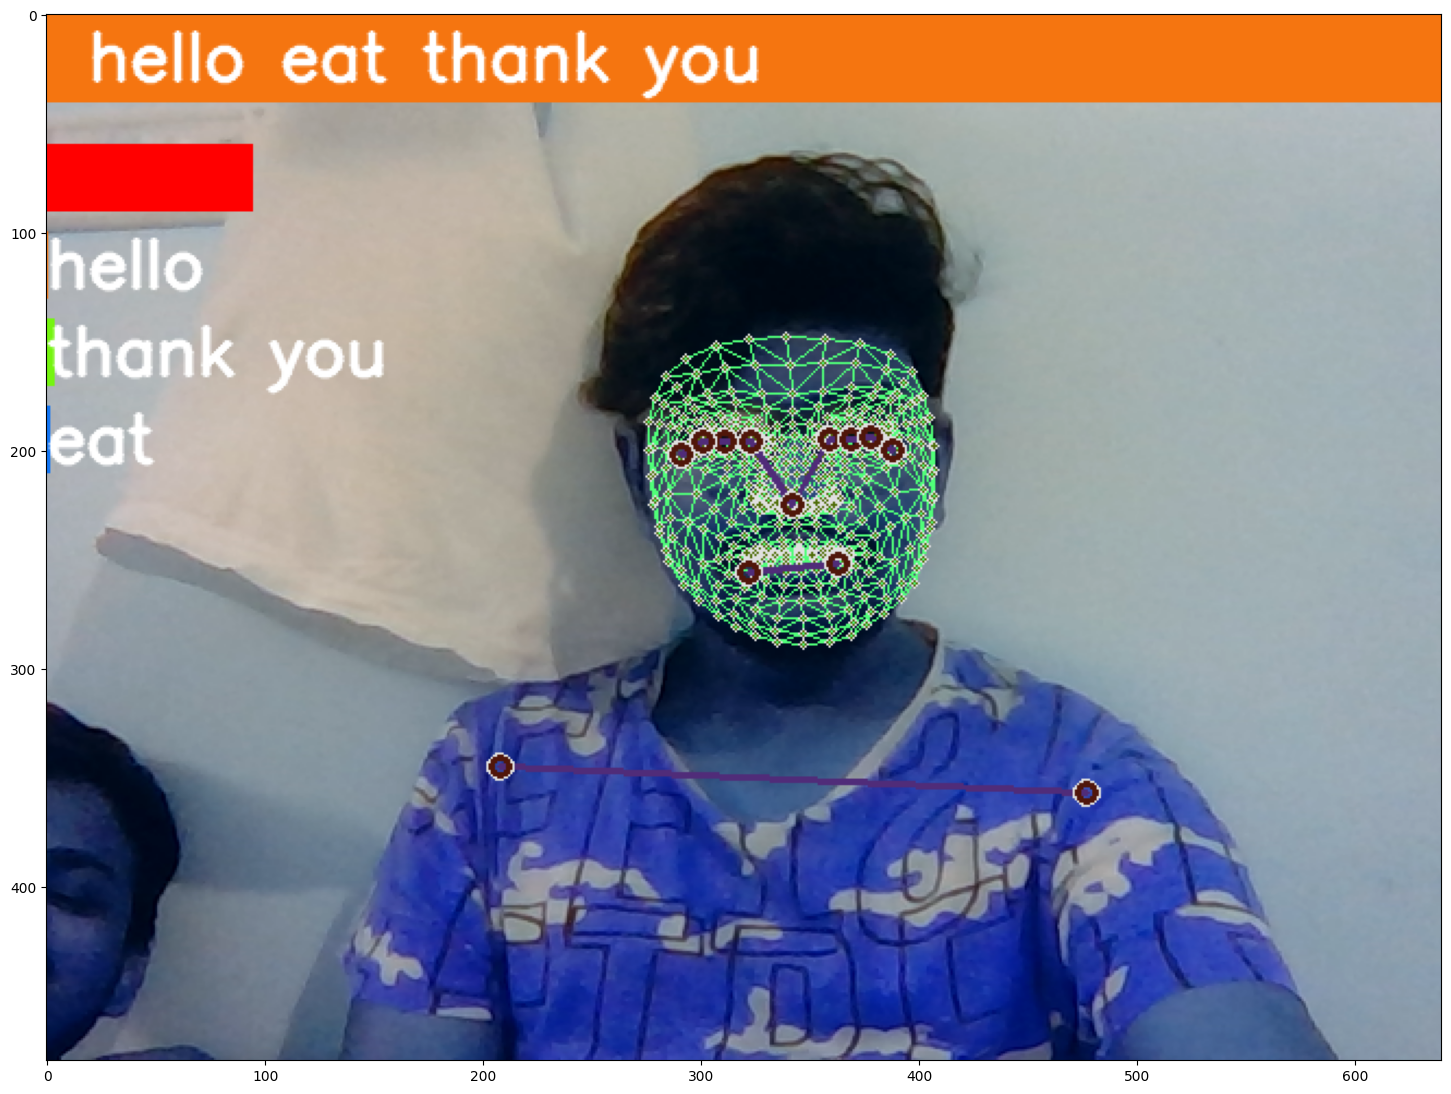

In [88]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))